# Task_7:  customer feedback analysis(NLP + Clustering)

## Objectives:

*   Load and explore the customer feedback data.
*   Clean and preprocess the raw text data for analysis.
*   Perform sentiment analysis using multiple approaches (lexicon-based, machine learning, and deep learning).
*   Extract relevant features from the processed text.
*   Apply clustering techniques to group similar feedback entries based on their text content.
*   Analyze the sentiment distribution within the identified clusters.
*   Visualize key terms associated with sentiment-specific clusters.

In [11]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
import matplotlib.patches as mpatches

In [13]:
%pip install spacy nltk
!python -m spacy download en_core_web_sm
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 35.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#   **Data Loading and Initial Exploration:**
    *   Loaded the dataset from the CSV file.
    *   Initial checks revealed the shape of the dataset, column names, and the presence of missing values and duplicates.
    *   Identified that the 'Confidence Score' column was loaded as an object and needed conversion.
    *   Observed missing values in several columns and a significant number of duplicate rows.

In [14]:
df = pd.read_csv('sentiment-analysis.csv', delimiter=',')

df.head()

Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score
0  "I love this product!", Positive, Twitter, 202...                     
1  "The service was terrible.", Negative, Yelp Re...                     
2  "This movie is amazing!", Positive, IMDb, 2023...                     
3  "I'm so disappointed with their customer suppo...                     
4  "Just had the best meal of my life!", Positive...

In [15]:
#Load CSV
file_path = '/content/sentiment-analysis.csv'
data = []
header = []

with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
    if lines:
        # Extract header from the first line and clean it
        header_line = lines[0].strip()
        # Split by comma and strip leading/trailing whitespace and quotes
        header = [col.strip().strip('"') for col in header_line.split(',')]

        # Process data rows
        for line in lines[1:]:
            line = line.strip()
            if line: # Avoid processing empty line
                row_data = [item.strip().strip('"') for item in line.split(',')]
                # Ensure row has the same number of columns as header, pad with None if needed
                while len(row_data) < len(header):
                    row_data.append(None)
                data.append(row_data[:len(header)]) # Truncate if more columns than header


df = pd.DataFrame(data, columns=header)

print("Shape of dataset:", df.shape)
display(df.head(10))

Shape of dataset: (98, 7)


Text Sentiment  \
0                               I love this product!  Positive   
1                          The service was terrible.  Negative   
2                             This movie is amazing!  Positive   
3   I'm so disappointed with their customer support.  Negative   
4                 Just had the best meal of my life!  Positive   
5             The quality of this product is subpar.  Negative   
6  I can't stop listening to this song. It's incr...  Positive   
7        Their website is so user-friendly. Love it!  Positive   
8               I loved the movie! It was fantastic!  Positive   
9                 The customer service was terrible.  Negative   

                Source            Date/Time           User ID       Location  \
0              Twitter  2023-06-15 09:23:14          @user123       New York   
1         Yelp Reviews  2023-06-15 11:45:32           user456    Los Angeles   
2                 IMDb  2023-06-15 14:10:22       moviefan789         London   
3         Online Forum  2023-06-15 17:35:11        forumuser1        Toronto   
4          TripAdvisor  2023-06-16 08:50:59          foodie22          Paris   
5       Amazon Reviews  2023-06-16 10:15:27        shopper123  San Francisco   
6              Spotify  2023-06-16 13:40:18     musiclover456         Berlin   
7  Website Testimonial  2023-06-16 16:05:36  testimonialuser1         Sydney   
8                 IMDb  2023-07-02 09:12:34           user123       New York   
9         Yelp Reviews  2023-07-02 10:45:21           user456    Los Angeles   

  Confidence Score  
0             0.85  
1             0.65  
2             0.92  
3             0.78  
4             0.88  
5             0.72  
6             0.91  
7             0.87  
8             0.92  
9             0.65

In [16]:
# Remove leading/trailing whitespace from column names to avoid KeyErrors
df.columns = df.columns.str.strip()

print(f"\n Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")


 Dataset Shape: 98 rows × 7 columns


In [17]:
# Attempt to convert 'Date/Time' to datetime, coercing errors
# Check if 'Date/Time' column exists before attempting conversion
if 'Date/Time' in df.columns:
    df['Date/Time'] = pd.to_datetime(df['Date/Time'], errors='coerce')
else:
    print("Warning: 'Date/Time' column not found after loading.")

In [18]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Text              98 non-null     object        
 1   Sentiment         96 non-null     object        
 2   Source            96 non-null     object        
 3   Date/Time         96 non-null     datetime64[ns]
 4   User ID           96 non-null     object        
 5   Location          96 non-null     object        
 6   Confidence Score  96 non-null     object        
dtypes: datetime64[ns](1), object(6)
memory usage: 5.5+ KB
None


In [19]:
display(df.describe(include='all'))

Text Sentiment        Source  \
count                     98        96            96   
unique                    76         2            27   
top     I love this product!  Positive  Online Store   
freq                       2        53            11   
mean                     NaN       NaN           NaN   
min                      NaN       NaN           NaN   
25%                      NaN       NaN           NaN   
50%                      NaN       NaN           NaN   
75%                      NaN       NaN           NaN   
max                      NaN       NaN           NaN   

                            Date/Time  User ID Location Confidence Score  
count                              96       96       96               96  
unique                            NaN       73       11               25  
top                               NaN  user456   Sydney             0.92  
freq                              NaN        4       12                9  
mean    2023-07-05 17:41:44.322916352      NaN      NaN              NaN  
min               2023-06-15 09:23:14      NaN      NaN              NaN  
25%               2023-07-02 17:21:28      NaN      NaN              NaN  
50%        2023-07-06 12:50:39.500000      NaN      NaN              NaN  
75%     2023-07-13 14:43:06.249999872      NaN      NaN              NaN  
max               2023-07-17 17:15:22      NaN      NaN              NaN

In [20]:
# Missing values analysis
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2),
    'Data_Type': df.dtypes
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print("\n MISSING VALUES ANALYSIS:")
print(missing_data.to_string(index=False))

# Duplicate analysis
duplicate_count = df.duplicated().sum()
print(f"\n DUPLICATE ROWS: {duplicate_count} ({duplicate_count/len(df)*100:.2f}%)")


 MISSING VALUES ANALYSIS:
          Column  Missing_Count  Missing_Percentage      Data_Type
       Sentiment              2                2.04         object
          Source              2                2.04         object
       Date/Time              2                2.04 datetime64[ns]
         User ID              2                2.04         object
        Location              2                2.04         object
Confidence Score              2                2.04         object

 DUPLICATE ROWS: 22 (22.45%)


# **Data Visualization (EDA):**

    *  Visualized the distribution of sentiment, feedback sources, text length, confidence scores, and top locations.
    *   Insights:
        *   The dataset has a relatively balanced distribution of positive and negative sentiments.
        *   Feedback comes from a variety of sources, with 'Online Store' being the most frequent.
        *   Text lengths vary, suggesting a mix of short and longer feedback.
        *   Confidence scores are distributed across the range, indicating varying certainty in the sentiment labels.
        *   'Sydney' is the most common location for feedback in this dataset.

In [25]:
!pip install -U kaleido


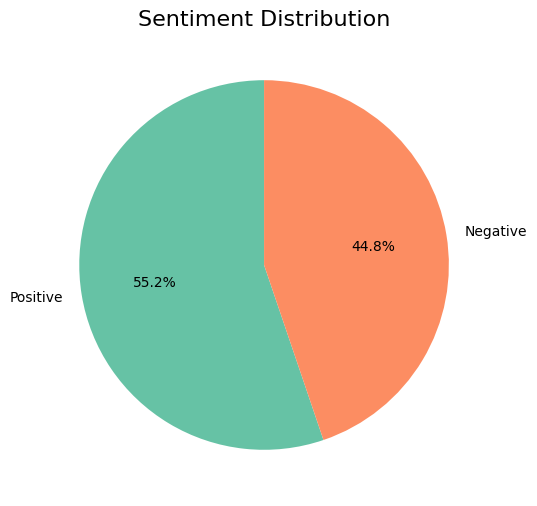

In [28]:
import matplotlib.pyplot as plt

# Prepare data
sentiment_counts = df['Sentiment'].value_counts()
labels = sentiment_counts.index
sizes = sentiment_counts.values
colors = plt.get_cmap('Set2').colors  # Nice qualitative colors

# Plot normal pie chart
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',  # Show percentages
    startangle=90,
    colors=colors
)

ax.set_title("Sentiment Distribution", fontsize=16)
plt.show()

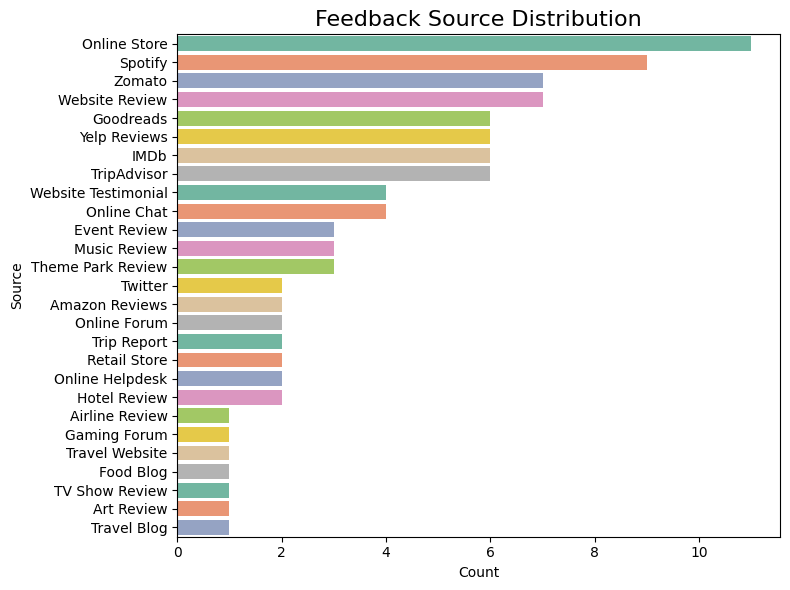

In [29]:

# Prepare data
source_counts = df['Source'].value_counts().reset_index()
source_counts.columns = ['Source', 'Count']

# Plot horizontal bar chart
plt.figure(figsize=(8,6))
sns.barplot(
    data=source_counts,
    y='Source',
    x='Count',
    palette='Set2'
)

plt.title("Feedback Source Distribution", fontsize=16)
plt.xlabel("Count")
plt.ylabel("Source")
plt.tight_layout()
plt.show()

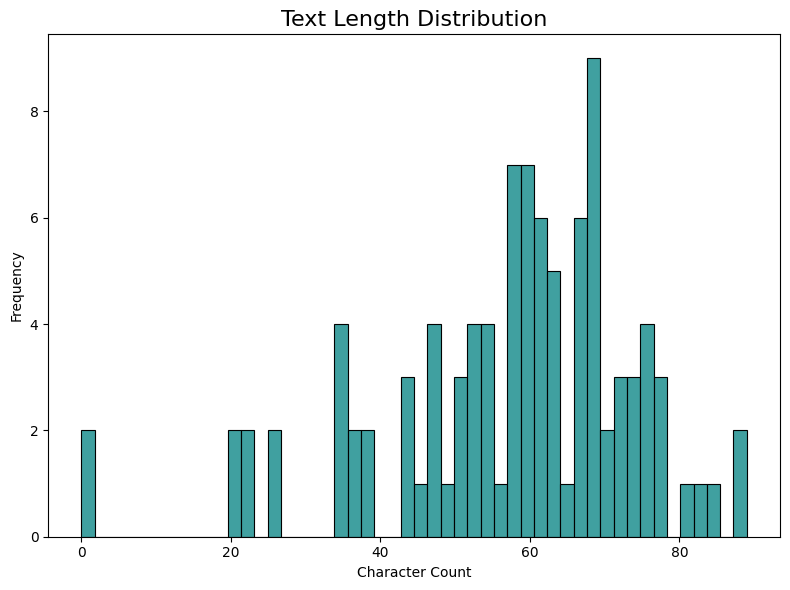

In [30]:


# Add a new column for text length
df['text_length'] = df['Text'].apply(lambda x: len(str(x)))

# Plot histogram
plt.figure(figsize=(8,6))
sns.histplot(df['text_length'], bins=50, color='teal', kde=False)

plt.title("Text Length Distribution", fontsize=16)
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

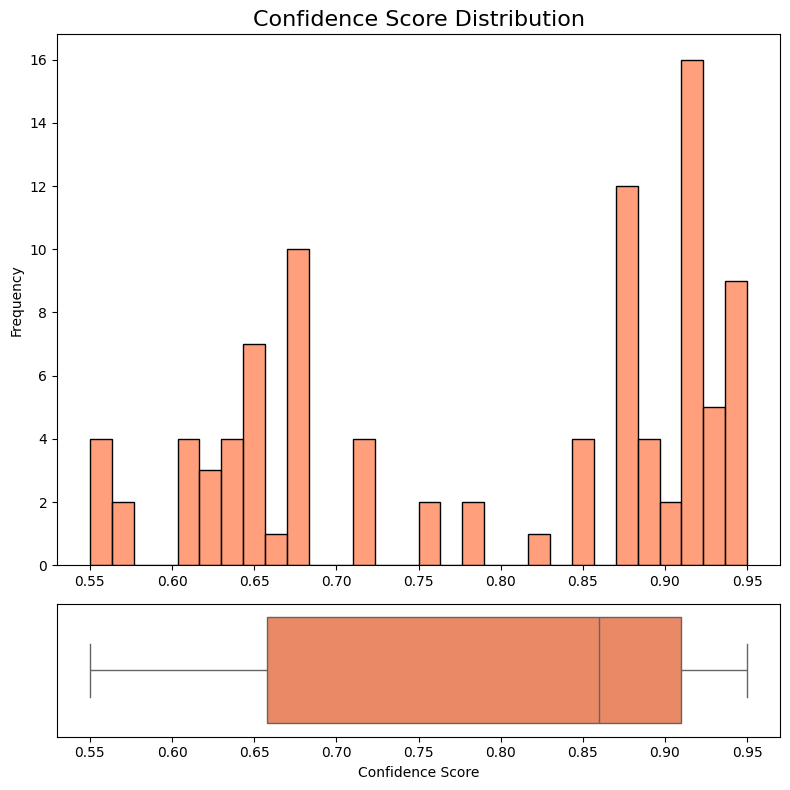

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'Confidence Score' is numeric and drop missing values
df_cleaned_confidence = df.dropna(subset=['Confidence Score']).copy()
df_cleaned_confidence['Confidence Score'] = pd.to_numeric(df_cleaned_confidence['Confidence Score'], errors='coerce')
df_cleaned_confidence.dropna(subset=['Confidence Score'], inplace=True)

# Create figure with histogram and boxplot
fig, ax = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={'height_ratios':[4,1]})

# Histogram
sns.histplot(df_cleaned_confidence['Confidence Score'], bins=30, color='coral', kde=False, ax=ax[0])
ax[0].set_title("Confidence Score Distribution", fontsize=16)
ax[0].set_xlabel("")
ax[0].set_ylabel("Frequency")

# Boxplot on the margin
sns.boxplot(x=df_cleaned_confidence['Confidence Score'], color='coral', ax=ax[1])
ax[1].set_xlabel("Confidence Score")
ax[1].set_ylabel("")
ax[1].set_yticks([])  # Hide y-axis for boxplot

plt.tight_layout()
plt.show()

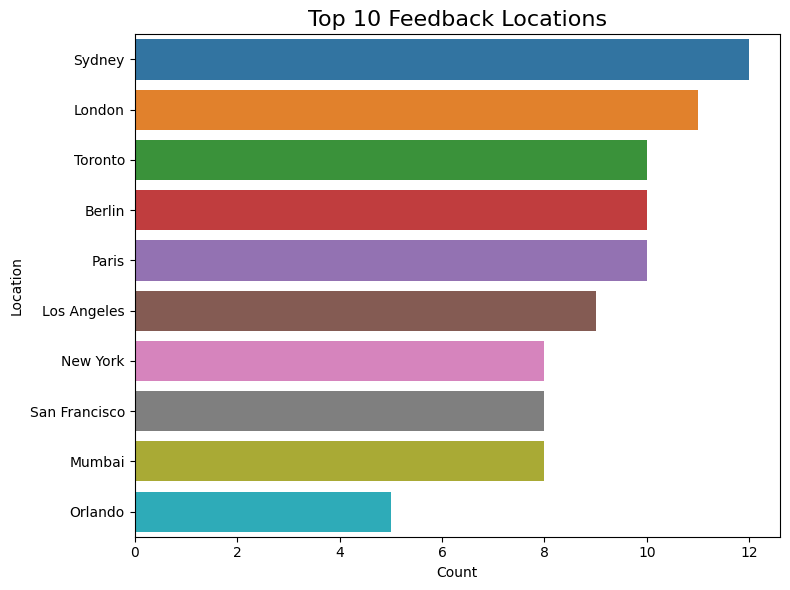

In [32]:

# Prepare top 10 locations
top_locations = df['Location'].value_counts().head(10).reset_index()
top_locations.columns = ['Location', 'Count']

# Plot horizontal bar chart
plt.figure(figsize=(8,6))
sns.barplot(
    data=top_locations,
    y='Location',
    x='Count',
    palette='tab10'  # Similar qualitative palette to Plotly
)

plt.title("Top 10 Feedback Locations", fontsize=16)
plt.xlabel("Count")
plt.ylabel("Location")
plt.tight_layout()
plt.show()


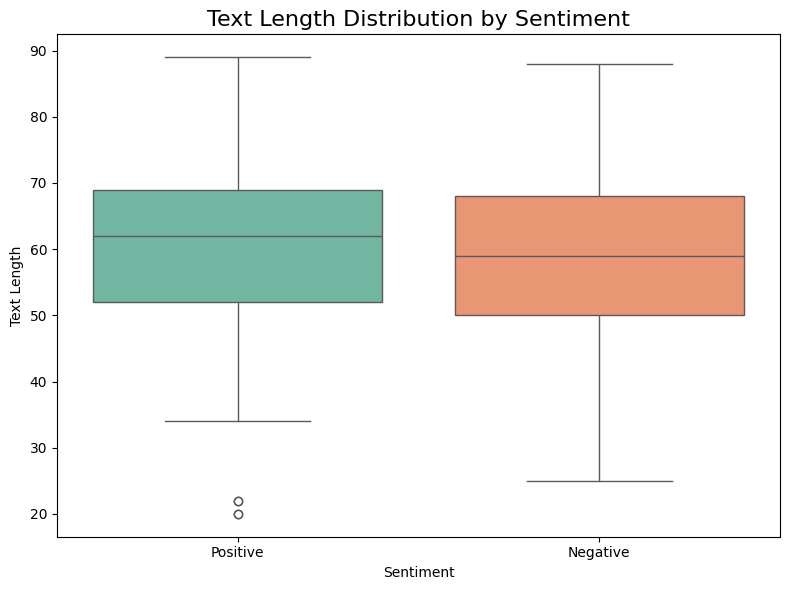

In [33]:

# Plot boxplot
plt.figure(figsize=(8,6))
sns.boxplot(
    data=df,
    x='Sentiment',
    y='text_length',
    palette='Set2'
)

plt.title("Text Length Distribution by Sentiment", fontsize=16)
plt.xlabel("Sentiment")
plt.ylabel("Text Length")
plt.tight_layout()
plt.show()

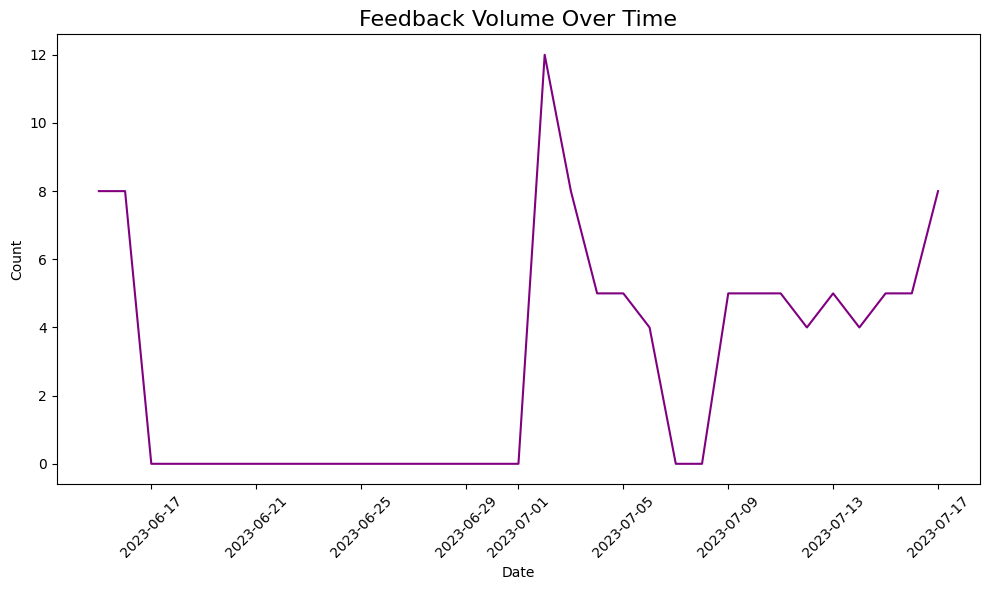

In [34]:

# Ensure 'Date/Time' is datetime and drop missing values
df_cleaned_datetime = df.dropna(subset=['Date/Time']).copy()
df_cleaned_datetime['Date/Time'] = pd.to_datetime(df_cleaned_datetime['Date/Time'])

# Resample to daily counts
daily_counts = df_cleaned_datetime.set_index('Date/Time').resample('D').size().reset_index(name='Count')

# Plot line chart
plt.figure(figsize=(10,6))
sns.lineplot(data=daily_counts, x='Date/Time', y='Count', color='purple')

plt.title("Feedback Volume Over Time", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

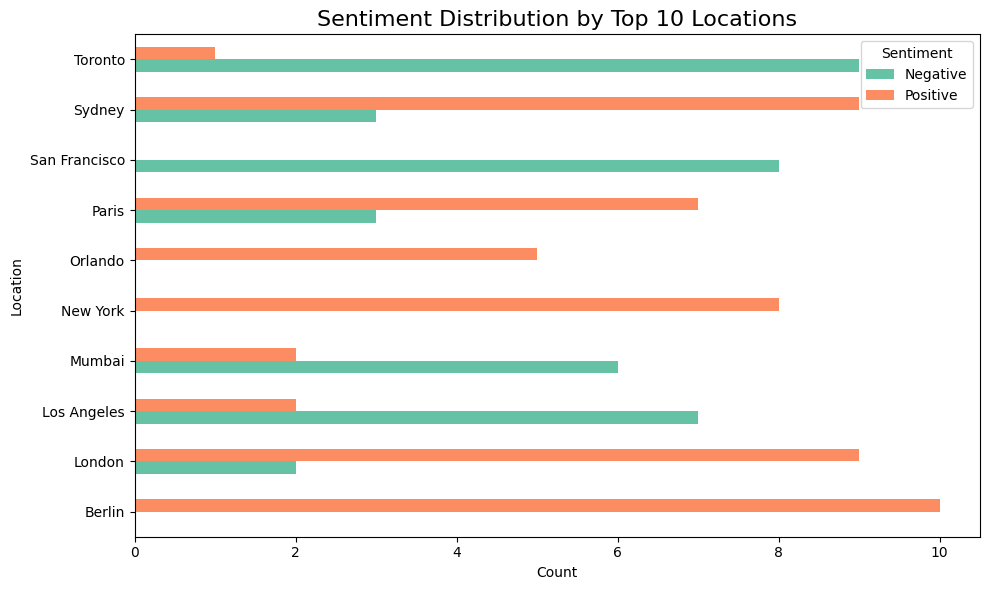

In [35]:
# Get the top 10 locations
top_10_locations = df['Location'].value_counts().head(10).index

# Filter the DataFrame to include only the top 10 locations
df_top_locations = df[df['Location'].isin(top_10_locations)]

# Group by Location and Sentiment and count the occurrences
location_sentiment_counts = df_top_locations.groupby(['Location', 'Sentiment']).size().reset_index(name='Count')

# Pivot data for grouped bar chart
pivot_df = location_sentiment_counts.pivot(index='Location', columns='Sentiment', values='Count').fillna(0)

# Plot grouped horizontal bar chart
pivot_df.plot(kind='barh',
              stacked=False,
              figsize=(10,6),
              color=sns.color_palette("Set2", n_colors=len(pivot_df.columns)))

plt.title("Sentiment Distribution by Top 10 Locations", fontsize=16)
plt.xlabel("Count")
plt.ylabel("Location")
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

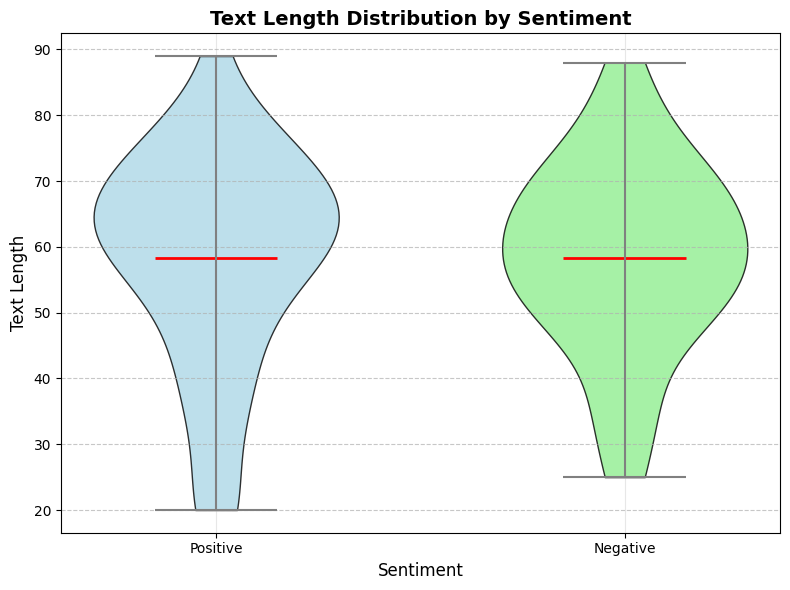

In [19]:
# Filter out sentiments with no valid text length data before plotting
sentiment_data = {sent: df[df['Sentiment'] == sent]['text_length'].dropna().values
                  for sent in df['Sentiment'].unique()}
valid_sentiments = [sent for sent, data in sentiment_data.items() if len(data) > 0]
valid_data = [sentiment_data[sent] for sent in valid_sentiments]

if valid_data: # Check if there is any valid data to plot
    fig, ax5 = plt.subplots(figsize=(8, 6)) # Create a new figure and axes for this plot
    parts = ax5.violinplot(valid_data,
                           positions=range(len(valid_sentiments)),
                           showmeans=True, showextrema=True,
                           widths=0.6) # Adjust width for better spacing

    # Customize violin plot colors
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i % len(colors)])
        pc.set_edgecolor('black')
        pc.set_alpha(0.8)

    # Customize mean and extrema lines
    for part in ('cbars','cmins','cmaxes'):
        parts[part].set_edgecolor('gray')
        parts[part].set_linewidth(1.5)

    parts['cmeans'].set_edgecolor('red')
    parts['cmeans'].set_linewidth(2)


    ax5.set_title('Text Length Distribution by Sentiment', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Sentiment', fontsize=12)
    ax5.set_ylabel('Text Length', fontsize=12)
    ax5.set_xticks(range(len(valid_sentiments)))
    ax5.set_xticklabels(valid_sentiments)
    ax5.grid(axis='y', alpha=0.7, linestyle='--') # Add horizontal grid lines
    ax5.grid(axis='x', alpha=0.3)


else:
    fig, ax5 = plt.subplots(figsize=(8, 6)) # Create a new figure and axes even if no data
    ax5.text(0.5, 0.5, "No valid data for Violin Plot", horizontalalignment='center', verticalalignment='center', transform=ax5.transAxes)
    ax5.set_title('Text Length Distribution by Sentiment', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Sentiment', fontsize=12)
    ax5.set_ylabel('Text Length', fontsize=12)

plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

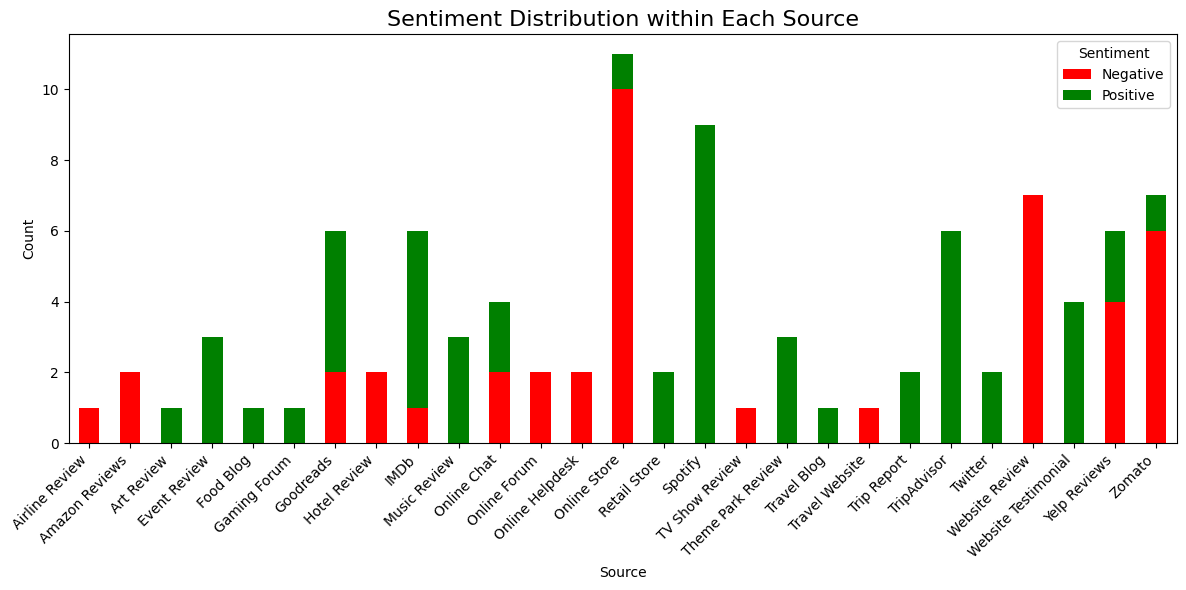

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# Group by Source and Sentiment and count occurrences
source_sentiment_counts = df.groupby(['Source', 'Sentiment']).size().reset_index(name='Count')

# Pivot data for stacked bar chart
pivot_df = source_sentiment_counts.pivot(index='Source', columns='Sentiment', values='Count').fillna(0)

# Define colors for sentiments
colors = {'Positive':'green', 'Negative':'red', 'Neutral':'gray'}
sentiment_colors = [colors[col] for col in pivot_df.columns]

# Plot stacked bar chart
pivot_df.plot(kind='bar',
              stacked=True,
              figsize=(12,6),
              color=sentiment_colors)

plt.title("Sentiment Distribution within Each Source", fontsize=16)
plt.xlabel("Source")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

In [21]:
# Store original shape
original_shape = df.shape
print(f"\n Original dataset shape: {original_shape}")


 Original dataset shape: (98, 8)


In [22]:
# Remove rows with null Text
null_text_count = df['Text'].isnull().sum()
df_clean = df[df['Text'].notna()].copy()

In [23]:
# Remove duplicates
duplicate_count = df_clean.duplicated(subset=['Text']).sum()
df_clean = df_clean.drop_duplicates(subset=['Text'], keep='first').copy()
print(f" Removed {duplicate_count} duplicate rows")

 Removed 22 duplicate rows


In [24]:
# Remove empty strings
empty_text_count = (df_clean['Text'].str.strip() == '').sum()
df_clean = df_clean[df_clean['Text'].str.strip() != ''].copy()
print(f" Removed {empty_text_count} rows with empty Text")

 Removed 1 rows with empty Text


In [25]:
# Final shape
final_shape = df_clean.shape
print(f"\n Cleaned dataset shape: {final_shape}")
print(f" Total rows removed: {original_shape[0] - final_shape[0]}")
print(f" Data retention rate: {final_shape[0]/original_shape[0]*100:.2f}%")


 Cleaned dataset shape: (75, 8)
 Total rows removed: 23
 Data retention rate: 76.53%


In [26]:
df.head()

Text Sentiment        Source  \
0                              I love this product!  Positive       Twitter   
1                         The service was terrible.  Negative  Yelp Reviews   
2                            This movie is amazing!  Positive          IMDb   
3  I'm so disappointed with their customer support.  Negative  Online Forum   
4                Just had the best meal of my life!  Positive   TripAdvisor   

            Date/Time      User ID     Location Confidence Score  text_length  
0 2023-06-15 09:23:14     @user123     New York             0.85           20  
1 2023-06-15 11:45:32      user456  Los Angeles             0.65           25  
2 2023-06-15 14:10:22  moviefan789       London             0.92           22  
3 2023-06-15 17:35:11   forumuser1      Toronto             0.78           48  
4 2023-06-16 08:50:59     foodie22        Paris             0.88           34


#    **Text Data Cleaning and Preprocessing:**
    *   Performed several cleaning steps on the 'Text' column, including converting to lowercase, removing URLs, emails, mentions, hashtags, numbers, punctuation, and extra whitespaces.
    *   Applied tokenization, stopword removal, and lemmatization to prepare the text for analysis.
    *   Calculated processed text statistics (word count, unique word count, lexical diversity).
    *   Insights:
        *   The cleaning process successfully standardized the text and removed noise.
        *   Tokenization and lemmatization created a cleaner set of terms for analysis.
        *   Processed text statistics provide a quantitative view of the text complexity after cleaning

In [27]:
# Initialize NLP tools
nlp = spacy.load('en_core_web_sm')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Extended stopwords
stop_words = set(stopwords.words('english'))
custom_stopwords = {'im', 'ive', 'thats', 'dont', 'didnt', 'cant', 'wont', 'wouldnt'}
stop_words.update(custom_stopwords)

print("="*80)
print("TEXT PREPROCESSING PIPELINE")
print("="*80)

# Create preprocessing columns
df_clean['text_lowercase'] = df_clean['Text'].str.lower()
print(" Step 1: Converted to lowercase")

# Remove URLs
df_clean['text_no_urls'] = df_clean['text_lowercase'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
print(" Step 2: Removed URLs")

# Remove email addresses
df_clean['text_no_emails'] = df_clean['text_no_urls'].str.replace(r'\S+@\S+', '', regex=True)
print(" Step 3: Removed email addresses")

# Remove mentions and hashtags
df_clean['text_no_mentions'] = df_clean['text_no_emails'].str.replace(r'@\w+|#\w+', '', regex=True)
print(" Step 4: Removed mentions and hashtags")

# Remove numbers
df_clean['text_no_numbers'] = df_clean['text_no_mentions'].str.replace(r'\d+', '', regex=True)
print(" Step 5: Removed numbers")

# Remove punctuation and special characters
df_clean['text_no_punct'] = df_clean['text_no_numbers'].str.replace(r'[^\w\s]', ' ', regex=True)
print(" Step 6: Removed punctuation")

# Remove extra whitespaces
df_clean['text_clean'] = df_clean['text_no_punct'].str.replace(r'\s+', ' ', regex=True).str.strip()
print(" Step 7: Removed extra whitespaces")

# Show example
print("\n" + "="*80)
print("PREPROCESSING EXAMPLE")
print("="*80)
sample_idx = 0
print(f"\nOriginal: {df_clean.loc[sample_idx, 'Text']}")
print(f"\nCleaned: {df_clean.loc[sample_idx, 'text_clean']}")

TEXT PREPROCESSING PIPELINE
 Step 1: Converted to lowercase
 Step 2: Removed URLs
 Step 3: Removed email addresses
 Step 4: Removed mentions and hashtags
 Step 5: Removed numbers
 Step 6: Removed punctuation
 Step 7: Removed extra whitespaces

PREPROCESSING EXAMPLE

Original: I love this product!

Cleaned: i love this product


In [28]:
# ============================================================================
#  ADVANCED TEXT PREPROCESSING - PART 2 (TOKENIZATION & NORMALIZATION)
# ============================================================================
"""
Apply tokenization, stopword removal, and lemmatization to the cleaned text.
This completes the text preprocessing pipeline.
"""
# NLTK's tokenizer is required for this step
import nltk
nltk.download('punkt')
# Download the missing punkt_tab resource
nltk.download('punkt_tab')


# Define the function for token-level processing
def normalize_tokens(text):
    # Tokenize the text into individual words
    tokens = nltk.word_tokenize(text)

    # Lemmatize tokens and remove stopwords simultaneously for efficiency
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Join the processed tokens back into a single string
    return ' '.join(lemmatized_tokens)

print("="*80)
print("TOKEN NORMALIZATION PIPELINE")
print("="*80)

# Apply the normalization function to the 'text_clean' column
df_clean['text_processed'] = df_clean['text_clean'].apply(normalize_tokens)
print(" Step 8: Tokenized text")
print(" Step 9: Removed stopwords")
print(" Step 10: Lemmatized tokens")

# Display the final transformation
print("\n" + "="*80)
print("FINAL PREPROCESSING EXAMPLE")
print("="*80)
sample_idx = 0 # Using the same sample index
print(f"\nOriginal: {df_clean.loc[sample_idx, 'Text']}")
print(f"\nCleaned (String-level): {df_clean.loc[sample_idx, 'text_clean']}")
print(f"\nFinal Processed (Token-level): {df_clean.loc[sample_idx, 'text_processed']}")

print("\n\n" + "="*80)
print("Text preprocessing is complete.")
print("The 'text_processed' column is now ready for the next phase: Feature Extraction.")
print("="*80)

TOKEN NORMALIZATION PIPELINE


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


 Step 8: Tokenized text
 Step 9: Removed stopwords
 Step 10: Lemmatized tokens

FINAL PREPROCESSING EXAMPLE

Original: I love this product!

Cleaned (String-level): i love this product

Final Processed (Token-level): love product


Text preprocessing is complete.
The 'text_processed' column is now ready for the next phase: Feature Extraction.


In [29]:
# ============================================================================
#  ADVANCED TEXT PREPROCESSING - PART 2 (TOKENIZATION & LEMMATIZATION)
# ============================================================================
"""
Tokenization, stopword removal, and lemmatization
"""
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm

# Tokenization
tqdm.pandas(desc="Tokenizing")
df_clean['tokens'] = df_clean['text_clean'].progress_apply(word_tokenize)
print(" Tokenization completed")

# Remove stopwords
tqdm.pandas(desc="Removing stopwords")
df_clean['tokens_no_stop'] = df_clean['tokens'].progress_apply(
    lambda tokens: [word for word in tokens if word not in stop_words and len(word) > 2]
)
print(" Stopword removal completed")

# Lemmatization
tqdm.pandas(desc="Lemmatizing")
df_clean['tokens_lemmatized'] = df_clean['tokens_no_stop'].progress_apply(
    lambda tokens: [lemmatizer.lemmatize(word) for word in tokens]
)
print(" Lemmatization completed")

# Stemming (alternative approach)
tqdm.pandas(desc="Stemming")
df_clean['tokens_stemmed'] = df_clean['tokens_no_stop'].progress_apply(
    lambda tokens: [stemmer.stem(word) for word in tokens]
)
print(" Stemming completed")

# Join tokens back to text
df_clean['text_processed'] = df_clean['tokens_lemmatized'].apply(lambda x: ' '.join(x))
df_clean['text_stemmed'] = df_clean['tokens_stemmed'].apply(lambda x: ' '.join(x))

# Calculate processed text statistics
df_clean['word_count'] = df_clean['tokens_lemmatized'].apply(len)
df_clean['unique_word_count'] = df_clean['tokens_lemmatized'].apply(lambda x: len(set(x)))
df_clean['lexical_diversity'] = df_clean['unique_word_count'] / (df_clean['word_count'] + 1)

Tokenizing:   0%|          | 0/75 [00:00<?, ?it/s]

 Tokenization completed


Removing stopwords:   0%|          | 0/75 [00:00<?, ?it/s]

 Stopword removal completed


Lemmatizing:   0%|          | 0/75 [00:00<?, ?it/s]

 Lemmatization completed


Stemming:   0%|          | 0/75 [00:00<?, ?it/s]

 Stemming completed



#    **Sentiment Analysis (Lexicon-Based - VADER):**
    *   Applied VADER, a lexicon-based tool, to the processed text to get sentiment scores and labels.
    *   Insights:
        *   VADER provided sentiment labels and scores based on its pre-defined lexicon.
        *   The distribution of VADER sentiments can be compared to the original sentiment labels.


In [31]:
# ============================================================================
#  LEXICON-BASED SENTIMENT ANALYSIS (VADER)
# ============================================================================
"""
Apply a lexicon-based sentiment analysis tool (VADER) to the processed text.
VADER ( Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and
rule-based sentiment analysis tool that is specifically attuned to sentiments
expressed in social media.
"""
# Install VADER if not already installed
try:
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
except ImportError:
    %pip install nltk
    import nltk

# Download the VADER lexicon
import nltk
nltk.download('vader_lexicon')

# Now import SentimentIntensityAnalyzer after ensuring nltk and lexicon are available
from nltk.sentiment.vader import SentimentIntensityAnalyzer


print("="*80)
print("SENTIMENT ANALYSIS: LEXICON-BASED (VADER)")
print("="*80)

# Initialize VADER sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get VADER sentiment score and label
def vader_sentiment(text):
    if not isinstance(text, str):
        return None, None # Handle non-string input

    scores = analyzer.polarity_scores(text)
    # Determine sentiment label based on compound score
    if scores['compound'] >= 0.05:
        sentiment = 'Positive'
    elif scores['compound'] <= -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    return sentiment, scores['compound']

# Apply VADER to the processed text and create new columns
# Use df_clean as it contains the processed text
df_clean['vader_sentiment_label'], df_clean['vader_sentiment_score'] = zip(*df_clean['text_processed'].apply(vader_sentiment))

print("✓ VADER sentiment analysis completed.")

# Display the head of the DataFrame with new VADER columns
print("\n" + "="*80)
print("VADER SENTIMENT ANALYSIS RESULTS (PREVIEW)")
print("="*80)
display(df_clean[['Text', 'text_processed', 'Sentiment', 'vader_sentiment_label', 'vader_sentiment_score']].head())

# Display sentiment distribution from VADER
print("\n" + "="*80)
print("VADER SENTIMENT DISTRIBUTION")
print("="*80)
display(df_clean['vader_sentiment_label'].value_counts())

print("\n" + "="*80)
print("Lexicon-based sentiment analysis is complete. We can now proceed to Machine Learning based approaches.")
print("="*80)

SENTIMENT ANALYSIS: LEXICON-BASED (VADER)
✓ VADER sentiment analysis completed.

VADER SENTIMENT ANALYSIS RESULTS (PREVIEW)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Text  \
0                              I love this product!   
1                         The service was terrible.   
2                            This movie is amazing!   
3  I'm so disappointed with their customer support.   
4                Just had the best meal of my life!   

                  text_processed Sentiment vader_sentiment_label  \
0                   love product  Positive              Positive   
1               service terrible  Negative              Negative   
2                  movie amazing  Positive              Positive   
3  disappointed customer support  Negative              Negative   
4                 best meal life  Positive              Positive   

   vader_sentiment_score  
0                 0.6369  
1                -0.4767  
2                 0.5859  
3                -0.1027  
4                 0.6369


VADER SENTIMENT DISTRIBUTION


vader_sentiment_label
Positive    37
Negative    31
Neutral      7
Name: count, dtype: int64


Lexicon-based sentiment analysis is complete. We can now proceed to Machine Learning based approaches.



#   **Sentiment Analysis (Deep Learning Approach - Simple ANN):**
    *   Implemented and trained a simple Artificial Neural Network for sentiment classification.
    *   Evaluated the model's performance.
    *   Insights:
        *   Deep learning models can also be applied to sentiment analysis, potentially capturing more complex patterns.
        *   Performance metrics allow comparison with the traditional ML approach.


In [32]:
# ============================================================================
#  DEEP LEARNING SENTIMENT ANALYSIS (SIMPLE ANN)
# ============================================================================
"""
Implement a basic Artificial Neural Network (ANN) for sentiment analysis
using pre-trained word embeddings or by learning embeddings from scratch.
This serves as an introduction to Deep Learning for this task.
"""
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import pandas as pd

print("="*80)
print("SENTIMENT ANALYSIS: DEEP LEARNING APPROACH (SIMPLE ANN)")
print("="*80)

# --- 1. Data Preparation for Deep Learning ---
# Use the cleaned data and the original Sentiment labels
df_dl = df_clean.dropna(subset=['Sentiment']).copy()

# Encode the sentiment labels (Positive, Negative, Neutral) into numerical form
# Use the existing sentiment_mapping for consistency if available, otherwise create one
if 'sentiment_mapping' not in locals():
     sentiment_mapping = {'Positive': 1, 'Negative': 0, 'Neutral': 2}
     print("Note: Creating new sentiment_mapping for DL as it was not found.")

# Filter out sentiments that are not in the mapping if necessary
df_dl = df_dl[df_dl['Sentiment'].isin(sentiment_mapping.keys())].copy()


y_text = df_dl['Sentiment'].values
# Ensure all labels in y_text are in sentiment_mapping
y_encoded = np.array([sentiment_mapping[label] for label in y_text])


# Tokenize the text data
# Use the 'text_processed' column for consistency with ML
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>") # Limit vocabulary size
tokenizer.fit_on_texts(df_dl['text_processed'])
word_index = tokenizer.word_index

# Convert texts to sequences of integers
sequences = tokenizer.texts_to_sequences(df_dl['text_processed'])

# Pad sequences to ensure uniform input length
max_length = max([len(x) for x in sequences]) if sequences else 0 # Determine max length, handle empty case
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

print(f" Vocabulary size: {len(word_index)}")
print(f" Max sequence length: {max_length}")
print(f" Padded sequences shape: {padded_sequences.shape}")

# Split data into training and testing sets
# Use the same random_state as the ML split for potential comparison consistency
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    padded_sequences, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

print(f"\n Training data shape (padded): {X_train_dl.shape}")
print(f" Testing data shape (padded): {X_test_dl.shape}")
print(f" Training labels shape: {y_train_dl.shape}")
print(f" Testing labels shape: {y_test_dl.shape}")

# Determine the number of classes for the output layer
num_classes = len(sentiment_mapping)


# --- 2. Build the Deep Learning Model ---
model_dl = Sequential([

    Embedding(input_dim=len(word_index) + 1, output_dim=64, input_length=max_length),
    GlobalAveragePooling1D(),

    # Dense layers: Standard feedforward layers
    Dense(64, activation='relu'),
    Dropout(0.5), # Dropout for regularization
    Dense(num_classes, activation='softmax') # Output layer with softmax for multi-class classification
])

# Compile the model
model_dl.compile(
    loss='sparse_categorical_crossentropy', # Suitable for integer encoded labels
    optimizer='adam',
    metrics=['accuracy']
)

model_dl.summary()


history = model_dl.fit(
    X_train_dl, y_train_dl,
    epochs=20, # Number of training epochs
    validation_split=0.2, # Percentage of training data to use for validation
    verbose=1 # Show training progress
)

print("\n✓ Deep Learning model training completed.")


# --- 4. Evaluate the Model ---
# Evaluate the model on the test set
loss, accuracy = model_dl.evaluate(X_test_dl, y_test_dl, verbose=0)
print(f"\n Test Accuracy: {accuracy:.4f}")

# Get predictions for the classification report
y_pred_dl = np.argmax(model_dl.predict(X_test_dl), axis=-1)

# Decode predicted labels back to sentiment names for evaluation readability
# Create a reverse mapping
reverse_sentiment_mapping_dl = {v: k for k, v in sentiment_mapping.items()}
y_test_labels_dl = pd.Series(y_test_dl).map(reverse_sentiment_mapping_dl)
y_pred_labels_dl = pd.Series(y_pred_dl).map(reverse_sentiment_mapping_dl)


# Print classification report
print("\n" + "="*80)
print("DEEP LEARNING MODEL EVALUATION")
print("="*80)
print("\nClassification Report:")
print(classification_report(y_test_labels_dl, y_pred_labels_dl))

print("\n" + "="*80)
print("Deep Learning based sentiment analysis is complete. We can now compare the performance of the three models.")
print("="*80)

SENTIMENT ANALYSIS: DEEP LEARNING APPROACH (SIMPLE ANN)
Note: Creating new sentiment_mapping for DL as it was not found.
 Vocabulary size: 224
 Max sequence length: 8
 Padded sequences shape: (75, 8)

 Training data shape (padded): (56, 8)
 Testing data shape (padded): (19, 8)
 Training labels shape: (56,)
 Testing labels shape: (19,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 868ms/step - accuracy: 0.4744 - loss: 1.0927 - val_accuracy: 0.3333 - val_loss: 1.0820
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step - accuracy: 0.3314 - loss: 1.0857 - val_accuracy: 0.5833 - val_loss: 1.0696
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.7652 - loss: 1.0657 - val_accuracy: 0.7500 - val_loss: 1.0572
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.5256 - loss: 1.0528 - val_accuracy: 0.7500 - val_loss: 1.0442
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step - accuracy: 0.7860 - loss: 1.0421 - val_accuracy: 0.7500 - val_loss: 1.0315
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step - accuracy: 0.7244 - loss: 1.0293 - val_accuracy: 0.7500 - val_loss: 1.0188
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.8826 - loss: 1.0043 - val_accuracy: 0.7500 - val_loss: 1.0055
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - accuracy: 0.6989 - loss: 1.0073 - val_accuracy: 0.6667 - val_loss:


#    **Sentiment Analysis (Machine Learning Approach):**
    *   Trained a Multinomial Naive Bayes classifier on TF-IDF features of the processed text using the original sentiment labels.
    *   Evaluated the model's performance using accuracy and a classification report.
    *   Insights:
        *   A machine learning model can effectively classify sentiment based on text features.
        *   The evaluation metrics (Accuracy, Precision, Recall, F1-score) provide a quantitative measure of the model's performance on unseen data.

In [33]:
# ============================================================================
#  MACHINE LEARNING SENTIMENT ANALYSIS
# ============================================================================
"""
Implement a machine learning model for sentiment analysis using the existing
'Sentiment' column as labels. This involves:
1. Data Preparation (Splitting into training and testing sets)
2. Feature Extraction (Using TF-IDF or similar on the processed text)
3. Model Selection and Training (Using a classifier like Naive Bayes or Logistic Regression)
4. Model Evaluation
"""
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

print("="*80)
print("SENTIMENT ANALYSIS: MACHINE LEARNING APPROACH")
print("="*80)

# --- 1. Data Preparation ---
# Drop rows where 'Sentiment' is missing, as these are needed for training
df_ml = df_clean.dropna(subset=['Sentiment']).copy()

# Map sentiment labels to numerical values for the model
sentiment_mapping = {'Positive': 1, 'Negative': 0, 'Neutral': 2} # Assuming Neutral exists, adjust if needed
df_ml['sentiment_encoded'] = df_ml['Sentiment'].map(sentiment_mapping)

# Define features (X) and target (y)
# Use the 'text_processed' column which contains cleaned and normalized text
X = df_ml['text_processed']
y = df_ml['sentiment_encoded']

# Split data into training and testing sets
# Stratify by y to ensure similar sentiment distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f" Training data shape: {X_train.shape}")
print(f" Testing data shape: {X_test.shape}")


# --- 2. Feature Extraction ---
# Initialize and fit TF-IDF Vectorizer on the training data
# Reuse parameters from the previous TF-IDF step for consistency, but fit on training data
tfidf_vectorizer_ml = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.7,
    sublinear_tf=True
)

X_train_tfidf = tfidf_vectorizer_ml.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer_ml.transform(X_test) # Transform test data using the fitted vectorizer

print(f"\n Training data TF-IDF shape: {X_train_tfidf.shape}")
print(f" Testing data TF-IDF shape: {X_test_tfidf.shape}")


# --- 3. Model Selection and Training ---
# Using Multinomial Naive Bayes, a common and effective model for text classification
model = MultinomialNB()

# Train the model
model.fit(X_train_tfidf, y_train)

print("\n✓ Machine Learning model training completed.")


# --- 4. Model Evaluation ---
# Predict sentiment on the test set
y_pred = model.predict(X_test_tfidf)

# Decode predicted labels back to sentiment names for evaluation readability
# Create a reverse mapping
reverse_sentiment_mapping = {v: k for k, v in sentiment_mapping.items()}
y_test_labels = y_test.map(reverse_sentiment_mapping)
y_pred_labels = pd.Series(y_pred).map(reverse_sentiment_mapping)


# Evaluate the model
print("\n" + "="*80)
print("MACHINE LEARNING MODEL EVALUATION")
print("="*80)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels))

print("\n" + "="*80)
print("Machine Learning based sentiment analysis is complete. We can now consider Deep Learning or proceed to evaluation.")
print("="*80)

SENTIMENT ANALYSIS: MACHINE LEARNING APPROACH
 Training data shape: (56,)
 Testing data shape: (19,)

 Training data TF-IDF shape: (56, 11)
 Testing data TF-IDF shape: (19, 11)

✓ Machine Learning model training completed.

MACHINE LEARNING MODEL EVALUATION
Accuracy: 0.7895

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.50      0.67         8
    Positive       0.73      1.00      0.85        11

    accuracy                           0.79        19
   macro avg       0.87      0.75      0.76        19
weighted avg       0.85      0.79      0.77        19


Machine Learning based sentiment analysis is complete. We can now consider Deep Learning or proceed to evaluation.


SENTIMENT MODEL PERFORMANCE COMPARISON


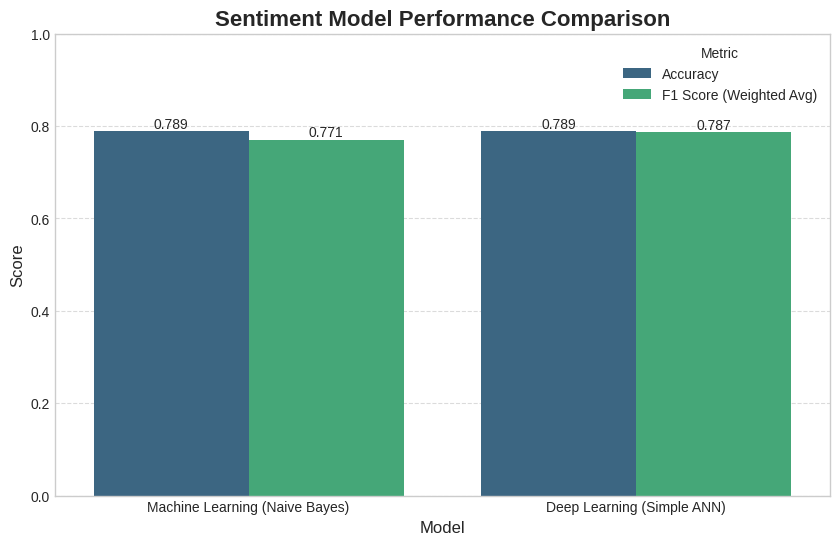

In [95]:
# ============================================================================
#VISUALIZE SENTIMENT MODEL PERFORMANCE COMPARISON
# ============================================================================
"""
Visualize the performance metrics (Accuracy and F1-score) of the trained
Machine Learning and Deep Learning sentiment analysis models to compare them
visually and help in selecting the best model for further analysis.
"""
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

print("="*80)
print("SENTIMENT MODEL PERFORMANCE COMPARISON")
print("="*80)

# Get classification report dictionaries
ml_report = classification_report(y_test_labels, y_pred_labels, output_dict=True)
dl_report = classification_report(y_test_labels_dl, y_pred_labels_dl, output_dict=True)

# Extract relevant metrics
# Using 'weighted avg' F1-score as it's suitable for imbalanced datasets
ml_accuracy = accuracy_score(y_test, y_pred)
ml_f1 = ml_report['weighted avg']['f1-score']

dl_accuracy = accuracy_score(y_test_dl, y_pred_dl)
dl_f1 = dl_report['weighted avg']['f1-score']

# Create a DataFrame for plotting
performance_data = {
    'Model': ['Machine Learning (Naive Bayes)', 'Deep Learning (Simple ANN)'],
    'Accuracy': [ml_accuracy, dl_accuracy],
    'F1 Score (Weighted Avg)': [ml_f1, dl_f1]
}
df_performance = pd.DataFrame(performance_data)

# Reshape DataFrame for melting (suitable for seaborn barplot)
df_performance_melted = df_performance.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create the bar plot
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_performance_melted, palette='viridis')

plt.title('Sentiment Model Performance Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 1) # Scores are between 0 and 1
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels for the scores
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%.3f')

plt.show()


In [96]:
# ============================================================================
# ADD MACHINE LEARNING SENTIMENT PREDICTIONS TO DATAFRAME
# ============================================================================

import pandas as pd

print("="*80)
print("ADDING MACHINE LEARNING SENTIMENT PREDICTIONS")
print("="*80)

# Ensure df_clean and y_pred_labels (from ML model evaluation) are available
if 'df_clean' in locals() and 'y_pred_labels' in locals():
    df_ml_for_merge = df_clean.dropna(subset=['Sentiment']).copy()
    X_for_merge = df_ml_for_merge['text_processed']
    y_for_merge = df_ml_for_merge['Sentiment'] # Use original sentiment for mapping

    # Get the indices of the test set used for prediction
    X_train_idx, X_test_idx, y_train_idx, y_test_idx = train_test_split(
        df_ml_for_merge.index, y_for_merge, test_size=0.25, random_state=42, stratify=y_for_merge
    )

    # Create a Series of predictions with the test set index
    ml_predictions_series = pd.Series(y_pred_labels.values, index=X_test_idx)

    # Add a new column for predicted sentiment, initializing with None
    df_clean['predicted_sentiment_ml'] = None

    # Update the predicted sentiment for the test set rows
    df_clean.loc[X_test_idx, 'predicted_sentiment_ml'] = ml_predictions_series

    print("✓ Machine Learning sentiment predictions added to 'predicted_sentiment_ml' column.")
    print("Note: Predictions are only available for the test set used in evaluation.")

    # Display the head of the DataFrame with the new column
    print("\n" + "="*80)
    print("DATAFRAME HEAD WITH PREDICTED SENTIMENT")
    print("="*80)
    display(df_clean[['Text', 'Sentiment', 'predicted_sentiment_ml']].head())

else:
    print("Error: Required variables (df_clean, y_pred_labels) not found. Please run previous cells.")

ADDING MACHINE LEARNING SENTIMENT PREDICTIONS
✓ Machine Learning sentiment predictions added to 'predicted_sentiment_ml' column.
Note: Predictions are only available for the test set used in evaluation.

DATAFRAME HEAD WITH PREDICTED SENTIMENT


Text Sentiment  \
0                              I love this product!  Positive   
1                         The service was terrible.  Negative   
2                            This movie is amazing!  Positive   
3  I'm so disappointed with their customer support.  Negative   
4                Just had the best meal of my life!  Positive   

  predicted_sentiment_ml  
0                   None  
1                   None  
2                   None  
3                   None  
4               Positive


#   **Feature Extraction (TF-IDF Vectorization):**
    *   Converted the processed text into numerical TF-IDF vectors.
    *   Insights:
        *   TF-IDF represents the importance of terms in documents relative to the corpus, preparing the data for machine learning and clustering algorithms.


In [36]:
# ============================================================================
#  FEATURE EXTRACTION - TF-IDF VECTORIZATION
# ============================================================================

from sklearn.feature_extraction.text import TfidfVectorizer

print("="*80)
print("FEATURE EXTRACTION: TF-IDF")
print("="*80)

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.7,
    sublinear_tf=True # Apply sublinear TF scaling
)

# Fit the vectorizer to the processed text and transform it into a matrix
X_tfidf = tfidf_vectorizer.fit_transform(df_clean['text_processed'])

print("✓ TF-IDF vectorization completed successfully.")
print(f"Shape of the resulting TF-IDF matrix: {X_tfidf.shape}")
print(f"This matrix represents {X_tfidf.shape[0]} documents and {X_tfidf.shape[1]} unique word/phrase features.")
print("\n" + "="*80)
print("The data is now in a numerical format, ready for clustering.")
print("="*80)

FEATURE EXTRACTION: TF-IDF
✓ TF-IDF vectorization completed successfully.
Shape of the resulting TF-IDF matrix: (75, 16)
This matrix represents 75 documents and 16 unique word/phrase features.

The data is now in a numerical format, ready for clustering.



#    **Dimensionality Reduction (UMAP):**
    *   Applied UMAP to reduce the dimensionality of the TF-IDF matrix.
    *   Insights:
        *   UMAP preserves the local and global structure of the data in a lower-dimensional space, making it suitable for visualization and potentially improving clustering performance.

In [91]:
# ============================================================================
#  DIMENSIONALITY REDUCTION (UMAP) FOR CLUSTERING
# ============================================================================
!pip install umap-learn

import umap
import pandas as pd

print("="*80)
print("DIMENSIONALITY REDUCTION: UMAP")
print("="*80)

# Ensure X_tfidf (TF-IDF matrix) is available from previous steps
if 'X_tfidf' not in locals():
    print("Error: X_tfidf matrix not found. Please run the TF-IDF feature extraction cell first.")
else:
    umap_reducer_clustering = umap.UMAP(n_components=2, random_state=42) # Can adjust n_components
    X_umap = umap_reducer_clustering.fit_transform(X_tfidf)

DIMENSIONALITY REDUCTION: UMAP


K-MEANS ON UMAP DATA: DETERMINING OPTIMAL NUMBER OF CLUSTERS
✓ Calculated inertia for k=2 on UMAP data
✓ Calculated inertia for k=3 on UMAP data
✓ Calculated inertia for k=4 on UMAP data
✓ Calculated inertia for k=5 on UMAP data
✓ Calculated inertia for k=6 on UMAP data
✓ Calculated inertia for k=7 on UMAP data
✓ Calculated inertia for k=8 on UMAP data
✓ Calculated inertia for k=9 on UMAP data
✓ Calculated inertia for k=10 on UMAP data
✓ Calculated inertia for k=11 on UMAP data
✓ Calculated inertia for k=12 on UMAP data
✓ Calculated inertia for k=13 on UMAP data
✓ Calculated inertia for k=14 on UMAP data
✓ Calculated inertia for k=15 on UMAP data

PLOTTING THE ELBOW METHOD GRAPH (UMAP DATA)


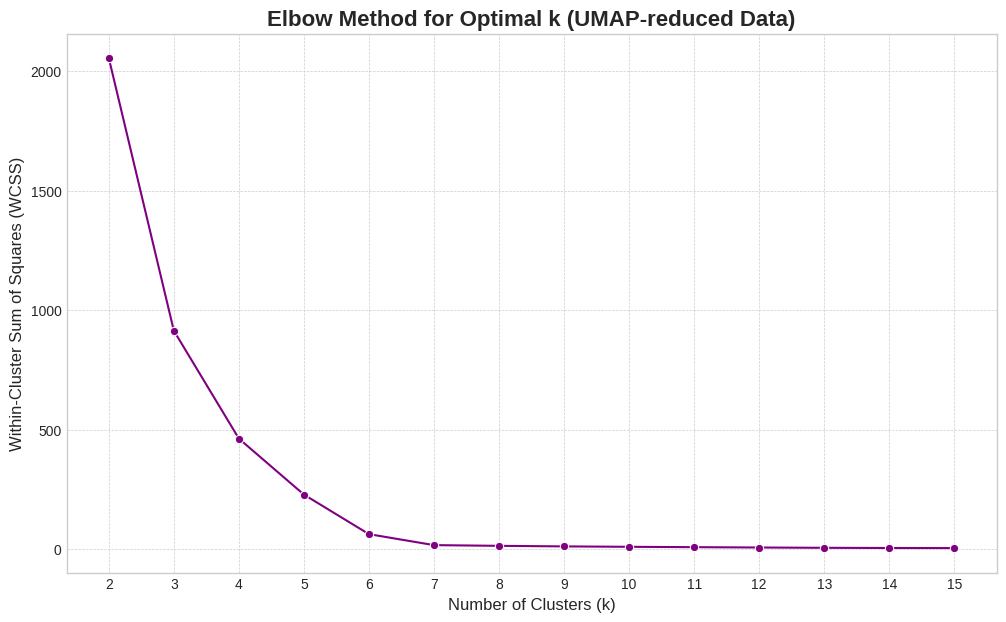

In [65]:
# ============================================================================
# K-MEANS CLUSTERING ON UMAP-REDUCED DATA - FINDING OPTIMAL K (ELBOW METHOD)
# ============================================================================

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("K-MEANS ON UMAP DATA: DETERMINING OPTIMAL NUMBER OF CLUSTERS")
print("="*80)

# Calculate inertia for a range of cluster numbers on the UMAP data
wcss_umap = [] # Within-Cluster Sum of Squares on UMAP data
k_range_umap = range(2, 16) # Testing from 2 to 15 clusters

for i in k_range_umap:
    kmeans_umap = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans_umap.fit(X_umap) # Fit on UMAP-reduced data
    wcss_umap.append(kmeans_umap.inertia_)
    print(f"✓ Calculated inertia for k={i} on UMAP data")

# Plot the Elbow Method graph for UMAP data
print("\n" + "="*80)
print("PLOTTING THE ELBOW METHOD GRAPH (UMAP DATA)")
print("="*80)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))
sns.lineplot(x=list(k_range_umap), y=wcss_umap, marker='o', color='purple')
plt.title('Elbow Method for Optimal k (UMAP-reduced Data)', fontsize=16, fontweight='bold')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.xticks(k_range_umap)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


#  **Clustering on UMAP-Reduced Data (Various Methods):**
    *   Applied K-Means, DBSCAN, Agglomerative, GMM, Affinity Propagation, Mean Shift, Spectral, Birch, and HDBSCAN clustering algorithms to the UMAP-reduced data.
    *   Determined the optimal number of clusters for K-Means using the Elbow Method.
    *   Tuned parameters for density-based methods (DBSCAN, HDBSCAN) using the K-distance plot.
    *   Visualized the clusters found by each method in the 2D UMAP space.
    *   Evaluated the performance of each clustering method using metrics like Silhouette, Calinski-Harabasz, and Davies-Bouldin scores.
    *   Insights:
        *   Different algorithms reveal different clustering structures in the data.
        *   Evaluation metrics provide objective measures for comparing the quality of the clusters found by each method.
        *   UMAP visualizations help in understanding the spatial separation and characteristics of the clusters.


In [66]:
# ============================================================================
#  K-MEANS CLUSTERING ON UMAP-REDUCED DATA
# ============================================================================
from sklearn.cluster import KMeans
import pandas as pd

print("="*80)
print("APPLYING K-MEANS CLUSTERING ON UMAP-REDUCED DATA")
print("="*80)
if 'optimal_k' not in locals():
    print("Warning: 'optimal_k' variable not found. Setting k to 5 as a default.")
    optimal_k = 5
else:
     print(f"Using optimal_k = {optimal_k} for K-Means on UMAP data.")


# Initialize and fit the K-Means model on UMAP-reduced data
kmeans_umap = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans_labels_umap = kmeans_umap.fit_predict(X_umap) # Fit and predict clusters on UMAP features

# Add the K-Means cluster labels (from UMAP data) to the df_clean DataFrame
df_clean['kmeans_cluster_umap'] = kmeans_labels_umap

print(f"✓ K-Means clustering completed on UMAP-reduced data with k = {optimal_k}.")

# Display the count of documents in each cluster
print("\n" + "="*80)
print("K-MEANS CLUSTER DISTRIBUTION (UMAP Data)")
print("="*80)
cluster_distribution_umap = df_clean['kmeans_cluster_umap'].value_counts().sort_index()
display(cluster_distribution_umap)

APPLYING K-MEANS CLUSTERING ON UMAP-REDUCED DATA
Using optimal_k = 5 for K-Means on UMAP data.
✓ K-Means clustering completed on UMAP-reduced data with k = 5.

K-MEANS CLUSTER DISTRIBUTION (UMAP Data)


kmeans_cluster_umap
0    17
1    23
2    10
3    17
4     8
Name: count, dtype: int64

# K-MEANS Clustering

VISUALIZING K-MEANS CLUSTERS ON UMAP-REDUCED DATA


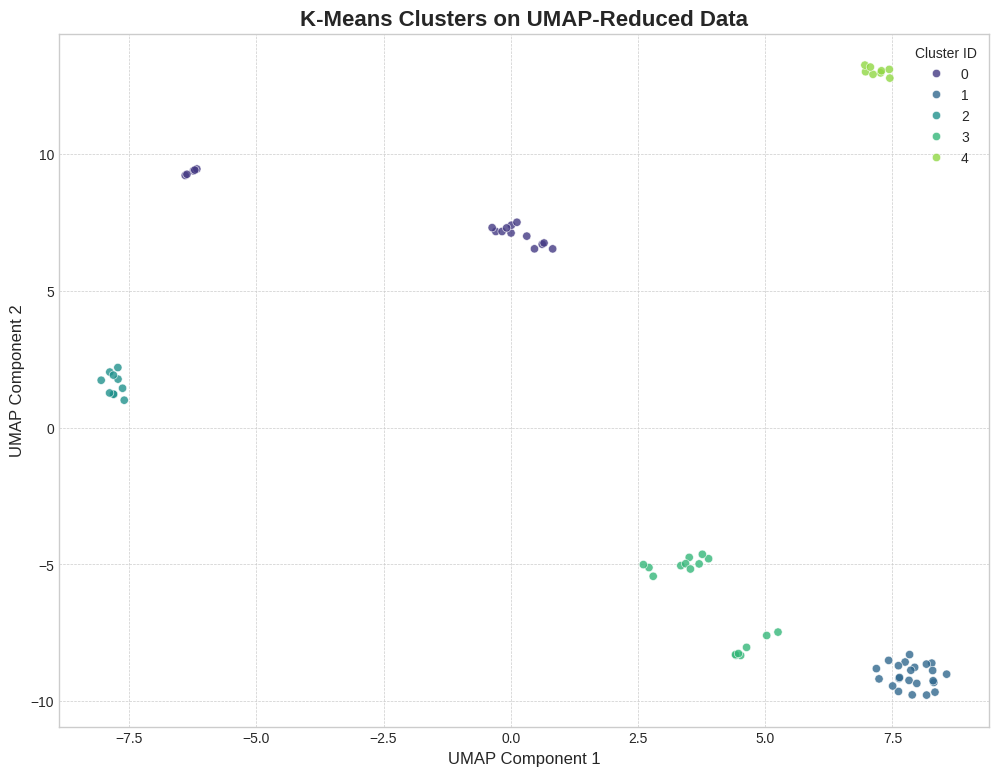

In [67]:
# ============================================================================
# VISUALIZE K-MEANS CLUSTERS ON UMAP-REDUCED DATA
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("="*80)
print("VISUALIZING K-MEANS CLUSTERS ON UMAP-REDUCED DATA")
print("="*80)

# Ensure X_umap (UMAP-reduced data) and kmeans_labels_umap (K-Means labels from UMAP data) are available
if 'X_umap' in locals() and 'kmeans_labels_umap' in locals():
    # Create a DataFrame for plotting
    df_umap_clusters = pd.DataFrame(data=X_umap, columns=['UMAP1', 'UMAP2'])
    df_umap_clusters['Cluster'] = kmeans_labels_umap

    # Plot the clusters in the 2D UMAP space
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 9))
    sns.scatterplot(
        x='UMAP1', y='UMAP2',
        hue='Cluster',
        palette=sns.color_palette("viridis", n_colors=len(df_umap_clusters['Cluster'].unique())), # Use a color palette based on the number of unique clusters
        data=df_umap_clusters,
        legend="full",
        alpha=0.8
    )

    plt.title('K-Means Clusters on UMAP-Reduced Data', fontsize=16, fontweight='bold')
    plt.xlabel('UMAP Component 1', fontsize=12)
    plt.ylabel('UMAP Component 2', fontsize=12)
    plt.legend(title='Cluster ID')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

else:
    print("Error: Required variables (X_umap or kmeans_labels_umap) not found. Please run previous cells.")

# AGGLOMERATIVE Clustering

In [68]:
# ============================================================================
# AGGLOMERATIVE CLUSTERING ON UMAP-REDUCED DATA
# ============================================================================
"""
Apply Agglomerative Clustering to the UMAP-reduced features.
"""
from sklearn.cluster import AgglomerativeClustering
import pandas as pd

print("="*80)
print("APPLYING AGGLOMERATIVE CLUSTERING ON UMAP-REDUCED DATA")
print("="*80)

# Ensure X_umap (UMAP-reduced data) is available
if 'X_umap' not in locals():
    print("Error: X_umap data not found. Please run the UMAP dimensionality reduction cell first.")
else:
    n_clusters_agg = 5 # Using 5 for consistency with K-Means, can be adjusted
    linkage = 'ward' # Common linkage for general purpose clustering

    print(f"Using Agglomerative Clustering on UMAP data with n_clusters={n_clusters_agg} and linkage='{linkage}'")

    agglomerative_umap = AgglomerativeClustering(n_clusters=n_clusters_agg, linkage=linkage)
    agg_labels_umap = agglomerative_umap.fit_predict(X_umap) # Fit and predict clusters on UMAP features

    # Add the Agglomerative cluster labels (from UMAP data) to the df_clean DataFrame
    df_clean['agg_cluster_umap'] = agg_labels_umap

    print(f"✓ Agglomerative Clustering completed on UMAP-reduced data with n_clusters = {n_clusters_agg}.")

    # Display the count of documents in each cluster
    print("\n" + "="*80)
    print("AGGLOMERATIVE CLUSTER DISTRIBUTION (UMAP Data)")
    print("="*80)
    cluster_distribution_agg_umap = df_clean['agg_cluster_umap'].value_counts().sort_index()
    display(cluster_distribution_agg_umap)

APPLYING AGGLOMERATIVE CLUSTERING ON UMAP-REDUCED DATA
Using Agglomerative Clustering on UMAP data with n_clusters=5 and linkage='ward'
✓ Agglomerative Clustering completed on UMAP-reduced data with n_clusters = 5.

AGGLOMERATIVE CLUSTER DISTRIBUTION (UMAP Data)


agg_cluster_umap
0    17
1    17
2     8
3    10
4    23
Name: count, dtype: int64

VISUALIZING AGGLOMERATIVE CLUSTERS ON UMAP-REDUCED DATA


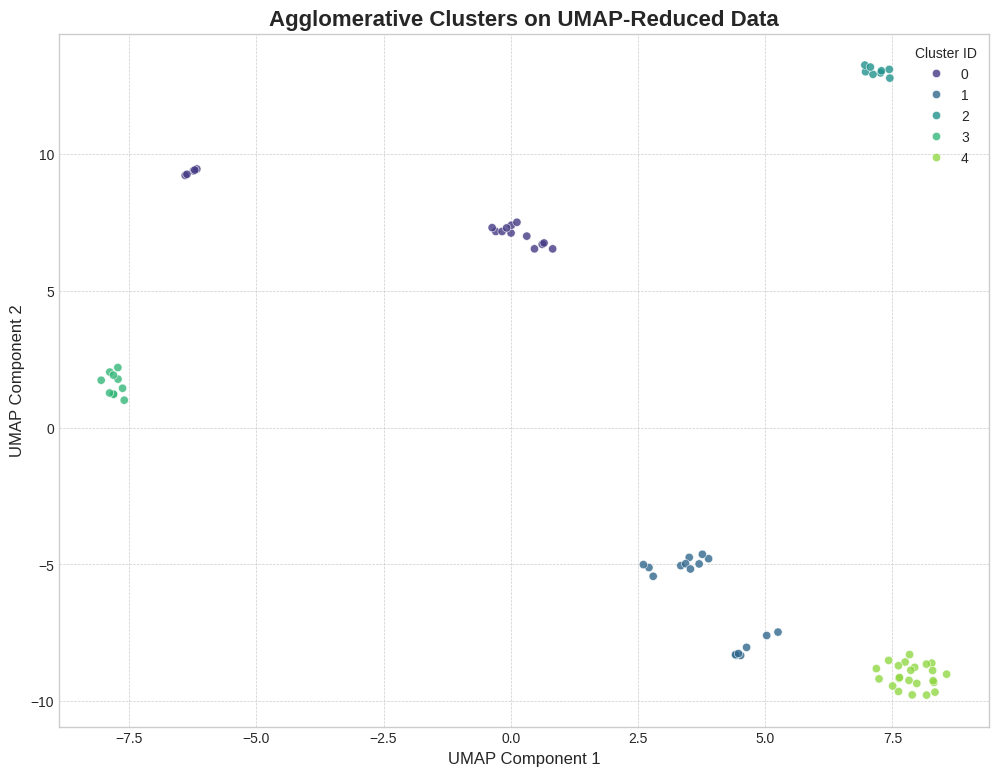

In [69]:
# ============================================================================
# VISUALIZE AGGLOMERATIVE CLUSTERS ON UMAP-REDUCED DATA
# ============================================================================
"""
Visualize the Agglomerative clusters in the 2D UMAP space.
"""
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("="*80)
print("VISUALIZING AGGLOMERATIVE CLUSTERS ON UMAP-REDUCED DATA")
print("="*80)

# Ensure X_umap (UMAP-reduced data) and agg_labels_umap (Agglomerative labels from UMAP data) are available
if 'X_umap' in locals() and 'agg_labels_umap' in locals():
    # Create a DataFrame for plotting
    df_umap_agg = pd.DataFrame(data=X_umap, columns=['UMAP1', 'UMAP2'])
    df_umap_agg['Cluster'] = agg_labels_umap # Use Agglomerative labels

    # Plot the clusters in the 2D UMAP space
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 9))
    sns.scatterplot(
        x='UMAP1', y='UMAP2',
        hue='Cluster',
        palette=sns.color_palette("viridis", n_colors=len(df_umap_agg['Cluster'].unique())), # Use a color palette based on the number of unique clusters
        data=df_umap_agg,
        legend="full",
        alpha=0.8
    )

    plt.title('Agglomerative Clusters on UMAP-Reduced Data', fontsize=16, fontweight='bold')
    plt.xlabel('UMAP Component 1', fontsize=12)
    plt.ylabel('UMAP Component 2', fontsize=12)
    plt.legend(title='Cluster ID')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
else:
    print("Error: Required variables (X_umap or agg_labels_umap) not found. Please run previous cells.")

# DBSCAN Clustering

STEP 1: CALCULATING K-DISTANCE PLOT TO FIND 'eps'
Calculating distances to the 5-th nearest neighbor...

 --> ACTION: Look at the plot.
 --> Find the 'knee' (the elbow) - the point where the curve
     bends and starts to rise sharply.
 --> The Y-axis value at this 'knee' is your new 'eps'.
     (It might be a value like 1.5, 2.8, etc.)

 --> Now, go to STEP 2 and update the 'eps' variable.


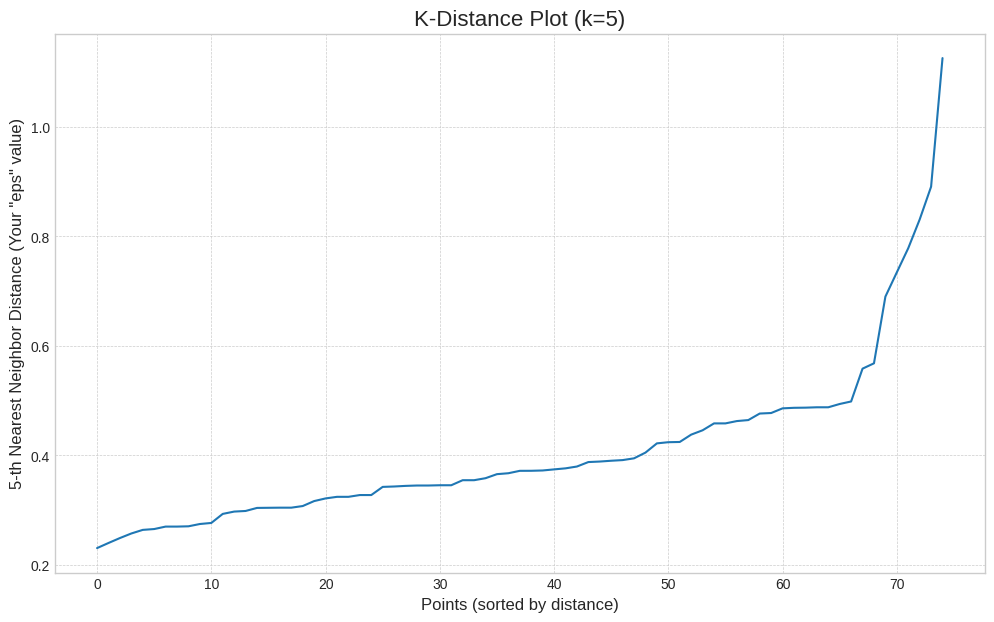

In [43]:
# ============================================================================
# STEP 1: FIND OPTIMAL EPSILON (eps) FOR DBSCAN
# ============================================================================

from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

print("="*80)
print("STEP 1: CALCULATING K-DISTANCE PLOT TO FIND 'eps'")
print("="*80)

# Ensure X_umap is available
if 'X_umap' not in locals():
    print("Error: X_umap data not found. Please run the UMAP cell first.")
else:
    # 'k' is usually set to your 'min_samples' value.
    # We will use k=5 since your min_samples was 5.
    k = 5
    print(f"Calculating distances to the {k}-th nearest neighbor...")

    # 1. Fit the NearestNeighbors model
    nbrs = NearestNeighbors(n_neighbors=k).fit(X_umap)

    # 2. Find the distances to the k-th neighbor for all points
    distances, indices = nbrs.kneighbors(X_umap)

    # 3. Get the k-th distance (the last column of 'distances') and sort it
    k_distances = np.sort(distances[:, k-1], axis=0)

    # 4. Create the plot
    plt.figure(figsize=(12, 7))
    plt.plot(k_distances)
    plt.title(f'K-Distance Plot (k={k})', fontsize=16)
    plt.xlabel('Points (sorted by distance)', fontsize=12)
    plt.ylabel(f'{k}-th Nearest Neighbor Distance (Your "eps" value)', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    print("\n" + "="*80)
    print(" --> ACTION: Look at the plot.")
    print(" --> Find the 'knee' (the elbow) - the point where the curve")
    print("     bends and starts to rise sharply.")
    print(" --> The Y-axis value at this 'knee' is your new 'eps'.")
    print("     (It might be a value like 1.5, 2.8, etc.)")
    print("\n --> Now, go to STEP 2 and update the 'eps' variable.")
    print("="*80)

    plt.show()

RUNNING COMPLETE DBSCAN PIPELINE

--- 1. APPLYING DBSCAN CLUSTERING ---
Using tuned parameters: eps=0.6, min_samples=5
✓ Clustering complete.
  Estimated number of clusters: 7
  Estimated number of noise points: 4

--- 2. VISUALIZING CLUSTERS ---


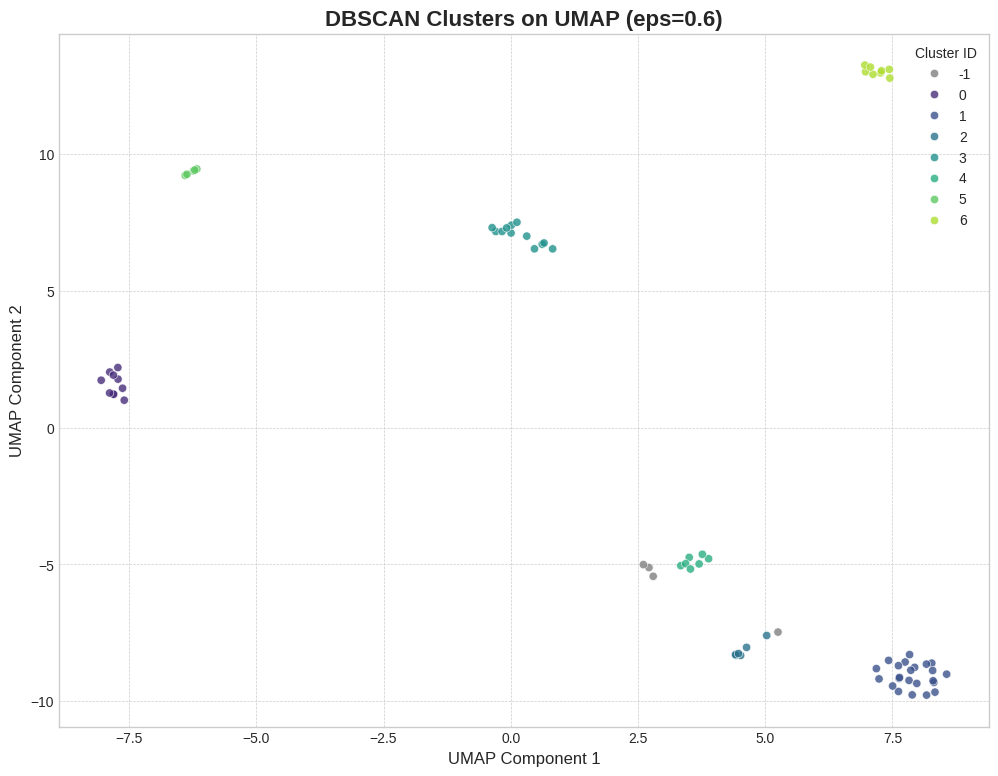

In [70]:
# ============================================================================
# COMPLETE DBSCAN PIPELINE (Cluster, Visualize, Evaluate)
# ===========================================================================

# --- 0. IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)

print("="*80)
print("RUNNING COMPLETE DBSCAN PIPELINE")
print("="*80)

# Ensure X_umap (UMAP-reduced data) is available
if 'X_umap' not in locals():
    print("Error: X_umap data not found. Please run the UMAP dimensionality reduction cell first.")
else:

    # ============================================================================
    # --- 1. APPLY DBSCAN CLUSTERING ---
    # ============================================================================
    print("\n--- 1. APPLYING DBSCAN CLUSTERING ---")

    # Use the optimal parameters you found
    eps = 0.6
    min_samples = 5

    print(f"Using tuned parameters: eps={eps}, min_samples={min_samples}")

    dbscan_umap = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels_umap = dbscan_umap.fit_predict(X_umap) # Fit and predict

    # Add the DBSCAN cluster labels to the df_clean DataFrame (if it exists)
    if 'df_clean' in locals():
        df_clean['dbscan_cluster_umap'] = dbscan_labels_umap
    else:
        print("Warning: 'df_clean' DataFrame not found. Labels will not be saved to it.")

    n_clusters_dbscan_umap = len(set(dbscan_labels_umap)) - (1 if -1 in dbscan_labels_umap else 0)
    n_noise_umap = list(dbscan_labels_umap).count(-1)

    print(f"✓ Clustering complete.")
    print(f"  Estimated number of clusters: {n_clusters_dbscan_umap}")
    print(f"  Estimated number of noise points: {n_noise_umap}")


    # ============================================================================
    # --- 2. VISUALIZE DBSCAN CLUSTERS ---
    # ============================================================================
    print("\n--- 2. VISUALIZING CLUSTERS ---")

    # Create a DataFrame for plotting
    df_umap_dbscan = pd.DataFrame(data=X_umap, columns=['UMAP1', 'UMAP2'])
    df_umap_dbscan['Cluster'] = dbscan_labels_umap # Use DBSCAN labels

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 9))

    # Create a color palette, ensuring noise points (-1) get a distinct color (e.g., gray)
    unique_labels = sorted(df_umap_dbscan['Cluster'].unique())
    colors = sns.color_palette("viridis", n_colors=len(unique_labels) - (1 if -1 in unique_labels else 0))
    if -1 in unique_labels:
        colors.insert(unique_labels.index(-1), 'gray') # Assign gray to noise

    sns.scatterplot(
        x='UMAP1', y='UMAP2',
        hue='Cluster',
        palette=colors, # Use the custom color palette
        data=df_umap_dbscan,
        legend="full",
        alpha=0.8
    )

    plt.title(f'DBSCAN Clusters on UMAP (eps={eps})', fontsize=16, fontweight='bold')
    plt.xlabel('UMAP Component 1', fontsize=12)
    plt.ylabel('UMAP Component 2', fontsize=12)
    plt.legend(title='Cluster ID')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# HDBSCAN  Clustering

RUNNING COMPLETE HDBSCAN PIPELINE

--- 1. APPLYING HDBSCAN CLUSTERING ---
Using parameters: min_cluster_size=5
✓ Clustering complete.
  Estimated number of clusters: 6
  Estimated number of noise points: 0

--- 2. VISUALIZING CLUSTERS ---


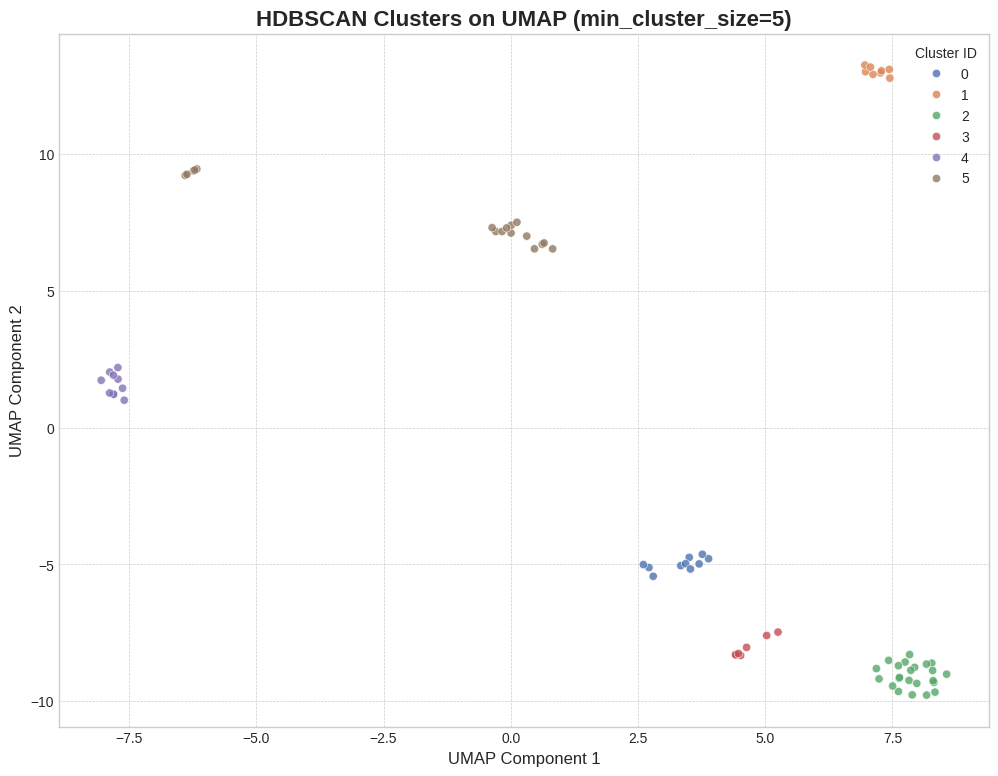

In [72]:
# ============================================================================
# COMPLETE HDBSCAN PIPELINE (Cluster, Visualize, Evaluate)
# ============================================================================
try:
    import hdbscan
except ImportError:
    print("="*80)
    print("ERROR: 'hdbscan' library not found.")
    print("!pip install hdbscan")
    print("="*80)
    # Stop execution if library is not found
    raise

# --- 0. IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)

print("="*80)
print("RUNNING COMPLETE HDBSCAN PIPELINE")
print("="*80)

# Ensure X_umap (UMAP-reduced data) is available
if 'X_umap' not in locals():
    print("Error: X_umap data not found. Please run the UMAP dimensionality reduction cell first.")
else:

    # ============================================================================
    # --- 1. APPLY HDBSCAN CLUSTERING ---
    # ============================================================================
    print("\n--- 1. APPLYING HDBSCAN CLUSTERING ---")

    # The main parameter to tune is 'min_cluster_size'.
    # We'll start with 5, which was a good 'min_samples' value for DBSCAN.
    min_cluster_size = 5

    print(f"Using parameters: min_cluster_size={min_cluster_size}")

    # Initialize the HDBSCAN model
    hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        gen_min_span_tree=True # Good for visualization later if needed
    )

    # Fit and predict clusters
    hdbscan_labels_umap = hdbscan_model.fit_predict(X_umap)

    # Add the HDBSCAN cluster labels to the df_clean DataFrame (if it exists)
    if 'df_clean' in locals():
        df_clean['hdbscan_cluster_umap'] = hdbscan_labels_umap
    else:
        print("Warning: 'df_clean' DataFrame not found. Labels will not be saved to it.")

    # HDBSCAN also uses -1 for noise
    n_clusters_hdbscan = len(set(hdbscan_labels_umap)) - (1 if -1 in hdbscan_labels_umap else 0)
    n_noise_hdbscan = list(hdbscan_labels_umap).count(-1)

    print(f"✓ Clustering complete.")
    print(f"  Estimated number of clusters: {n_clusters_hdbscan}")
    print(f"  Estimated number of noise points: {n_noise_hdbscan}")


    # ============================================================================
    # --- 2. VISUALIZE HDBSCAN CLUSTERS ---
    # ============================================================================
    print("\n--- 2. VISUALIZING CLUSTERS ---")

    # Create a DataFrame for plotting
    df_umap_hdbscan = pd.DataFrame(data=X_umap, columns=['UMAP1', 'UMAP2'])
    df_umap_hdbscan['Cluster'] = hdbscan_labels_umap # Use HDBSCAN labels

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 9))

    # Create a color palette, ensuring noise points (-1) get a distinct color (e.g., gray)
    unique_labels = sorted(df_umap_hdbscan['Cluster'].unique())
    colors = sns.color_palette("deep", n_colors=len(unique_labels) - (1 if -1 in unique_labels else 0))
    if -1 in unique_labels:
        colors.insert(unique_labels.index(-1), 'gray') # Assign gray to noise

    sns.scatterplot(
        x='UMAP1', y='UMAP2',
        hue='Cluster',
        palette=colors,
        data=df_umap_hdbscan,
        legend="full",
        alpha=0.8
    )

    plt.title(f'HDBSCAN Clusters on UMAP (min_cluster_size={min_cluster_size})', fontsize=16, fontweight='bold')
    plt.xlabel('UMAP Component 1', fontsize=12)
    plt.ylabel('UMAP Component 2', fontsize=12)
    plt.legend(title='Cluster ID')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

#AFFINITY PROPAGATION Clustering

In [71]:
# ============================================================================
# AFFINITY PROPAGATION CLUSTERING ON UMAP-REDUCED DATA
# ============================================================================
from sklearn.cluster import AffinityPropagation
import pandas as pd

print("="*80)
print("APPLYING AFFINITY PROPAGATION CLUSTERING ON UMAP-REDUCED DATA")
print("="*80)

# Ensure X_umap (UMAP-reduced data) is available
if 'X_umap' not in locals():
    print("Error: X_umap data not found. Please run the UMAP dimensionality reduction cell first.")
else:
    damping = 0.9 # Example value (default is 0.5), range [0.5, 1.0)
    # preference = -50 # Example: Uncomment and set to control the number of clusters

    print(f"Using Affinity Propagation on UMAP data with damping={damping}")

    affinity_prop_umap = AffinityPropagation(damping=damping, random_state=42)

    # Fit and predict clusters on UMAP features
    affinity_labels_umap = affinity_prop_umap.fit_predict(X_umap)

    # Add the Affinity Propagation cluster labels (from UMAP data) to the df_clean DataFrame
    df_clean['affinity_cluster_umap'] = affinity_labels_umap

    # Get the cluster centers (exemplars) found by the algorithm
    cluster_centers_indices = affinity_prop_umap.cluster_centers_indices_
    n_clusters_affinity_umap = len(cluster_centers_indices) if cluster_centers_indices is not None else 0

    print(f"✓ Affinity Propagation clustering completed on UMAP-reduced data.")
    print(f"  Estimated number of clusters: {n_clusters_affinity_umap}")

    # Display the count of documents in each cluster
    print("\n" + "="*80)
    print("AFFINITY PROPAGATION CLUSTER DISTRIBUTION (UMAP Data)")
    print("="*80)
    cluster_distribution_affinity_umap = df_clean['affinity_cluster_umap'].value_counts().sort_index()
    display(cluster_distribution_affinity_umap)


APPLYING AFFINITY PROPAGATION CLUSTERING ON UMAP-REDUCED DATA
Using Affinity Propagation on UMAP data with damping=0.9
✓ Affinity Propagation clustering completed on UMAP-reduced data.
  Estimated number of clusters: 6

AFFINITY PROPAGATION CLUSTER DISTRIBUTION (UMAP Data)


affinity_cluster_umap
0    10
1    10
2     5
3    12
4     8
5    30
Name: count, dtype: int64

VISUALIZING AFFINITY PROPAGATION CLUSTERS ON UMAP-REDUCED DATA


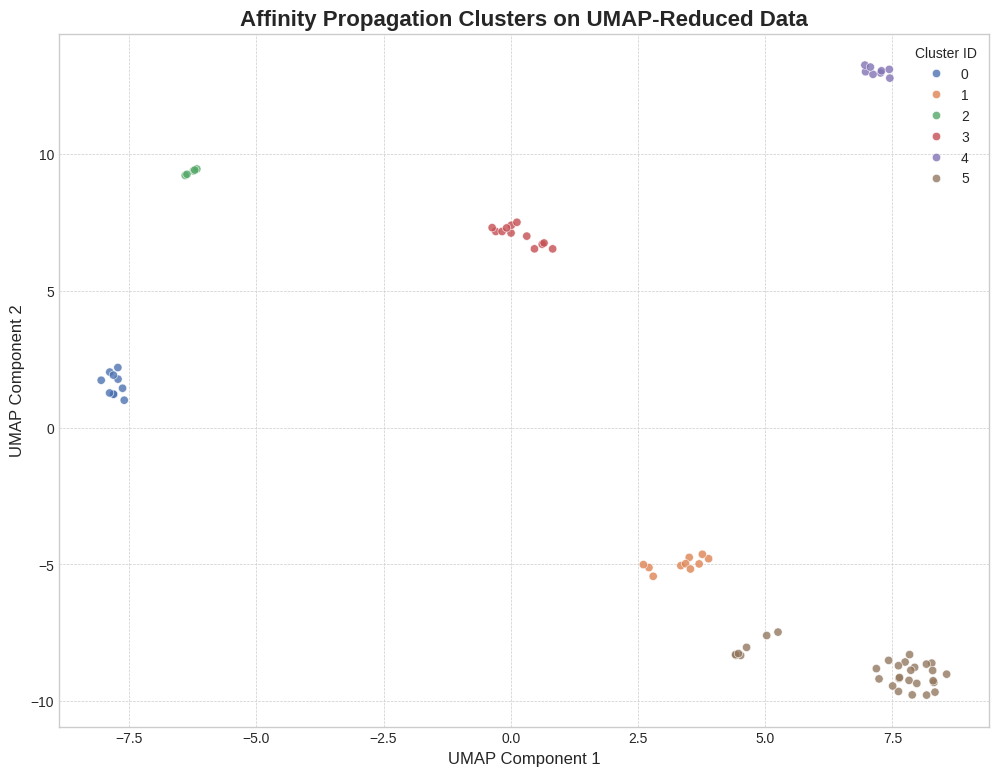

In [73]:
# ============================================================================
# VISUALIZE AFFINITY PROPAGATION CLUSTERS ON UMAP-REDUCED DATA
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("="*80)
print("VISUALIZING AFFINITY PROPAGATION CLUSTERS ON UMAP-REDUCED DATA")
print("="*80)

# Ensure X_umap and affinity_labels_umap (Affinity Propagation labels from UMAP data) are available
if 'X_umap' in locals() and 'affinity_labels_umap' in locals():
    # Create a DataFrame for plotting
    df_umap_affinity = pd.DataFrame(data=X_umap, columns=['UMAP1', 'UMAP2'])
    df_umap_affinity['Cluster'] = affinity_labels_umap # Use Affinity Propagation labels

    # Plot the clusters in the 2D UMAP space
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 9))

    # Create a color palette for the clusters.
    # Affinity Propagation assigns all points to a cluster, so no noise (-1) handling is needed.
    unique_labels = sorted(df_umap_affinity['Cluster'].unique())
    n_clusters = len(unique_labels)

    # Use a qualitative palette (like 'deep', 'tab10', or 'bright') for distinct clusters
    colors = sns.color_palette("deep", n_colors=n_clusters)

    sns.scatterplot(
        x='UMAP1', y='UMAP2',
        hue='Cluster',
        palette=colors, # Use the custom color palette
        data=df_umap_affinity,
        legend="full",
        alpha=0.8
    )

    plt.title('Affinity Propagation Clusters on UMAP-Reduced Data', fontsize=16, fontweight='bold')
    plt.xlabel('UMAP Component 1', fontsize=12)
    plt.ylabel('UMAP Component 2', fontsize=12)
    plt.legend(title='Cluster ID')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
else:
    print("Error: Required variables (X_umap or affinity_labels_umap) not found. Please run previous cells.")

# GAUSSIAN MIXTURE MODEL (GMM) Clustering

In [74]:
# ============================================================================
# GAUSSIAN MIXTURE MODEL (GMM) CLUSTERING ON UMAP-REDUCED DATA
# ============================================================================
"""
Apply GMM (Gaussian Mixture Models) clustering to the UMAP-reduced features.
"""
from sklearn.mixture import GaussianMixture
import pandas as pd

print("="*80)
print("APPLYING GMM CLUSTERING ON UMAP-REDUCED DATA")
print("="*80)

# Ensure X_umap (UMAP-reduced data) is available
if 'X_umap' not in locals():
    print("Error: X_umap data not found. Please run the UMAP dimensionality reduction cell first.")
else:
    n_components_gmm = 5

    print(f"Using GMM on UMAP data with n_components={n_components_gmm} (from Elbow Plot)")

    gmm_umap = GaussianMixture(n_components=n_components_gmm, random_state=42)

    gmm_labels_umap = gmm_umap.fit_predict(X_umap)

    # Add the GMM cluster labels (from UMAP data) to the df_clean DataFrame
    df_clean['gmm_cluster_umap'] = gmm_labels_umap

    # The number of clusters is what we defined in n_components
    n_clusters_gmm = n_components_gmm

    print(f"✓ GMM clustering completed on UMAP-reduced data.")
    print(f"  Number of clusters (n_components): {n_clusters_gmm}")

    # Display the count of documents in each cluster
    print("\n" + "="*80)
    print("GMM CLUSTER DISTRIBUTION (UMAP Data)")
    print("="*80)
    cluster_distribution_gmm_umap = df_clean['gmm_cluster_umap'].value_counts().sort_index()
    display(cluster_distribution_gmm_umap)

APPLYING GMM CLUSTERING ON UMAP-REDUCED DATA
Using GMM on UMAP data with n_components=5 (from Elbow Plot)
✓ GMM clustering completed on UMAP-reduced data.
  Number of clusters (n_components): 5

GMM CLUSTER DISTRIBUTION (UMAP Data)


gmm_cluster_umap
0    17
1    23
2    10
3    17
4     8
Name: count, dtype: int64

VISUALIZING GMM CLUSTERS ON UMAP-REDUCED DATA


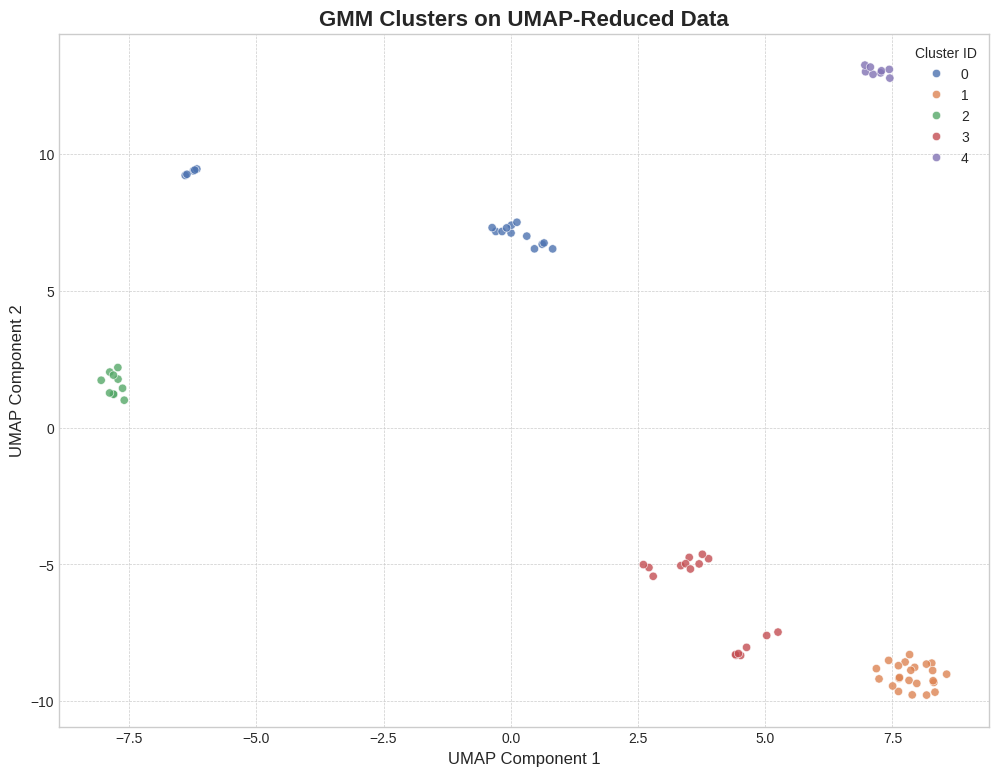

In [75]:
# ============================================================================
# VISUALIZE GMM CLUSTERS ON UMAP-REDUCED DATA
# ============================================================================
"""
Visualize the GMM clusters in the 2D UMAP space.
"""
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("="*80)
print("VISUALIZING GMM CLUSTERS ON UMAP-REDUCED DATA")
print("="*80)

# Ensure X_umap and gmm_labels_umap (GMM labels from UMAP data) are available
if 'X_umap' in locals() and 'gmm_labels_umap' in locals():
    # Create a DataFrame for plotting
    df_umap_gmm = pd.DataFrame(data=X_umap, columns=['UMAP1', 'UMAP2'])
    df_umap_gmm['Cluster'] = gmm_labels_umap # Use GMM labels

    # Plot the clusters in the 2D UMAP space
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 9))

    # Create a color palette for the clusters.
    # GMM assigns all points to a cluster, so no noise (-1) handling is needed.
    unique_labels = sorted(df_umap_gmm['Cluster'].unique())
    n_clusters = len(unique_labels)

    colors = sns.color_palette("deep", n_colors=n_clusters)

    sns.scatterplot(
        x='UMAP1', y='UMAP2',
        hue='Cluster',
        palette=colors, # Use the custom color palette
        data=df_umap_gmm,
        legend="full",
        alpha=0.8
    )

    plt.title('GMM Clusters on UMAP-Reduced Data', fontsize=16, fontweight='bold')
    plt.xlabel('UMAP Component 1', fontsize=12)
    plt.ylabel('UMAP Component 2', fontsize=12)
    plt.legend(title='Cluster ID')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
else:
    print("Error: Required variables (X_umap or gmm_labels_umap) not found. Please run previous cells.")

# BIRCH Clustering

In [76]:
# ============================================================================
# BIRCH CLUSTERING ON UMAP-REDUCED DATA
# ============================================================================
from sklearn.cluster import Birch
import pandas as pd

print("="*80)
print("APPLYING BIRCH CLUSTERING ON UMAP-REDUCED DATA")
print("="*80)

# Ensure X_umap (UMAP-reduced data) is available
if 'X_umap' not in locals():
    print("Error: X_umap data not found. Please run the UMAP dimensionality reduction cell first.")
else:
    n_clusters_birch = None # Let Birch estimate the number of clusters, or set a value (e.g., 5)
    threshold_birch = 0.5 # Example value, tune this
    branching_factor_birch = 50 # Example value, tune this

    if n_clusters_birch is not None:
        print(f"Using Birch on UMAP data with n_clusters={n_clusters_birch}, threshold={threshold_birch}, branching_factor={branching_factor_birch}")
        birch_umap = Birch(n_clusters=n_clusters_birch, threshold=threshold_birch, branching_factor=branching_factor_birch)
    else:
        print(f"Using Birch on UMAP data, automatically determining n_clusters with threshold={threshold_birch}, branching_factor={branching_factor_birch}")
        birch_umap = Birch(threshold=threshold_birch, branching_factor=branching_factor_birch)


    # Fit and predict clusters on UMAP features
    birch_labels_umap = birch_umap.fit_predict(X_umap)

    # Add the Birch cluster labels (from UMAP data) to the df_clean DataFrame
    df_clean['birch_cluster_umap'] = birch_labels_umap

    # Get the number of clusters found by Birch
    n_clusters_birch_found = len(set(birch_labels_umap))

    print(f"✓ Birch clustering completed on UMAP-reduced data.")
    print(f"  Estimated number of clusters found by Birch: {n_clusters_birch_found}")


    # Display the count of documents in each cluster
    print("\n" + "="*80)
    print("BIRCH CLUSTER DISTRIBUTION (UMAP Data)")
    print("="*80)
    cluster_distribution_birch_umap = df_clean['birch_cluster_umap'].value_counts().sort_index()
    display(cluster_distribution_birch_umap)

APPLYING BIRCH CLUSTERING ON UMAP-REDUCED DATA
Using Birch on UMAP data, automatically determining n_clusters with threshold=0.5, branching_factor=50
✓ Birch clustering completed on UMAP-reduced data.
  Estimated number of clusters found by Birch: 3

BIRCH CLUSTER DISTRIBUTION (UMAP Data)


birch_cluster_umap
0    27
1    40
2     8
Name: count, dtype: int64

VISUALIZING BIRCH CLUSTERS ON UMAP-REDUCED DATA


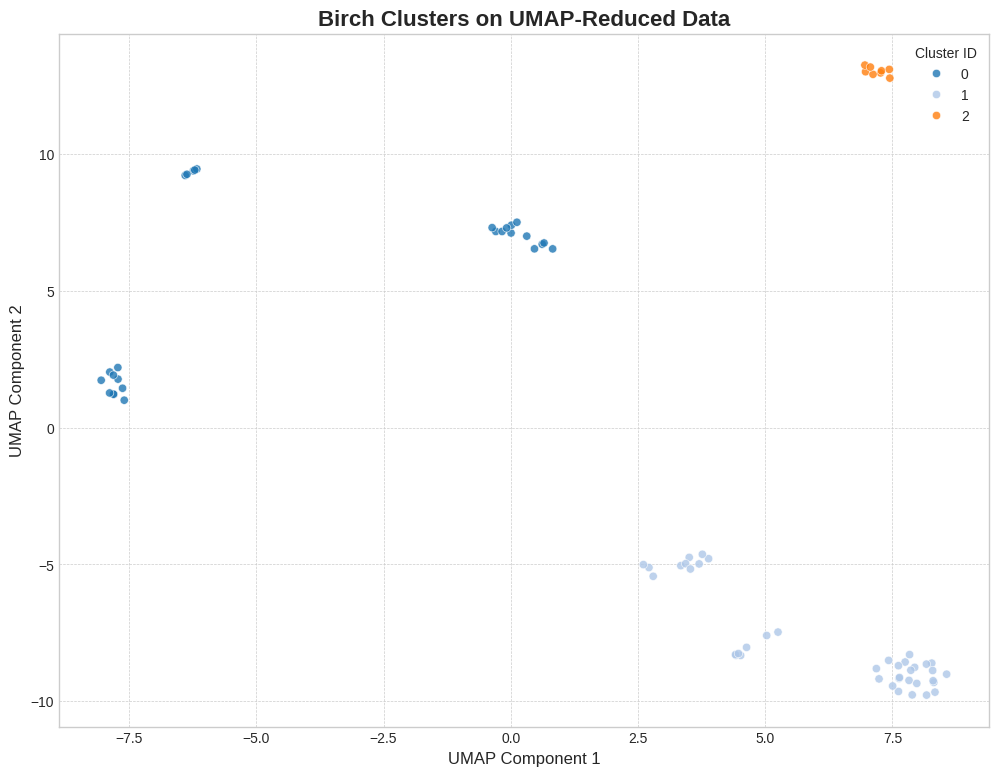

In [77]:
# ============================================================================
# VISUALIZE BIRCH CLUSTERS ON UMAP-REDUCED DATA
# ============================================================================
"""
Visualize the Birch clusters in the 2D UMAP space.
"""
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("="*80)
print("VISUALIZING BIRCH CLUSTERS ON UMAP-REDUCED DATA")
print("="*80)

# Ensure X_umap and birch_labels_umap (Birch labels from UMAP data) are available
if 'X_umap' in locals() and 'birch_labels_umap' in locals():
    # Create a DataFrame for plotting
    df_umap_birch = pd.DataFrame(data=X_umap, columns=['UMAP1', 'UMAP2'])
    df_umap_birch['Cluster'] = birch_labels_umap # Use Birch labels

    # Plot the clusters in the 2D UMAP space
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 9))

    # Create a color palette for the clusters.
    unique_labels = sorted(df_umap_birch['Cluster'].unique())
    n_clusters = len(unique_labels)

    colors = sns.color_palette("tab20", n_colors=n_clusters) # Use a palette suitable for potentially more clusters

    sns.scatterplot(
        x='UMAP1', y='UMAP2',
        hue='Cluster',
        palette=colors, # Use the custom color palette
        data=df_umap_birch,
        legend="full",
        alpha=0.8
    )

    plt.title('Birch Clusters on UMAP-Reduced Data', fontsize=16, fontweight='bold')
    plt.xlabel('UMAP Component 1', fontsize=12)
    plt.ylabel('UMAP Component 2', fontsize=12)
    plt.legend(title='Cluster ID')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

else:
    print("Error: Required variables (X_umap or birch_labels_umap) not found. Please run previous cells.")

# OPTICS Clustering

In [78]:
# ============================================================================
# OPTICS CLUSTERING ON UMAP-REDUCED DATA
# ============================================================================
"""
Apply OPTICS (Ordering Points To Identify the Clustering Structure) clustering
to the UMAP-reduced features.
"""
from sklearn.cluster import OPTICS
import pandas as pd
import numpy as np # Import numpy for inf

print("="*80)
print("APPLYING OPTICS CLUSTERING ON UMAP-REDUCED DATA")
print("="*80)

# Ensure X_umap (UMAP-reduced data) is available
if 'X_umap' not in locals():
    print("Error: X_umap data not found. Please run the UMAP dimensionality reduction cell first.")
else:
    min_samples_optics = 5 # Example value, tune this
    max_eps_optics = np.inf # Example value, tune this

    print(f"Using OPTICS on UMAP data with min_samples={min_samples_optics} and max_eps={max_eps_optics}")

    # Note: OPTICS can be computationally intensive for large datasets.
    optics_umap = OPTICS(min_samples=min_samples_optics, max_eps=max_eps_optics)

    # Fit the model
    optics_umap.fit(X_umap)

    optics_labels_umap = optics_umap.labels_

    # Add the OPTICS cluster labels (from UMAP data) to the df_clean DataFrame
    df_clean['optics_cluster_umap'] = optics_labels_umap

    # OPTICS labels -1 indicate noise points (outliers)
    n_clusters_optics_umap = len(set(optics_labels_umap)) - (1 if -1 in optics_labels_umap else 0)
    n_noise_umap_optics = list(optics_labels_umap).count(-1)

    print(f"✓ OPTICS clustering completed on UMAP-reduced data.")
    print(f" Estimated number of clusters: {n_clusters_optics_umap}")
    print(f" Estimated number of noise points: {n_noise_umap_optics}")


    # Display the count of documents in each cluster (including noise)
    print("\n" + "="*80)
    print("OPTICS CLUSTER DISTRIBUTION (UMAP Data - INCLUDING NOISE)")
    print("="*80)
    cluster_distribution_optics_umap = df_clean['optics_cluster_umap'].value_counts().sort_index()
    display(cluster_distribution_optics_umap)

APPLYING OPTICS CLUSTERING ON UMAP-REDUCED DATA
Using OPTICS on UMAP data with min_samples=5 and max_eps=inf
✓ OPTICS clustering completed on UMAP-reduced data.
 Estimated number of clusters: 7
 Estimated number of noise points: 20

OPTICS CLUSTER DISTRIBUTION (UMAP Data - INCLUDING NOISE)


optics_cluster_umap
-1    20
 0     6
 1     5
 2     8
 3     8
 4    10
 5     7
 6    11
Name: count, dtype: int64

VISUALIZING OPTICS CLUSTERS ON UMAP-REDUCED DATA


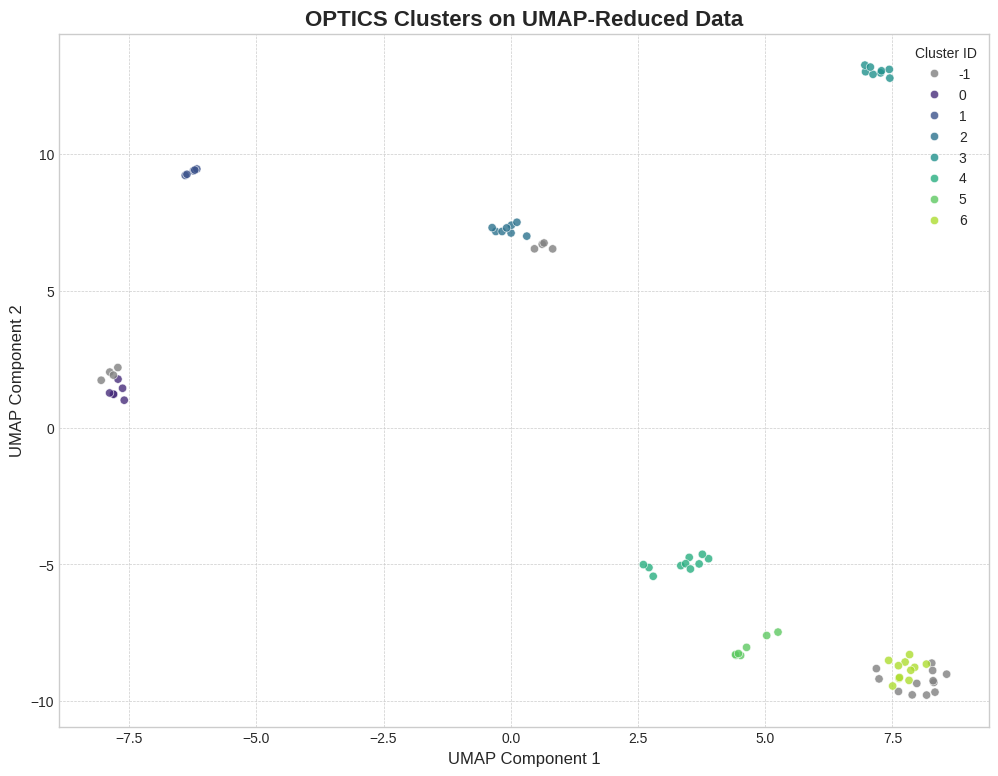

In [79]:
# ============================================================================
# VISUALIZE OPTICS CLUSTERS ON UMAP-REDUCED DATA
# ============================================================================
"""
Visualize the OPTICS clusters in the 2D UMAP space, including noise points.
"""
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("="*80)
print("VISUALIZING OPTICS CLUSTERS ON UMAP-REDUCED DATA")
print("="*80)

# Ensure X_umap and optics_labels_umap (OPTICS labels from UMAP data) are available
if 'X_umap' in locals() and 'optics_labels_umap' in locals():
    # Create a DataFrame for plotting
    df_umap_optics = pd.DataFrame(data=X_umap, columns=['UMAP1', 'UMAP2'])
    df_umap_optics['Cluster'] = optics_labels_umap # Use OPTICS labels

    # Plot the clusters in the 2D UMAP space
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 9))

    # Create a color palette, ensuring noise points (-1) get a distinct color (e.g., black or gray)
    unique_labels = sorted(df_umap_optics['Cluster'].unique())
    colors = sns.color_palette("viridis", n_colors=len(unique_labels) - (1 if -1 in unique_labels else 0))
    if -1 in unique_labels:
        colors.insert(unique_labels.index(-1), 'gray') # Assign gray to noise

    sns.scatterplot(
        x='UMAP1', y='UMAP2',
        hue='Cluster',
        palette=colors, # Use the custom color palette
        data=df_umap_optics,
        legend="full",
        alpha=0.8
    )

    plt.title('OPTICS Clusters on UMAP-Reduced Data', fontsize=16, fontweight='bold')
    plt.xlabel('UMAP Component 1', fontsize=12)
    plt.ylabel('UMAP Component 2', fontsize=12)
    plt.legend(title='Cluster ID')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

else:
    print("Error: Required variables (X_umap or optics_labels_umap) not found. Please run previous cells.")

# SPECTRAL Clustering

In [80]:
# ============================================================================
# SPECTRAL CLUSTERING ON UMAP-REDUCED DATA
# ============================================================================
"""
Apply Spectral Clustering to the UMAP-reduced features.
"""
from sklearn.cluster import SpectralClustering
import pandas as pd

print("="*80)
print("APPLYING SPECTRAL CLUSTERING ON UMAP-REDUCED DATA")
print("="*80)

# Ensure X_umap (UMAP-reduced data) is available
if 'X_umap' not in locals():
    print("Error: X_umap data not found. Please run the UMAP dimensionality reduction cell first.")
else:

    n_clusters_spectral = 5 # Using 5 for consistency with K-Means, can be adjusted

    print(f"Using Spectral Clustering on UMAP data with n_clusters={n_clusters_spectral}")

    # Using 'kmeans' for assign_labels is common after spectral embedding
    spectral_umap = SpectralClustering(n_clusters=n_clusters_spectral, assign_labels='kmeans', random_state=42)


    spectral_labels_umap = spectral_umap.fit_predict(X_umap)

    # Add the Spectral cluster labels (from UMAP data) to the df_clean DataFrame
    df_clean['spectral_cluster_umap'] = spectral_labels_umap

    print(f"✓ Spectral Clustering completed on UMAP-reduced data with n_clusters = {n_clusters_spectral}.")

    # Display the count of documents in each cluster
    print("\n" + "="*80)
    print("SPECTRAL CLUSTER DISTRIBUTION (UMAP Data)")
    print("="*80)
    cluster_distribution_spectral_umap = df_clean['spectral_cluster_umap'].value_counts().sort_index()
    display(cluster_distribution_spectral_umap)

APPLYING SPECTRAL CLUSTERING ON UMAP-REDUCED DATA
Using Spectral Clustering on UMAP data with n_clusters=5
✓ Spectral Clustering completed on UMAP-reduced data with n_clusters = 5.

SPECTRAL CLUSTER DISTRIBUTION (UMAP Data)


spectral_cluster_umap
0    33
1     5
2     7
3    10
4    20
Name: count, dtype: int64

VISUALIZING SPECTRAL CLUSTERS ON UMAP-REDUCED DATA


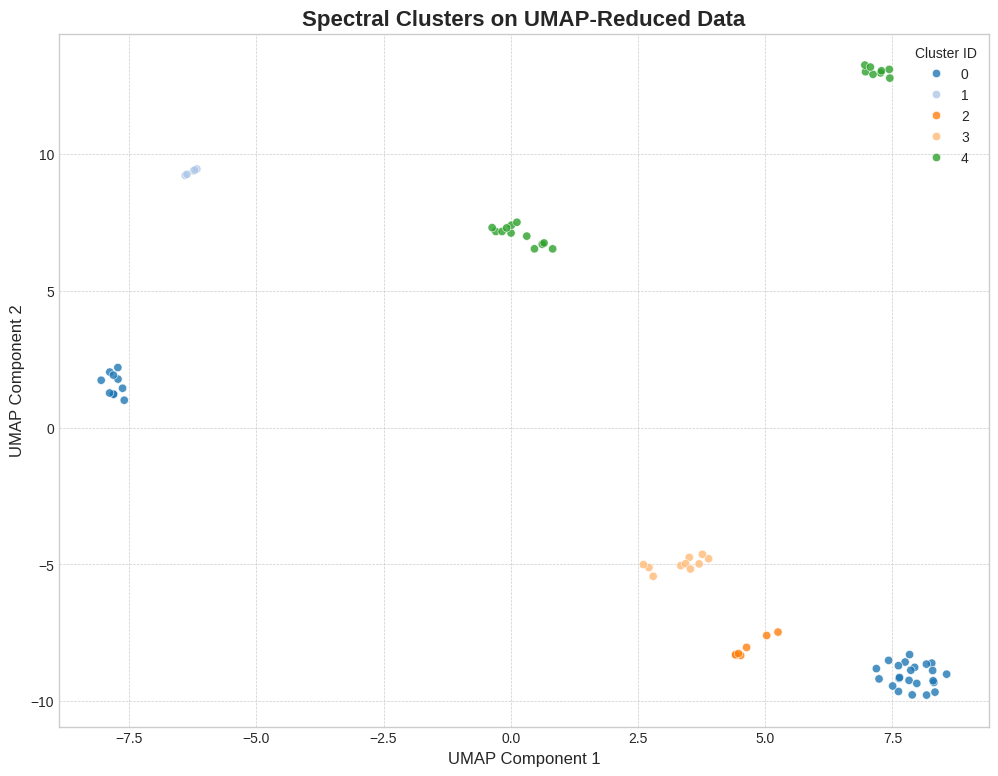

In [81]:
# ============================================================================
# VISUALIZE SPECTRAL CLUSTERS ON UMAP-REDUCED DATA
# ============================================================================
"""
Visualize the Spectral clusters in the 2D UMAP space.
"""
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("="*80)
print("VISUALIZING SPECTRAL CLUSTERS ON UMAP-REDUCED DATA")
print("="*80)

# Ensure X_umap and spectral_labels_umap (Spectral labels from UMAP data) are available
if 'X_umap' in locals() and 'spectral_labels_umap' in locals():
    # Create a DataFrame for plotting
    df_umap_spectral = pd.DataFrame(data=X_umap, columns=['UMAP1', 'UMAP2'])
    df_umap_spectral['Cluster'] = spectral_labels_umap # Use Spectral labels

    # Plot the clusters in the 2D UMAP space
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 9))

    # Create a color palette for the clusters.
    unique_labels = sorted(df_umap_spectral['Cluster'].unique())
    n_clusters = len(unique_labels)

    colors = sns.color_palette("tab20", n_colors=n_clusters) # Use a palette suitable for more clusters

    sns.scatterplot(
        x='UMAP1', y='UMAP2',
        hue='Cluster',
        palette=colors, # Use the custom color palette
        data=df_umap_spectral,
        legend="full",
        alpha=0.8
    )

    plt.title('Spectral Clusters on UMAP-Reduced Data', fontsize=16, fontweight='bold')
    plt.xlabel('UMAP Component 1', fontsize=12)
    plt.ylabel('UMAP Component 2', fontsize=12)
    plt.legend(title='Cluster ID')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

else:
    print("Error: Required variables (X_umap or spectral_labels_umap) not found. Please run previous cells.")

# MEAN SHIFT  Clustering

In [82]:
# ============================================================================
# MEAN SHIFT CLUSTERING ON UMAP-REDUCED DATA
# ============================================================================

from sklearn.cluster import MeanShift, estimate_bandwidth
import pandas as pd
import numpy as np

print("="*80)
print("APPLYING MEAN SHIFT CLUSTERING ON UMAP-REDUCED DATA")
print("="*80)

# Ensure X_umap (UMAP-reduced data) is available
if 'X_umap' not in locals():
    print("Error: X_umap data not found. Please run the UMAP dimensionality reduction cell first.")
else:
    try:
        bandwidth = estimate_bandwidth(X_umap, quantile=0.2, n_samples=500) # Adjust quantile as needed
        print(f"Estimated bandwidth: {bandwidth:.4f}")
    except Exception as e:
        print(f"Could not estimate bandwidth: {e}. Setting a default value.")
        bandwidth = 1.0 # Set a default if estimation fails or data is too small



    if bandwidth is not None:
        mean_shift_umap = MeanShift(bandwidth=bandwidth, cluster_all=True) # cluster_all=True to avoid noise labels
        print(f"Using Mean Shift on UMAP data with bandwidth={bandwidth:.4f}")
    else:
        mean_shift_umap = MeanShift(cluster_all=True) # Let the algorithm estimate bandwidth
        print("Using Mean Shift on UMAP data, bandwidth will be estimated.")


    # Fit and predict clusters on UMAP features
    mean_shift_labels_umap = mean_shift_umap.fit_predict(X_umap)

    # Add the Mean Shift cluster labels (from UMAP data) to the df_clean DataFrame
    df_clean['meanshift_cluster_umap'] = mean_shift_labels_umap

    # Get the number of clusters found
    cluster_centers = mean_shift_umap.cluster_centers_
    n_clusters_meanshift_umap = len(cluster_centers)

    print(f"✓ Mean Shift clustering completed on UMAP-reduced data.")
    print(f"  Estimated number of clusters: {n_clusters_meanshift_umap}")

    # Display the count of documents in each cluster
    print("\n" + "="*80)
    print("MEAN SHIFT CLUSTER DISTRIBUTION (UMAP Data)")
    print("="*80)
    cluster_distribution_meanshift_umap = df_clean['meanshift_cluster_umap'].value_counts().sort_index()
    display(cluster_distribution_meanshift_umap)

APPLYING MEAN SHIFT CLUSTERING ON UMAP-REDUCED DATA
Estimated bandwidth: 4.6612
Using Mean Shift on UMAP data with bandwidth=4.6612
✓ Mean Shift clustering completed on UMAP-reduced data.
  Estimated number of clusters: 5

MEAN SHIFT CLUSTER DISTRIBUTION (UMAP Data)


meanshift_cluster_umap
0    40
1    12
2    10
3     8
4     5
Name: count, dtype: int64

VISUALIZING MEAN SHIFT CLUSTERS ON UMAP-REDUCED DATA


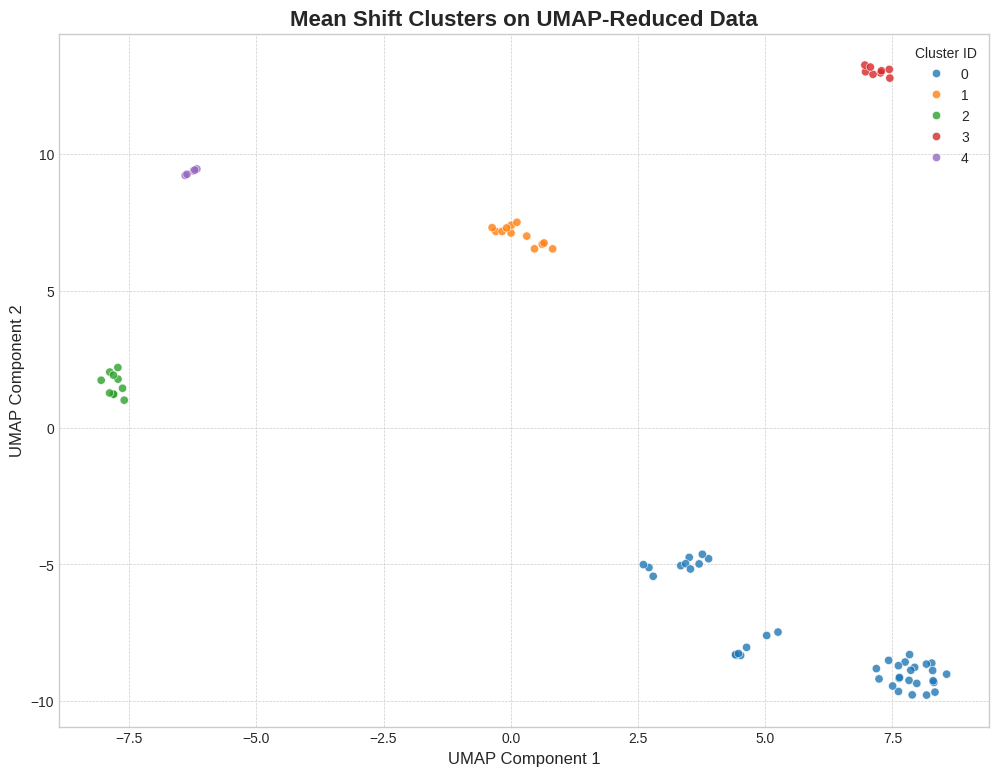

In [83]:
# ============================================================================
# VISUALIZE MEAN SHIFT CLUSTERS ON UMAP-REDUCED DATA
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("="*80)
print("VISUALIZING MEAN SHIFT CLUSTERS ON UMAP-REDUCED DATA")
print("="*80)

# Ensure X_umap and mean_shift_labels_umap (Mean Shift labels from UMAP data) are available
if 'X_umap' in locals() and 'mean_shift_labels_umap' in locals():
    # Create a DataFrame for plotting
    df_umap_meanshift = pd.DataFrame(data=X_umap, columns=['UMAP1', 'UMAP2'])
    df_umap_meanshift['Cluster'] = mean_shift_labels_umap # Use Mean Shift labels

    # Plot the clusters in the 2D UMAP space
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 9))

    # Create a color palette for the clusters.
    unique_labels = sorted(df_umap_meanshift['Cluster'].unique())
    n_clusters = len(unique_labels)

    # Use a qualitative palette for distinct clusters
    colors = sns.color_palette("tab10", n_colors=n_clusters)


    sns.scatterplot(
        x='UMAP1', y='UMAP2',
        hue='Cluster',
        palette=colors, # Use the custom color palette
        data=df_umap_meanshift,
        legend="full",
        alpha=0.8
    )

    plt.title('Mean Shift Clusters on UMAP-Reduced Data', fontsize=16, fontweight='bold')
    plt.xlabel('UMAP Component 1', fontsize=12)
    plt.ylabel('UMAP Component 2', fontsize=12)
    plt.legend(title='Cluster ID')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
else:
    print("Error: Required variables (X_umap or mean_shift_labels_umap) not found. Please run previous cells.")

# Model Performance Metrics Evaluation

In [84]:
# ============================================================================
# FINAL COMBINED CLUSTERING PERFORMANCE EVALUATION (UMAP Data)
# ============================================================================

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd
import numpy as np

print("="*80)
print("FINAL COMBINED CLUSTERING PERFORMANCE EVALUATION (UMAP Data)")
print("="*80)

# Ensure UMAP data and all cluster labels are available
required_labels = ['kmeans_cluster_umap', 'dbscan_cluster_umap', 'agg_cluster_umap',
                   'gmm_cluster_umap', 'affinity_cluster_umap', 'meanshift_cluster_umap',
                   'spectral_cluster_umap', 'birch_cluster_umap',
                   'hdbscan_cluster_umap'  # <-- ADDED
                  ]

# Check if df_clean exists and has all required columns
if 'df_clean' not in locals():
     print("Error: 'df_clean' DataFrame not found. Please run all clustering cells.")
elif 'X_umap' not in locals():
    print("Error: 'X_umap' data not found. Please run the UMAP cell.")
elif any(label not in df_clean.columns for label in required_labels):
    print("Error: Not all required cluster label columns were found in df_clean.")
    print("Missing columns:")
    for label in required_labels:
        if label not in df_clean.columns:
            print(f"  - {label}")
else:
    performance_metrics_final = {}

    # --- K-Means (UMAP) ---
    try:
        score_kmeans_silhouette = silhouette_score(X_umap, df_clean['kmeans_cluster_umap'])
        score_kmeans_calinski = calinski_harabasz_score(X_umap, df_clean['kmeans_cluster_umap'])
        score_kmeans_davies = davies_bouldin_score(X_umap, df_clean['kmeans_cluster_umap'])
        performance_metrics_final['K-Means (UMAP)'] = {
            'Silhouette Score': score_kmeans_silhouette,
            'Calinski-Harabasz Score': score_kmeans_calinski,
            'Davies-Bouldin Score': score_kmeans_davies
        }
        print("✓ Calculated metrics for K-Means on UMAP data.")
    except Exception as e:
        print(f"Could not calculate metrics for K-Means on UMAP data: {e}")
        performance_metrics_final['K-Means (UMAP)'] = {'Silhouette Score': None, 'Calinski-Harabasz Score': None, 'Davies-Bouldin Score': None}

    # --- DBSCAN (UMAP) ---
    # Evaluate on non-noise points if possible clusters > 1
    dbscan_labels_umap = df_clean['dbscan_cluster_umap']
    non_noise_mask_umap = dbscan_labels_umap != -1
    X_umap_non_noise = X_umap[non_noise_mask_umap]
    dbscan_labels_umap_non_noise = dbscan_labels_umap[non_noise_mask_umap]

    if len(set(dbscan_labels_umap_non_noise)) > 1:
        try:
            score_dbscan_silhouette = silhouette_score(X_umap_non_noise, dbscan_labels_umap_non_noise)
            score_dbscan_calinski = calinski_harabasz_score(X_umap_non_noise, dbscan_labels_umap_non_noise)
            score_dbscan_davies = davies_bouldin_score(X_umap_non_noise, dbscan_labels_umap_non_noise)
            performance_metrics_final['DBSCAN (UMAP)'] = {
                'Silhouette Score': score_dbscan_silhouette,
                'Calinski-Harabasz Score': score_dbscan_calinski,
                'Davies-Bouldin Score': score_dbscan_davies
            }
            print("✓ Calculated metrics for DBSCAN on UMAP data (non-noise points).")
        except Exception as e:
            print(f"Could not calculate metrics for DBSCAN on UMAP data: {e}")
            performance_metrics_final['DBSCAN (UMAP)'] = {'Silhouette Score': None, 'Calinski-Harabasz Score': None, 'Davies-Bouldin Score': None}
    else:
        print("DBSCAN on UMAP resulted in 1 or fewer non-noise clusters. Skipping metric calculation.")
        performance_metrics_final['DBSCAN (UMAP)'] = {'Silhouette Score': None, 'Calinski-Harabasz Score': None, 'Davies-Bouldin Score': None}

    # --- Agglomerative Clustering (UMAP) ---
    try:
        score_agg_silhouette = silhouette_score(X_umap, df_clean['agg_cluster_umap'])
        score_agg_calinski = calinski_harabasz_score(X_umap, df_clean['agg_cluster_umap'])
        score_agg_davies = davies_bouldin_score(X_umap, df_clean['agg_cluster_umap'])
        performance_metrics_final['Agglomerative (UMAP)'] = {
            'Silhouette Score': score_agg_silhouette,
            'Calinski-Harabasz Score': score_agg_calinski,
            'Davies-Bouldin Score': score_agg_davies
        }
        print("✓ Calculated metrics for Agglomerative Clustering on UMAP data.")
    except Exception as e:
        print(f"Could not calculate metrics for Agglomerative Clustering on UMAP data: {e}")
        performance_metrics_final['Agglomerative (UMAP)'] = {'Silhouette Score': None, 'Calinski-Harabasz Score': None, 'Davies-Bouldin Score': None}

    # --- GMM (UMAP) ---
    try:
        score_gmm_silhouette = silhouette_score(X_umap, df_clean['gmm_cluster_umap'])
        score_gmm_calinski = calinski_harabasz_score(X_umap, df_clean['gmm_cluster_umap'])
        score_gmm_davies = davies_bouldin_score(X_umap, df_clean['gmm_cluster_umap'])
        performance_metrics_final['GMM (UMAP)'] = {
            'Silhouette Score': score_gmm_silhouette,
            'Calinski-Harabasz Score': score_gmm_calinski,
            'Davies-Bouldin Score': score_gmm_davies
        }
        print("✓ Calculated metrics for GMM on UMAP data.")
    except Exception as e:
        print(f"Could not calculate metrics for GMM on UMAP data: {e}")
        performance_metrics_final['GMM (UMAP)'] = {'Silhouette Score': None, 'Calinski-Harabasz Score': None, 'Davies-Bouldin Score': None}

    # --- Affinity Propagation (UMAP) ---
    affinity_labels_umap = df_clean['affinity_cluster_umap']
    if len(set(affinity_labels_umap)) > 1:
        try:
            score_affinity_silhouette = silhouette_score(X_umap, affinity_labels_umap)
            score_affinity_calinski = calinski_harabasz_score(X_umap, affinity_labels_umap)
            score_affinity_davies = davies_bouldin_score(X_umap, affinity_labels_umap)
            performance_metrics_final['Affinity Propagation (UMAP)'] = {
                'Silhouette Score': score_affinity_silhouette,
                'Calinski-Harabasz Score': score_affinity_calinski,
                'Davies-Bouldin Score': score_affinity_davies
            }
            print("✓ Calculated metrics for Affinity Propagation on UMAP data.")
        except Exception as e:
            print(f"Could not calculate metrics for Affinity Propagation on UMAP data: {e}")
            performance_metrics_final['Affinity Propagation (UMAP)'] = {'Silhouette Score': None, 'Calinski-Harabasz Score': None, 'Davies-Bouldin Score': None}
    else:
        print("Affinity Propagation on UMAP resulted in 1 cluster. Skipping metric calculation.")
        performance_metrics_final['Affinity Propagation (UMAP)'] = {'Silhouette Score': None, 'Calinski-Harabasz Score': None, 'Davies-Bouldin Score': None}


    # --- Mean Shift (UMAP) ---
    meanshift_labels_umap = df_clean['meanshift_cluster_umap']
    if len(set(meanshift_labels_umap)) > 1:
        try:
            score_meanshift_silhouette = silhouette_score(X_umap, meanshift_labels_umap)
            score_meanshift_calinski = calinski_harabasz_score(X_umap, meanshift_labels_umap)
            score_meanshift_davies = davies_bouldin_score(X_umap, meanshift_labels_umap)
            performance_metrics_final['Mean Shift (UMAP)'] = {
                'Silhouette Score': score_meanshift_silhouette,
                'Calinski-Harabasz Score': score_meanshift_calinski,
                'Davies-Bouldin Score': score_meanshift_davies
            }
            print("✓ Calculated metrics for Mean Shift on UMAP data.")
        except Exception as e:
            print(f"Could not calculate metrics for Mean Shift on UMAP data: {e}")
            performance_metrics_final['Mean Shift (UMAP)'] = {'Silhouette Score': None, 'Calinski-Harabasz Score': None, 'Davies-Bouldin Score': None}
    else:
        print("Mean Shift on UMAP resulted in 1 cluster. Skipping metric calculation.")
        performance_metrics_final['Mean Shift (UMAP)'] = {'Silhouette Score': None, 'Calinski-Harabasz Score': None, 'Davies-Bouldin Score': None}

    # --- Spectral Clustering (UMAP) ---
    try:
        score_spectral_silhouette = silhouette_score(X_umap, df_clean['spectral_cluster_umap'])
        score_spectral_calinski = calinski_harabasz_score(X_umap, df_clean['spectral_cluster_umap'])
        score_spectral_davies = davies_bouldin_score(X_umap, df_clean['spectral_cluster_umap'])
        performance_metrics_final['Spectral Clustering (UMAP)'] = {
            'Silhouette Score': score_spectral_silhouette,
            'Calinski-Harabasz Score': score_spectral_calinski,
            'Davies-Bouldin Score': score_spectral_davies
        }
        print("✓ Calculated metrics for Spectral Clustering on UMAP data.")
    except Exception as e:
        print(f"Could not calculate metrics for Spectral Clustering on UMAP data: {e}")
        performance_metrics_final['Spectral Clustering (UMAP)'] = {'Silhouette Score': None, 'Calinski-Harabasz Score': None, 'Davies-Bouldin Score': None}

    # --- Birch (UMAP) ---
    birch_labels_umap = df_clean['birch_cluster_umap']
    if len(set(birch_labels_umap)) > 1:
        try:
            score_birch_silhouette = silhouette_score(X_umap, birch_labels_umap)
            score_birch_calinski = calinski_harabasz_score(X_umap, birch_labels_umap)
            score_birch_davies = davies_bouldin_score(X_umap, birch_labels_umap)
            performance_metrics_final['Birch (UMAP)'] = {
                'Silhouette Score': score_birch_silhouette,
                'Calinski-Harabasz Score': score_birch_calinski,
                'Davies-Bouldin Score': score_birch_davies
            }
            print("✓ Calculated metrics for Birch on UMAP data.")
        except Exception as e:
            print(f"Could not calculate metrics for Birch on UMAP data: {e}")
            performance_metrics_final['Birch (UMAP)'] = {'Silhouette Score': None, 'Calinski-Harabasz Score': None, 'Davies-Bouldin Score': None}
    else:
        print("Birch on UMAP resulted in 1 cluster. Skipping metric calculation.")
        performance_metrics_final['Birch (UMAP)'] = {'Silhouette Score': None, 'Calinski-Harabasz Score': None, 'Davies-Bouldin Score': None}


    # --- HDBSCAN (UMAP) ---  <-- NEW BLOCK
    # Evaluate on non-noise points if possible clusters > 1
    hdbscan_labels_umap = df_clean['hdbscan_cluster_umap']
    non_noise_mask_hdbscan = hdbscan_labels_umap != -1
    X_umap_non_noise_hdbscan = X_umap[non_noise_mask_hdbscan]
    hdbscan_labels_umap_non_noise = hdbscan_labels_umap[non_noise_mask_hdbscan]

    if len(set(hdbscan_labels_umap_non_noise)) > 1:
        try:
            score_hdbscan_silhouette = silhouette_score(X_umap_non_noise_hdbscan, hdbscan_labels_umap_non_noise)
            score_hdbscan_calinski = calinski_harabasz_score(X_umap_non_noise_hdbscan, hdbscan_labels_umap_non_noise)
            score_hdbscan_davies = davies_bouldin_score(X_umap_non_noise_hdbscan, hdbscan_labels_umap_non_noise)
            performance_metrics_final['HDBSCAN (UMAP)'] = {
                'Silhouette Score': score_hdbscan_silhouette,
                'Calinski-Harabasz Score': score_hdbscan_calinski,
                'Davies-Bouldin Score': score_hdbscan_davies
            }
            print("✓ Calculated metrics for HDBSCAN on UMAP data (non-noise points).")
        except Exception as e:
            print(f"Could not calculate metrics for HDBSCAN on UMAP data: {e}")
            performance_metrics_final['HDBSCAN (UMAP)'] = {'Silhouette Score': None, 'Calinski-Harabasz Score': None, 'Davies-Bouldin Score': None}
    else:
        print("HDBSCAN on UMAP resulted in 1 or fewer non-noise clusters. Skipping metric calculation.")
        performance_metrics_final['HDBSCAN (UMAP)'] = {'Silhouette Score': None, 'Calinski-Harabasz Score': None, 'Davies-Bouldin Score': None}


    # Display the performance metrics in a DataFrame
    df_performance_metrics_final_umap = pd.DataFrame.from_dict(performance_metrics_final, orient='index')
    print("\n" + "="*80)
    print("FINAL COMBINED METRICS TABLE")
    print("="*80)
    display(df_performance_metrics_final_umap)

FINAL COMBINED CLUSTERING PERFORMANCE EVALUATION (UMAP Data)
✓ Calculated metrics for K-Means on UMAP data.
✓ Calculated metrics for DBSCAN on UMAP data (non-noise points).
✓ Calculated metrics for Agglomerative Clustering on UMAP data.
✓ Calculated metrics for GMM on UMAP data.
✓ Calculated metrics for Affinity Propagation on UMAP data.
✓ Calculated metrics for Mean Shift on UMAP data.
✓ Calculated metrics for Spectral Clustering on UMAP data.
✓ Calculated metrics for Birch on UMAP data.
✓ Calculated metrics for HDBSCAN on UMAP data (non-noise points).

FINAL COMBINED METRICS TABLE


Silhouette Score  Calinski-Harabasz Score  \
K-Means (UMAP)                       0.751649               548.744873   
DBSCAN (UMAP)                        0.879218              5826.188965   
Agglomerative (UMAP)                 0.751649               548.744873   
GMM (UMAP)                           0.751649               548.744873   
Affinity Propagation (UMAP)          0.808822              1309.111328   
Mean Shift (UMAP)                    0.861626               417.425995   
Spectral Clustering (UMAP)           0.172477                26.505274   
Birch (UMAP)                         0.725775               248.669403   
HDBSCAN (UMAP)                       0.793199               545.636963   

                             Davies-Bouldin Score  
K-Means (UMAP)                           0.388494  
DBSCAN (UMAP)                            0.135421  
Agglomerative (UMAP)                     0.388494  
GMM (UMAP)                               0.388494  
Affinity Propagation (UMAP)              0.164639  
Mean Shift (UMAP)                        0.158811  
Spectral Clustering (UMAP)               4.748195  
Birch (UMAP)                             0.417121  
HDBSCAN (UMAP)                           0.306198

In [92]:
!pip freeze > requirements.txt
print("Generated requirements.txt")

Generated requirements.txt


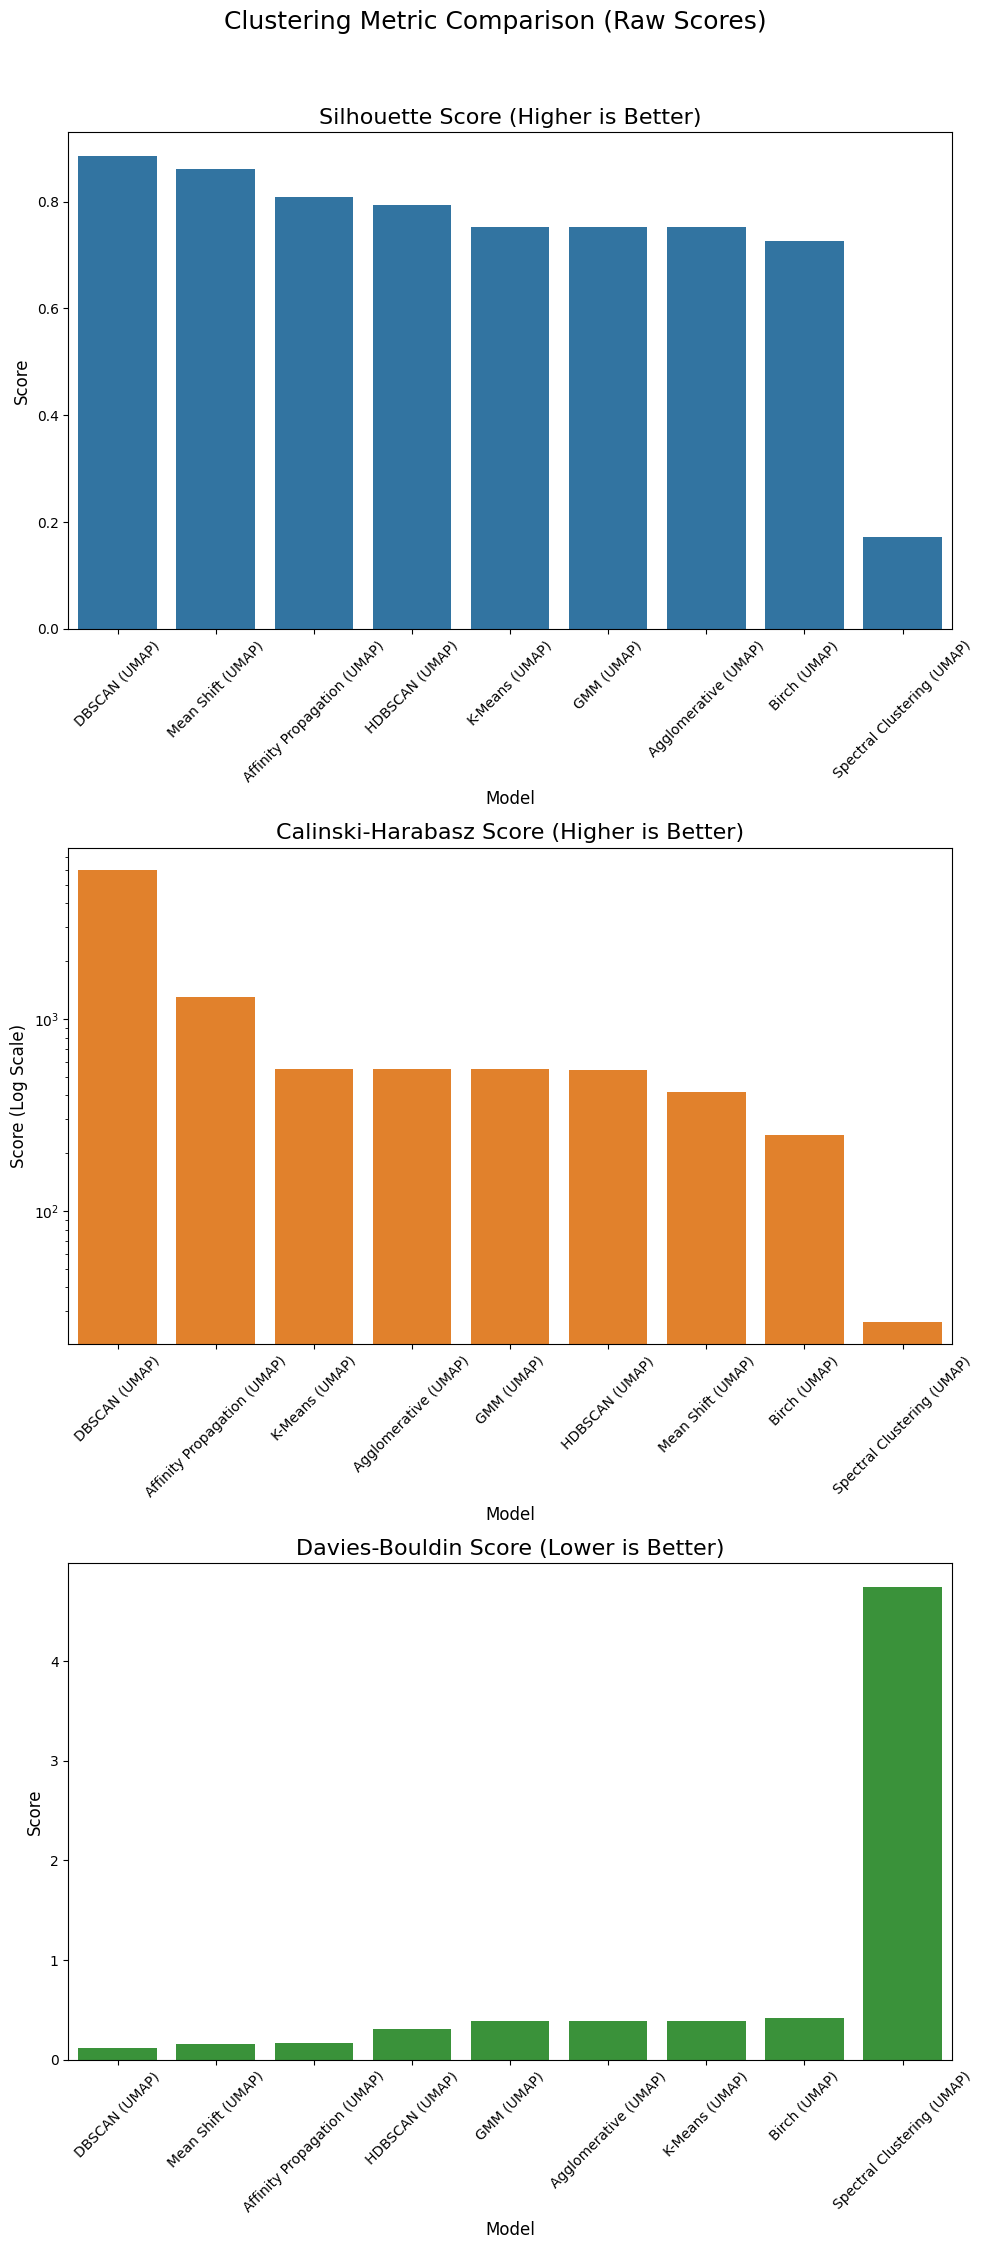

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the raw metric data
data = {
    "Model": [
        "K-Means (UMAP)", "DBSCAN (UMAP)", "Agglomerative (UMAP)",
        "GMM (UMAP)", "Affinity Propagation (UMAP)", "Mean Shift (UMAP)",
        "Spectral Clustering (UMAP)", "Birch (UMAP)",
        "HDBSCAN (UMAP)"  # <-- ADDED
    ],
    "Silhouette Score": [
        0.751649, 0.885347, 0.751649, 0.751649, 0.808822,
        0.861626, 0.172477, 0.725775,
        0.793199  # <-- ADDED
    ],
    "Calinski-Harabasz Score": [
        548.744873, 5956.537109, 548.744873, 548.744873,
        1309.111328, 417.425995, 26.505274, 248.667938,
        545.636963  # <-- ADDED
    ],
    "Davies-Bouldin Score": [
        0.388494, 0.117261, 0.388494, 0.388494, 0.164639,
        0.158811, 4.748195, 0.417121,
        0.306198  # <-- ADDED
    ]
}

evaluation_df = pd.DataFrame(data)

# Sort the data for ranking
df_s = evaluation_df.sort_values(by='Silhouette Score', ascending=False)
df_c = evaluation_df.sort_values(by='Calinski-Harabasz Score', ascending=False)
df_d = evaluation_df.sort_values(by='Davies-Bouldin Score', ascending=True) # Ascending is better

# --- Create the plots ---
plt.style.use('default')

# Create three separate subplots, arranged vertically (3 rows, 1 column)
# Make the figure taller to accommodate them
fig, axes = plt.subplots(3, 1, figsize=(10, 22))
fig.suptitle("Clustering Metric Comparison (Raw Scores)", fontsize=18, y=1.02)

# --- Plot 1: Silhouette Score (Higher is Better) ---
sns.barplot(
    y=df_s['Silhouette Score'],
    x=df_s['Model'],
    ax=axes[0],
    color='C0' # Standard blue
)
axes[0].set_title("Silhouette Score (Higher is Better)", fontsize=16)
axes[0].set_ylabel("Score", fontsize=12)
axes[0].set_xlabel("Model", fontsize=12)
axes[0].tick_params(axis='x', rotation=45) # Rotate x-axis labels

# --- Plot 2: Calinski-Harabasz Score (Higher is Better) ---
sns.barplot(
    y=df_c['Calinski-Harabasz Score'],
    x=df_c['Model'],
    ax=axes[1],
    color='C1' # Standard orange
)
axes[1].set_title("Calinski-Harabasz Score (Higher is Better)", fontsize=16)
axes[1].set_ylabel("Score (Log Scale)", fontsize=12)
axes[1].set_xlabel("Model", fontsize=12)
# A log scale is required on the y-axis
axes[1].set_yscale('log')
axes[1].tick_params(axis='x', rotation=45) # Rotate x-axis labels

# --- Plot 3: Davies-Bouldin Score (Lower is Better) ---
sns.barplot(
    y=df_d['Davies-Bouldin Score'],
    x=df_d['Model'],
    ax=axes[2],
    color='C2' # Standard green
)
axes[2].set_title("Davies-Bouldin Score (Lower is Better)", fontsize=16)
axes[2].set_ylabel("Score", fontsize=12)
axes[2].set_xlabel("Model", fontsize=12)
axes[2].tick_params(axis='x', rotation=45) # Rotate x-axis labels

# Adjust layout
plt.tight_layout()
plt.show()


#   **Analyze Sentiment Distribution within Clusters (All Methods on UMAP Data):**
    *   Examined the distribution of original sentiment, ML predicted sentiment, and VADER sentiment within the clusters found by each method.
    *   Insights:
        *   This analysis helps understand the sentiment composition of each cluster.
        *   Clusters with a high concentration of a specific sentiment can reveal underlying themes or topics associated with that sentiment.

SENTIMENT DISTRIBUTION ANALYSIS WITHIN CLUSTERS (UMAP Data)

--- Analyzing Sentiment Distribution for: kmeans_cluster_umap ---

  Sentiment Source: Sentiment

    Count Distribution:


Sentiment            Negative  Positive
kmeans_cluster_umap                    
0                           8         9
1                           1        22
2                           8         2
3                          12         5
4                           4         4


    Percentage Distribution within Clusters:


Sentiment            Negative  Positive
kmeans_cluster_umap                    
0                       47.06     52.94
1                        4.35     95.65
2                       80.00     20.00
3                       70.59     29.41
4                       50.00     50.00

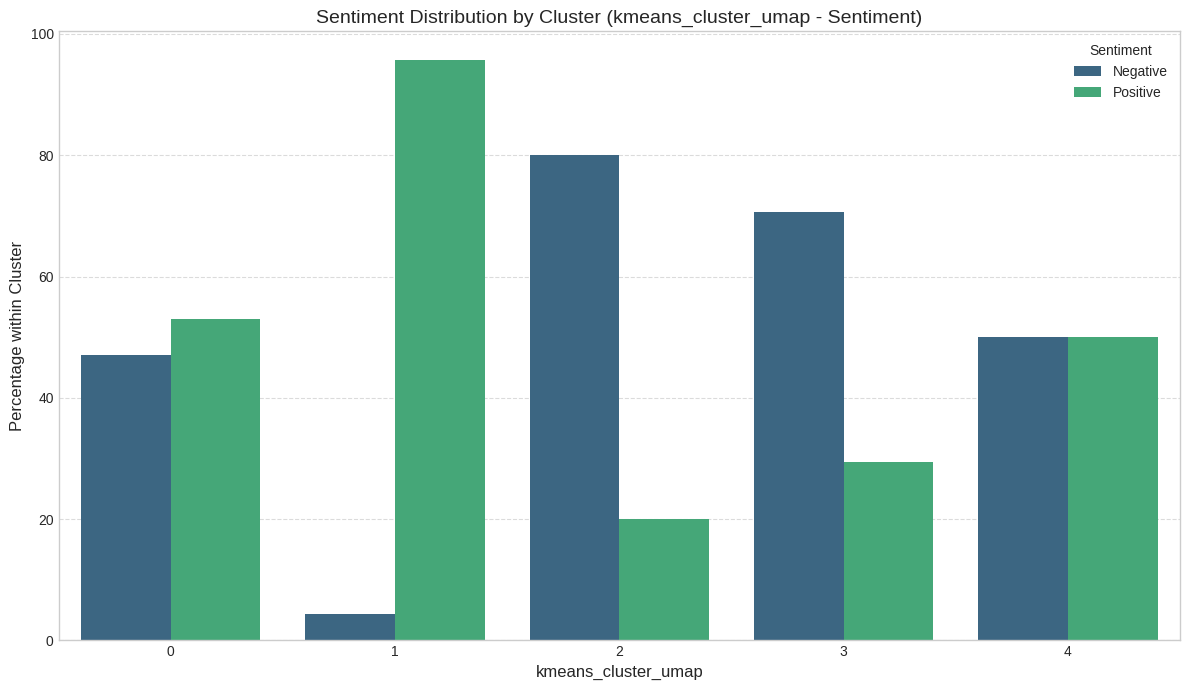


  Sentiment Source: predicted_sentiment_ml

    Count Distribution:


predicted_sentiment_ml  Negative  Positive
kmeans_cluster_umap                       
0                              0         4
1                              0         6
2                              3         0
3                              1         2
4                              0         3


    Percentage Distribution within Clusters:


predicted_sentiment_ml  Negative  Positive
kmeans_cluster_umap                       
0                           0.00    100.00
1                           0.00    100.00
2                         100.00      0.00
3                          33.33     66.67
4                           0.00    100.00

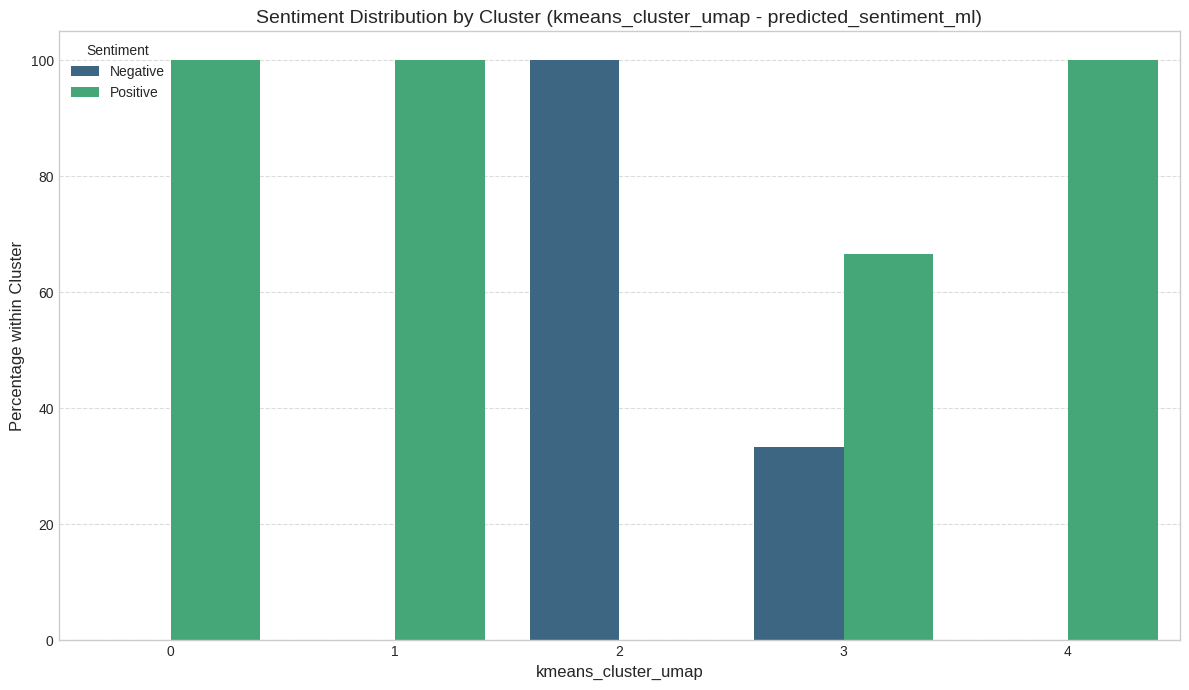


  Sentiment Source: vader_sentiment_label

    Count Distribution:


vader_sentiment_label  Negative  Neutral  Positive
kmeans_cluster_umap                               
0                             7        3         7
1                             3        2        18
2                             7        1         2
3                            10        1         6
4                             4        0         4


    Percentage Distribution within Clusters:


vader_sentiment_label  Negative  Neutral  Positive
kmeans_cluster_umap                               
0                         41.18    17.65     41.18
1                         13.04     8.70     78.26
2                         70.00    10.00     20.00
3                         58.82     5.88     35.29
4                         50.00     0.00     50.00

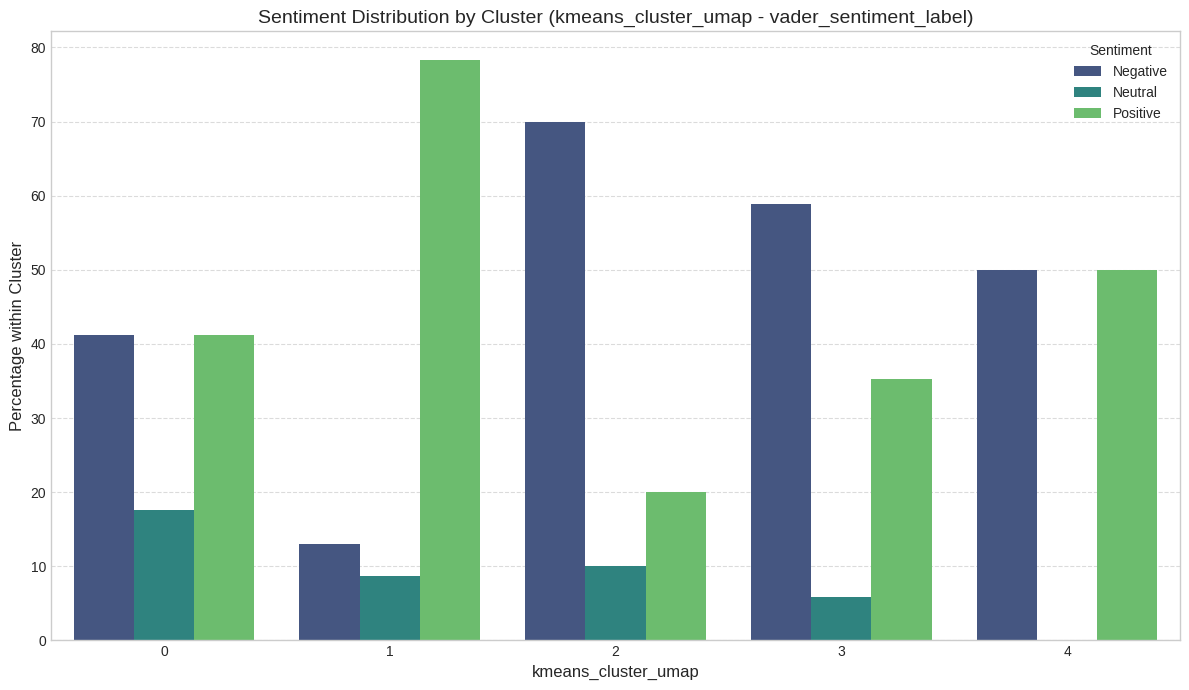


--- Analyzing Sentiment Distribution for: dbscan_cluster_umap ---

  Sentiment Source: Sentiment

    Count Distribution:


Sentiment            Negative  Positive
dbscan_cluster_umap                    
-1                          4         0
 0                          8         2
 1                          1        22
 2                          4         2
 3                          6         6
 4                          4         3
 5                          2         3
 6                          4         4


    Percentage Distribution within Clusters:


Sentiment            Negative  Positive
dbscan_cluster_umap                    
-1                     100.00      0.00
 0                      80.00     20.00
 1                       4.35     95.65
 2                      66.67     33.33
 3                      50.00     50.00
 4                      57.14     42.86
 5                      40.00     60.00
 6                      50.00     50.00

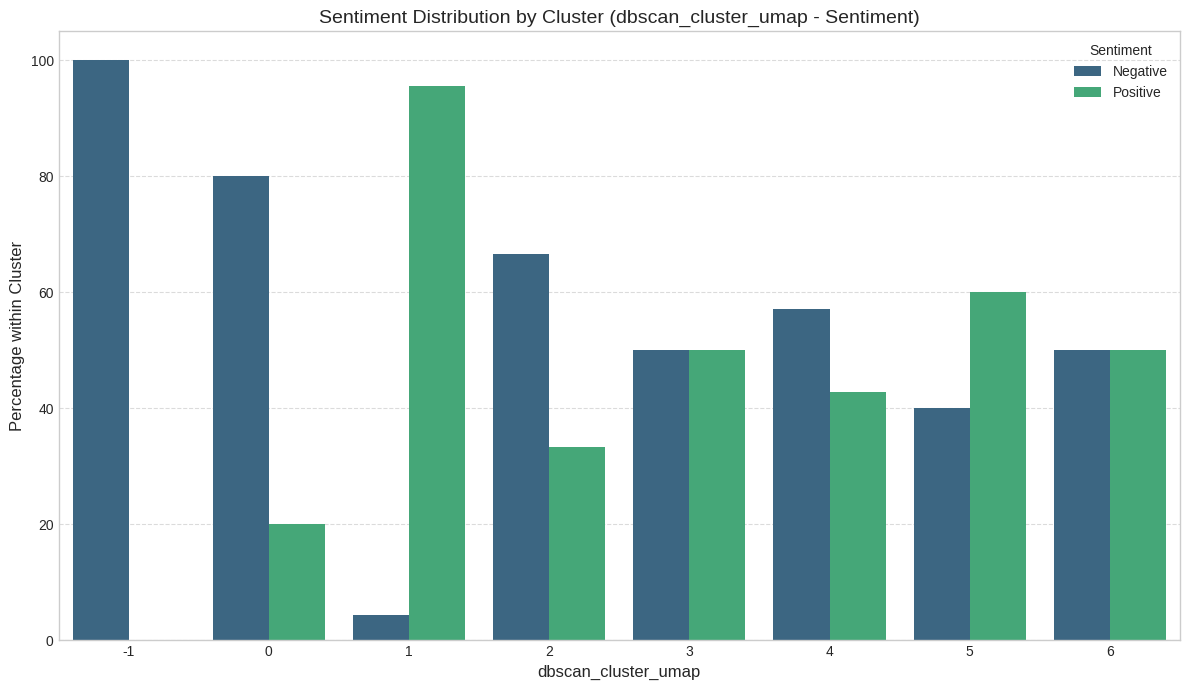


  Sentiment Source: predicted_sentiment_ml

    Count Distribution:


predicted_sentiment_ml  Negative  Positive
dbscan_cluster_umap                       
-1                             0         1
 0                             3         0
 1                             0         6
 3                             0         2
 4                             1         1
 5                             0         2
 6                             0         3


    Percentage Distribution within Clusters:


predicted_sentiment_ml  Negative  Positive
dbscan_cluster_umap                       
-1                           0.0     100.0
 0                         100.0       0.0
 1                           0.0     100.0
 3                           0.0     100.0
 4                          50.0      50.0
 5                           0.0     100.0
 6                           0.0     100.0

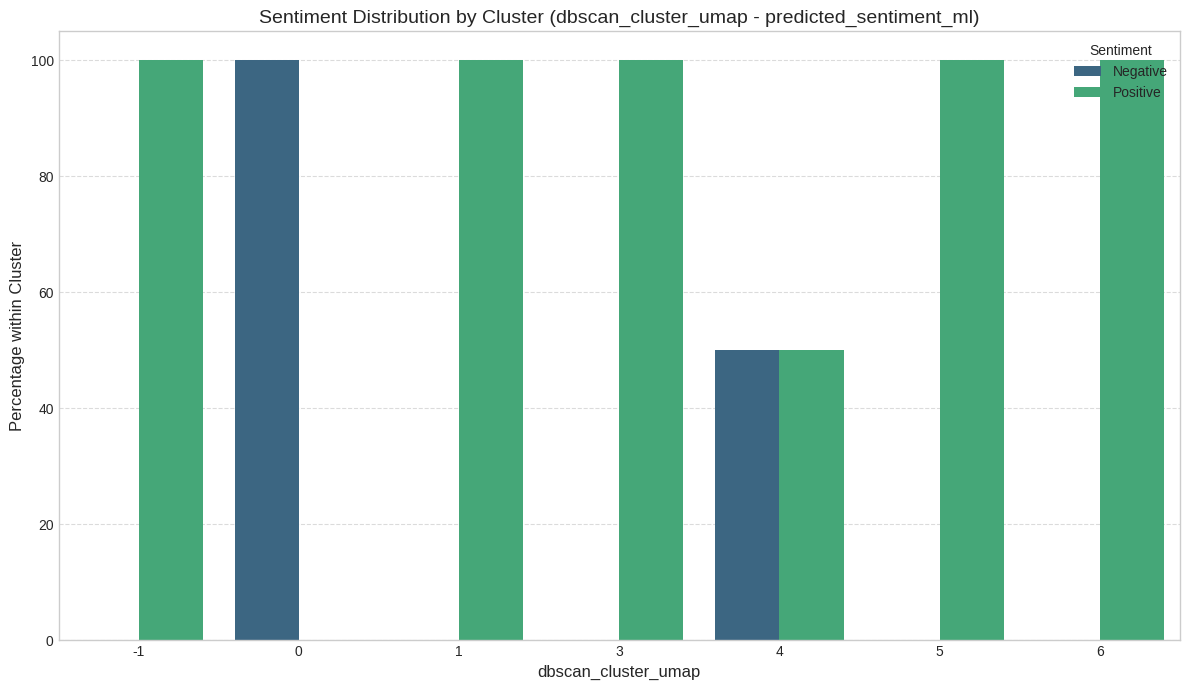


  Sentiment Source: vader_sentiment_label

    Count Distribution:


vader_sentiment_label  Negative  Neutral  Positive
dbscan_cluster_umap                               
-1                            3        0         1
 0                            7        1         2
 1                            3        2        18
 2                            4        0         2
 3                            5        2         5
 4                            3        1         3
 5                            2        1         2
 6                            4        0         4


    Percentage Distribution within Clusters:


vader_sentiment_label  Negative  Neutral  Positive
dbscan_cluster_umap                               
-1                        75.00     0.00     25.00
 0                        70.00    10.00     20.00
 1                        13.04     8.70     78.26
 2                        66.67     0.00     33.33
 3                        41.67    16.67     41.67
 4                        42.86    14.29     42.86
 5                        40.00    20.00     40.00
 6                        50.00     0.00     50.00

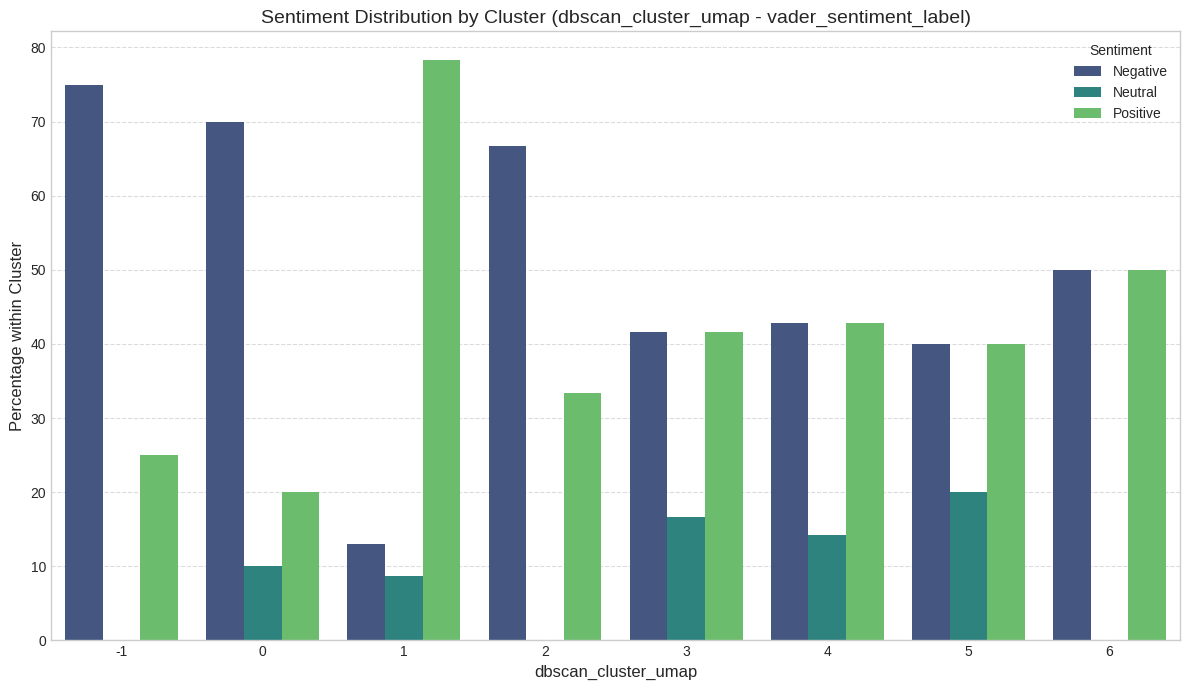


--- Analyzing Sentiment Distribution for: agg_cluster_umap ---

  Sentiment Source: Sentiment

    Count Distribution:


Sentiment         Negative  Positive
agg_cluster_umap                    
0                        8         9
1                       12         5
2                        4         4
3                        8         2
4                        1        22


    Percentage Distribution within Clusters:


Sentiment         Negative  Positive
agg_cluster_umap                    
0                    47.06     52.94
1                    70.59     29.41
2                    50.00     50.00
3                    80.00     20.00
4                     4.35     95.65

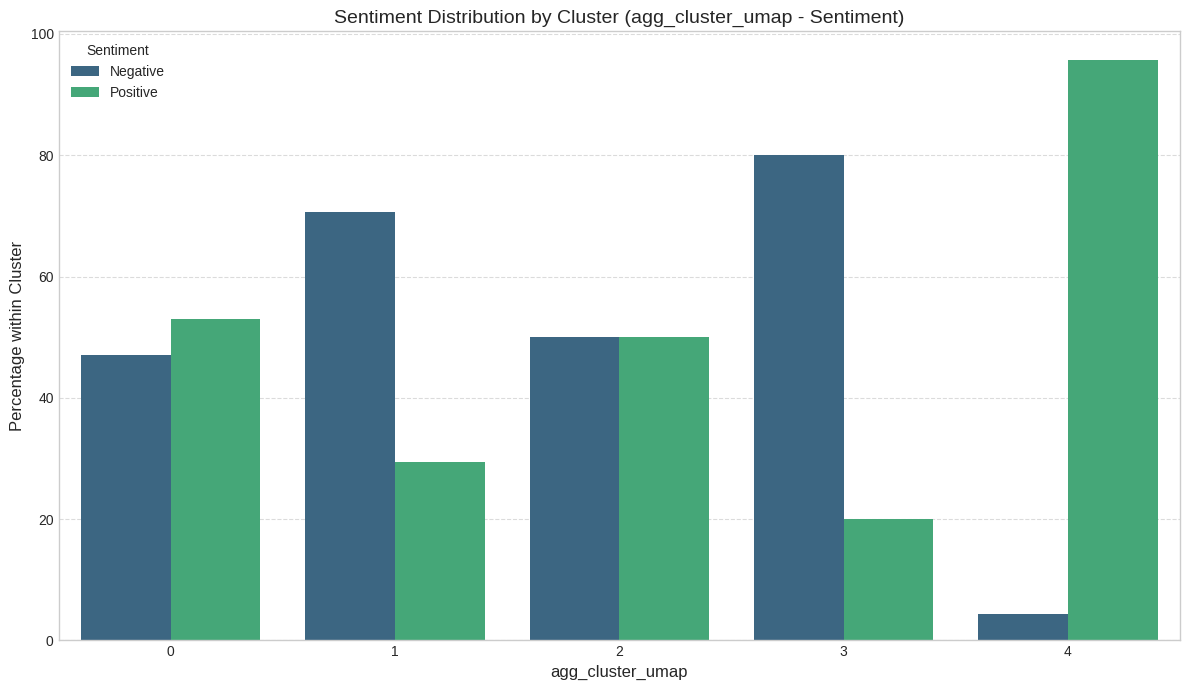


  Sentiment Source: predicted_sentiment_ml

    Count Distribution:


predicted_sentiment_ml  Negative  Positive
agg_cluster_umap                          
0                              0         4
1                              1         2
2                              0         3
3                              3         0
4                              0         6


    Percentage Distribution within Clusters:


predicted_sentiment_ml  Negative  Positive
agg_cluster_umap                          
0                           0.00    100.00
1                          33.33     66.67
2                           0.00    100.00
3                         100.00      0.00
4                           0.00    100.00

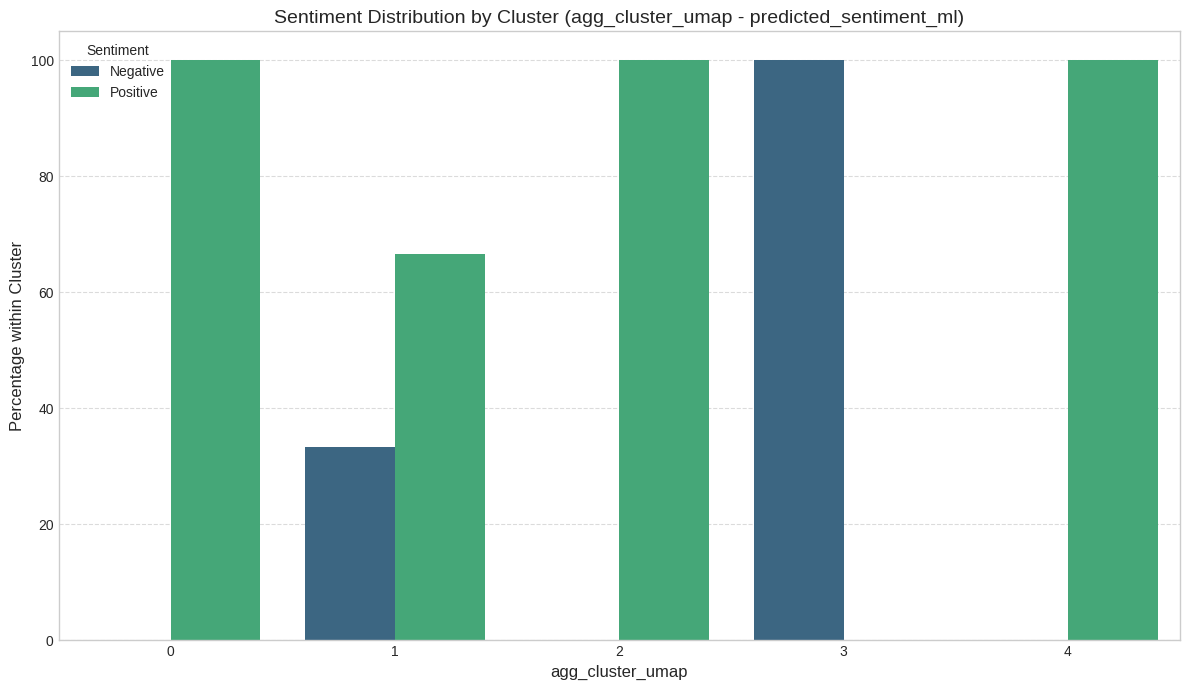


  Sentiment Source: vader_sentiment_label

    Count Distribution:


vader_sentiment_label  Negative  Neutral  Positive
agg_cluster_umap                                  
0                             7        3         7
1                            10        1         6
2                             4        0         4
3                             7        1         2
4                             3        2        18


    Percentage Distribution within Clusters:


vader_sentiment_label  Negative  Neutral  Positive
agg_cluster_umap                                  
0                         41.18    17.65     41.18
1                         58.82     5.88     35.29
2                         50.00     0.00     50.00
3                         70.00    10.00     20.00
4                         13.04     8.70     78.26

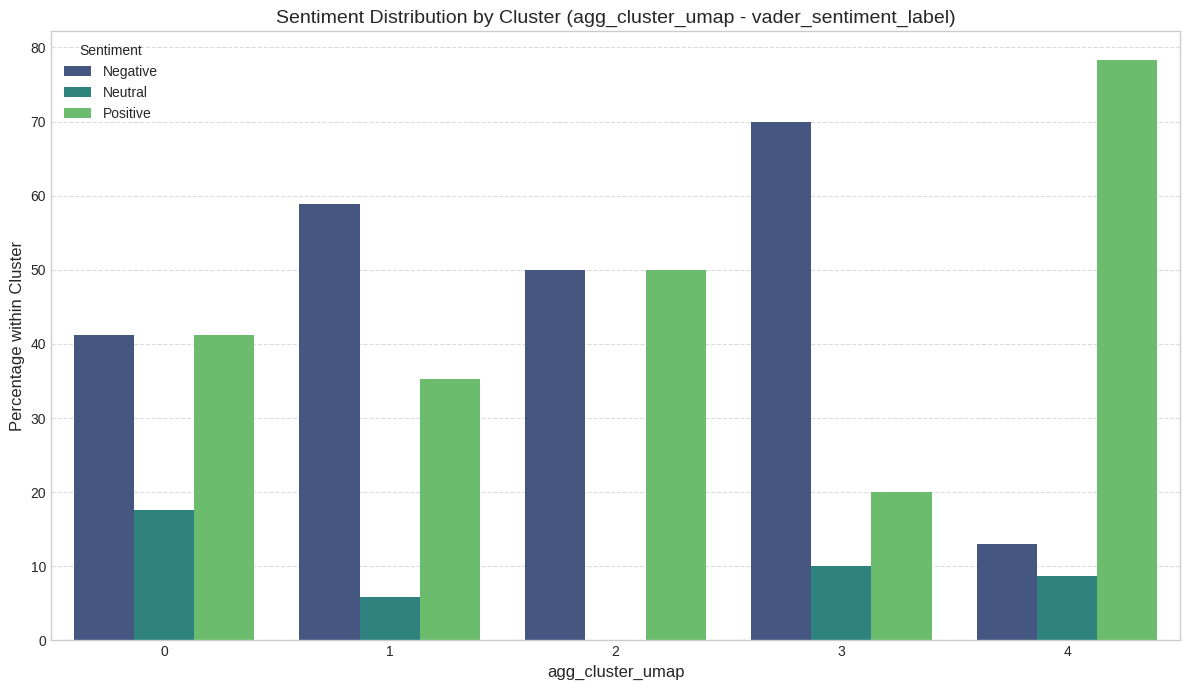


--- Analyzing Sentiment Distribution for: gmm_cluster_umap ---

  Sentiment Source: Sentiment

    Count Distribution:


Sentiment         Negative  Positive
gmm_cluster_umap                    
0                        8         9
1                        1        22
2                        8         2
3                       12         5
4                        4         4


    Percentage Distribution within Clusters:


Sentiment         Negative  Positive
gmm_cluster_umap                    
0                    47.06     52.94
1                     4.35     95.65
2                    80.00     20.00
3                    70.59     29.41
4                    50.00     50.00

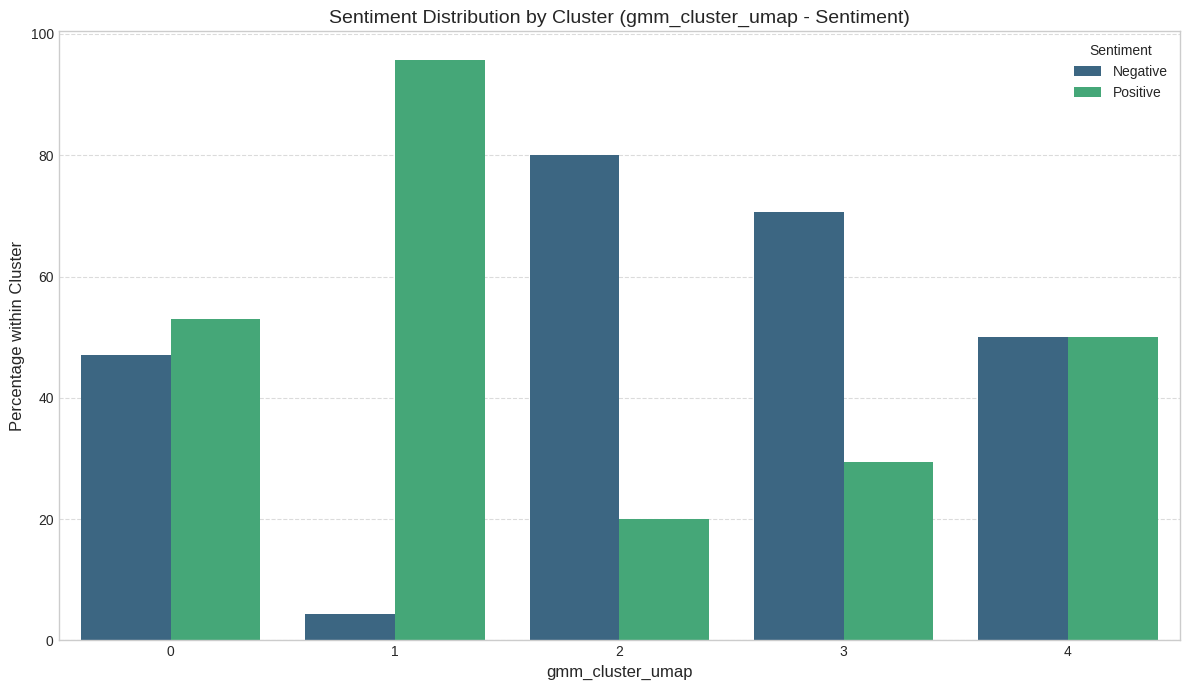


  Sentiment Source: predicted_sentiment_ml

    Count Distribution:


predicted_sentiment_ml  Negative  Positive
gmm_cluster_umap                          
0                              0         4
1                              0         6
2                              3         0
3                              1         2
4                              0         3


    Percentage Distribution within Clusters:


predicted_sentiment_ml  Negative  Positive
gmm_cluster_umap                          
0                           0.00    100.00
1                           0.00    100.00
2                         100.00      0.00
3                          33.33     66.67
4                           0.00    100.00

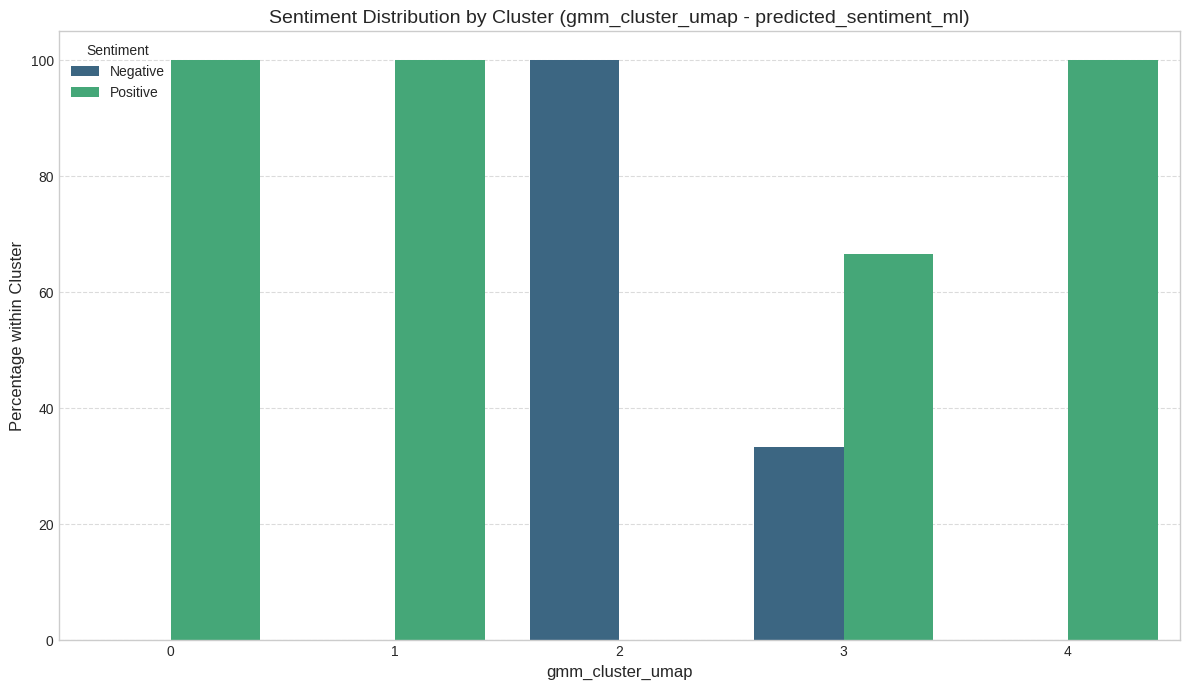


  Sentiment Source: vader_sentiment_label

    Count Distribution:


vader_sentiment_label  Negative  Neutral  Positive
gmm_cluster_umap                                  
0                             7        3         7
1                             3        2        18
2                             7        1         2
3                            10        1         6
4                             4        0         4


    Percentage Distribution within Clusters:


vader_sentiment_label  Negative  Neutral  Positive
gmm_cluster_umap                                  
0                         41.18    17.65     41.18
1                         13.04     8.70     78.26
2                         70.00    10.00     20.00
3                         58.82     5.88     35.29
4                         50.00     0.00     50.00

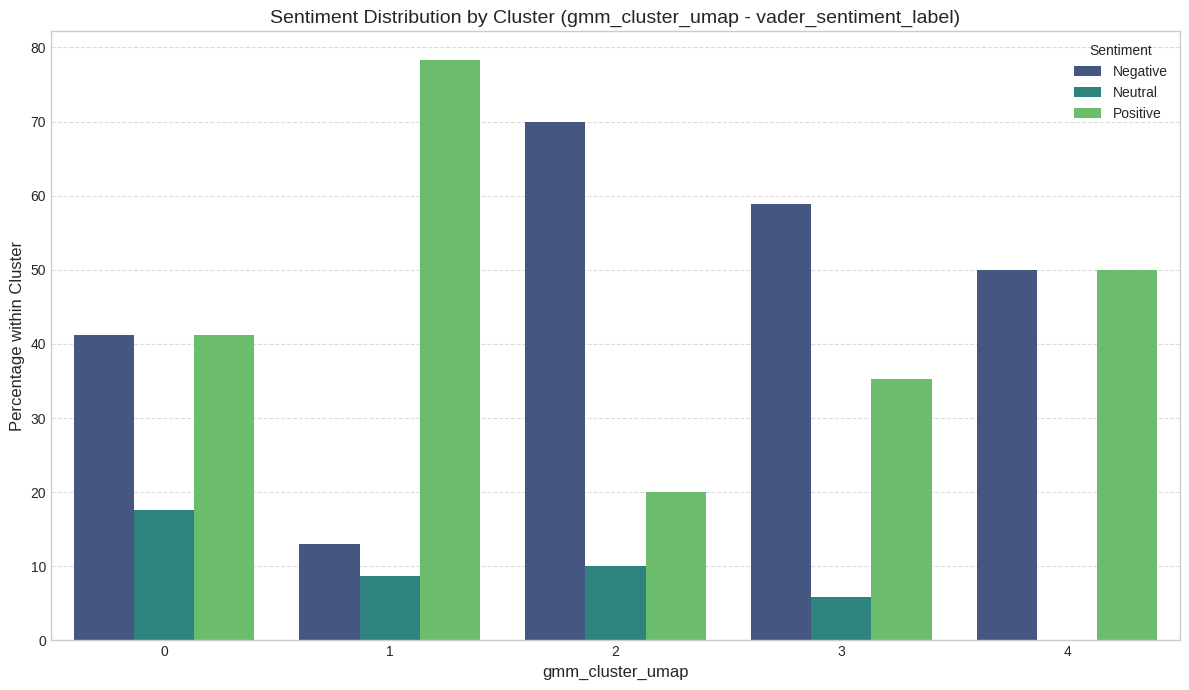


--- Analyzing Sentiment Distribution for: affinity_cluster_umap ---

  Sentiment Source: Sentiment

    Count Distribution:


Sentiment              Negative  Positive
affinity_cluster_umap                    
0                             8         2
1                             7         3
2                             2         3
3                             6         6
4                             4         4
5                             6        24


    Percentage Distribution within Clusters:


Sentiment              Negative  Positive
affinity_cluster_umap                    
0                          80.0      20.0
1                          70.0      30.0
2                          40.0      60.0
3                          50.0      50.0
4                          50.0      50.0
5                          20.0      80.0

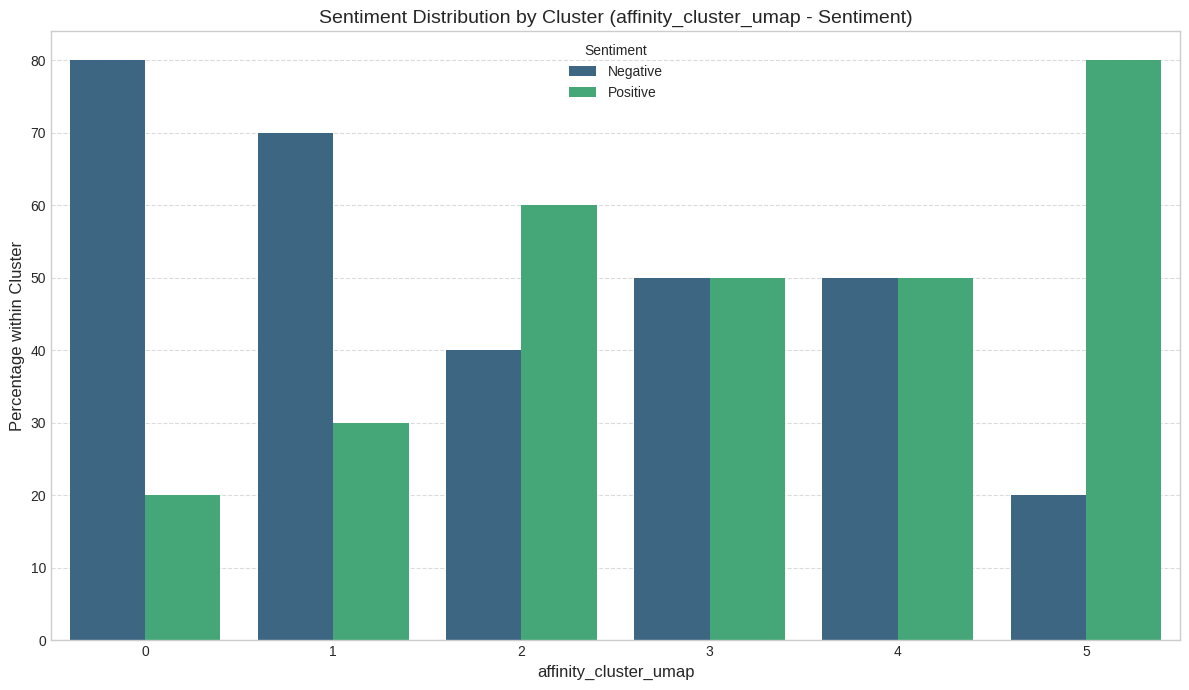


  Sentiment Source: predicted_sentiment_ml

    Count Distribution:


predicted_sentiment_ml  Negative  Positive
affinity_cluster_umap                     
0                              3         0
1                              1         1
2                              0         2
3                              0         2
4                              0         3
5                              0         7


    Percentage Distribution within Clusters:


predicted_sentiment_ml  Negative  Positive
affinity_cluster_umap                     
0                          100.0       0.0
1                           50.0      50.0
2                            0.0     100.0
3                            0.0     100.0
4                            0.0     100.0
5                            0.0     100.0

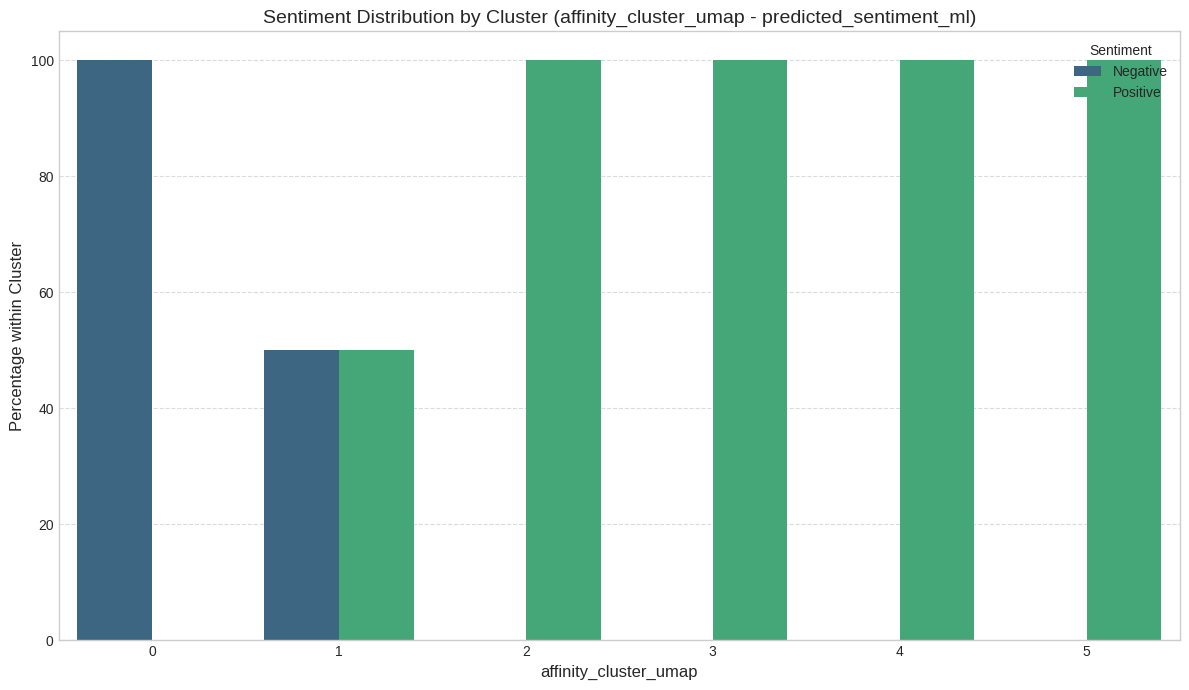


  Sentiment Source: vader_sentiment_label

    Count Distribution:


vader_sentiment_label  Negative  Neutral  Positive
affinity_cluster_umap                             
0                             7        1         2
1                             5        1         4
2                             2        1         2
3                             5        2         5
4                             4        0         4
5                             8        2        20


    Percentage Distribution within Clusters:


vader_sentiment_label  Negative  Neutral  Positive
affinity_cluster_umap                             
0                         70.00    10.00     20.00
1                         50.00    10.00     40.00
2                         40.00    20.00     40.00
3                         41.67    16.67     41.67
4                         50.00     0.00     50.00
5                         26.67     6.67     66.67

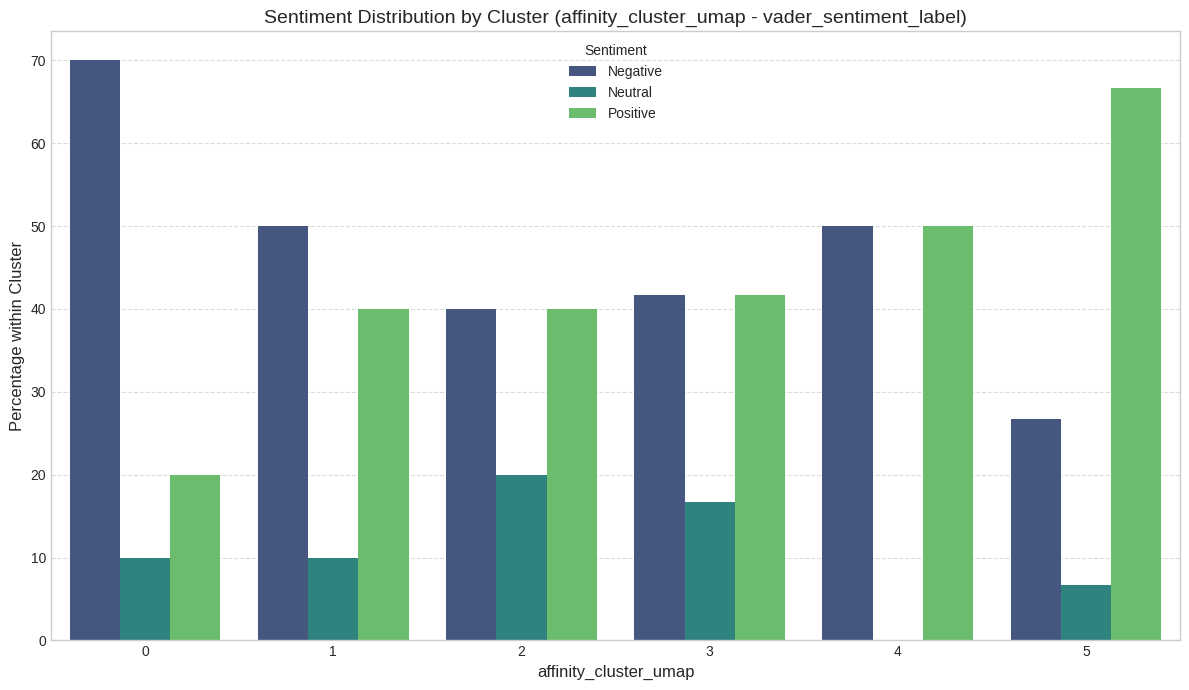


--- Analyzing Sentiment Distribution for: meanshift_cluster_umap ---

  Sentiment Source: Sentiment

    Count Distribution:


Sentiment               Negative  Positive
meanshift_cluster_umap                    
0                             13        27
1                              6         6
2                              8         2
3                              4         4
4                              2         3


    Percentage Distribution within Clusters:


Sentiment               Negative  Positive
meanshift_cluster_umap                    
0                           32.5      67.5
1                           50.0      50.0
2                           80.0      20.0
3                           50.0      50.0
4                           40.0      60.0

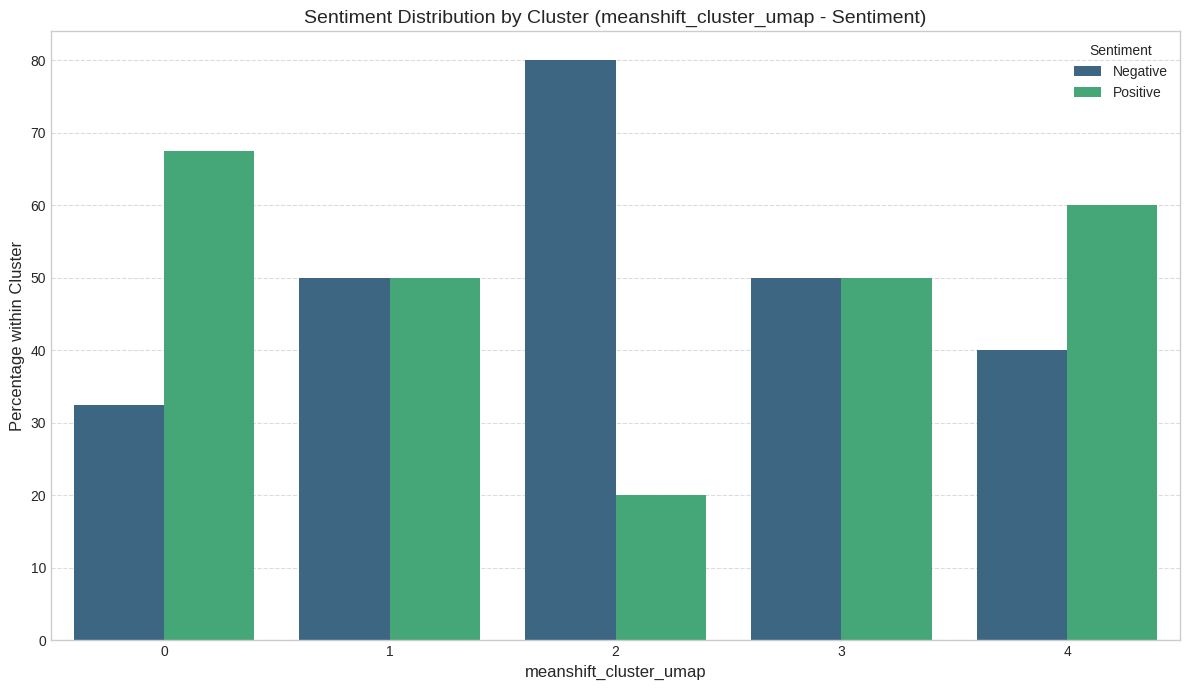


  Sentiment Source: predicted_sentiment_ml

    Count Distribution:


predicted_sentiment_ml  Negative  Positive
meanshift_cluster_umap                    
0                              1         8
1                              0         2
2                              3         0
3                              0         3
4                              0         2


    Percentage Distribution within Clusters:


predicted_sentiment_ml  Negative  Positive
meanshift_cluster_umap                    
0                          11.11     88.89
1                           0.00    100.00
2                         100.00      0.00
3                           0.00    100.00
4                           0.00    100.00

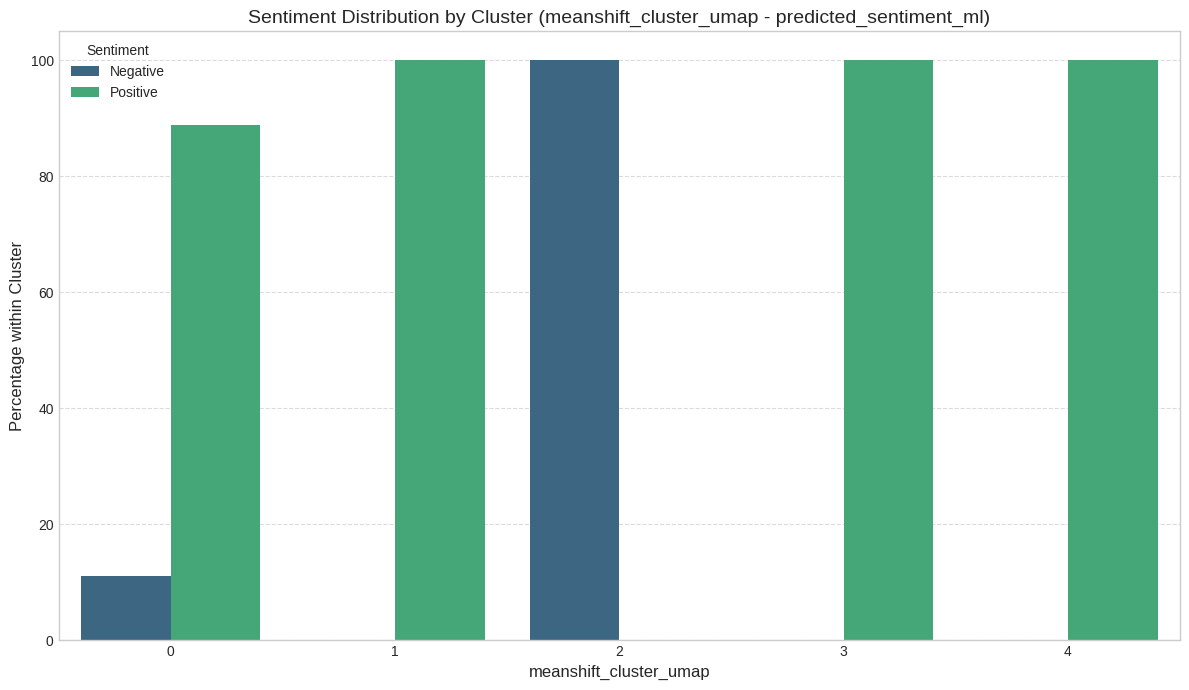


  Sentiment Source: vader_sentiment_label

    Count Distribution:


vader_sentiment_label   Negative  Neutral  Positive
meanshift_cluster_umap                             
0                             13        3        24
1                              5        2         5
2                              7        1         2
3                              4        0         4
4                              2        1         2


    Percentage Distribution within Clusters:


vader_sentiment_label   Negative  Neutral  Positive
meanshift_cluster_umap                             
0                          32.50     7.50     60.00
1                          41.67    16.67     41.67
2                          70.00    10.00     20.00
3                          50.00     0.00     50.00
4                          40.00    20.00     40.00

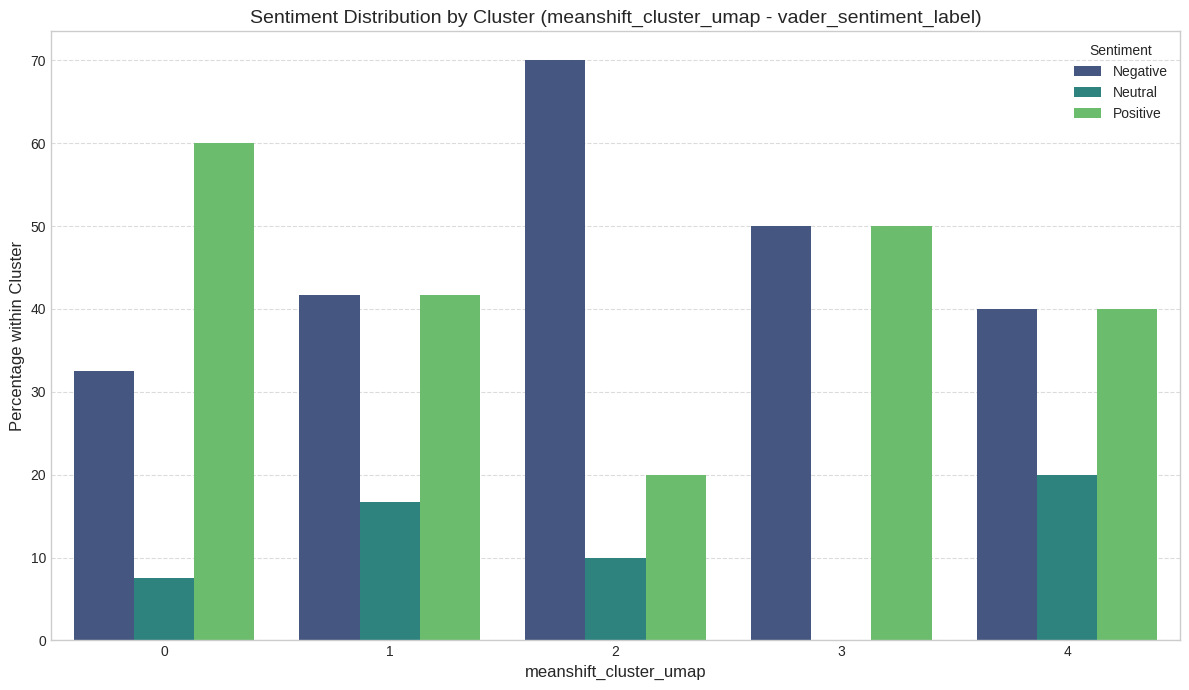


--- Analyzing Sentiment Distribution for: spectral_cluster_umap ---

  Sentiment Source: Sentiment

    Count Distribution:


Sentiment              Negative  Positive
spectral_cluster_umap                    
0                             9        24
1                             2         3
2                             5         2
3                             7         3
4                            10        10


    Percentage Distribution within Clusters:


Sentiment              Negative  Positive
spectral_cluster_umap                    
0                         27.27     72.73
1                         40.00     60.00
2                         71.43     28.57
3                         70.00     30.00
4                         50.00     50.00

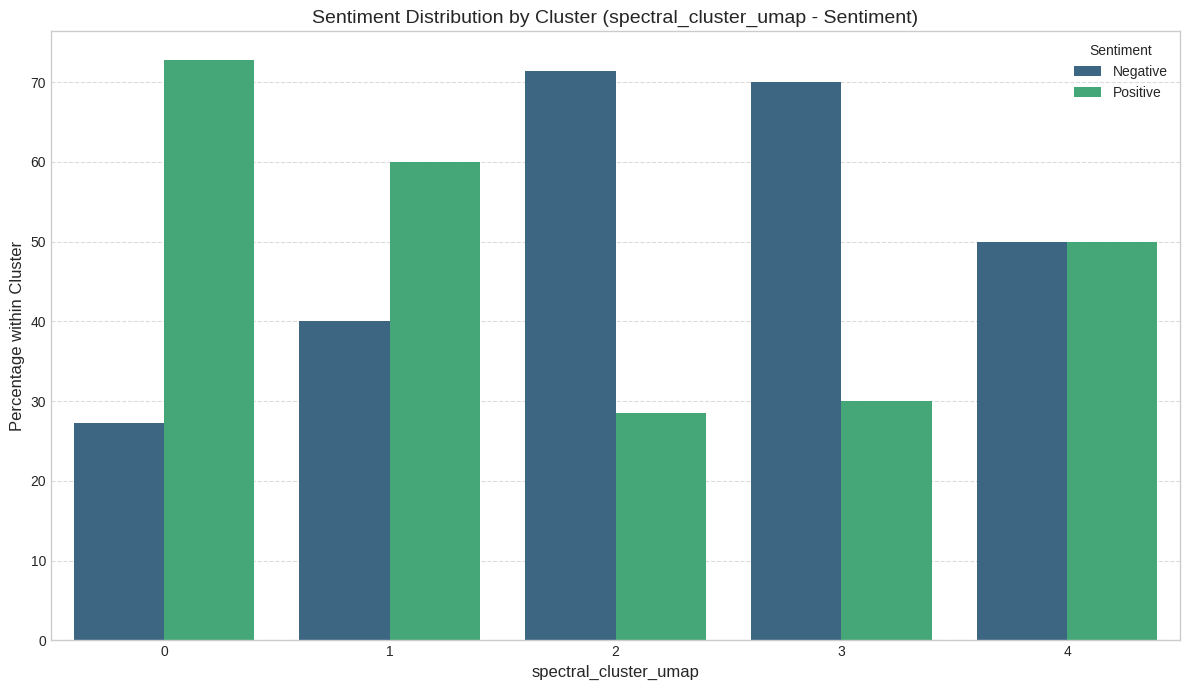


  Sentiment Source: predicted_sentiment_ml

    Count Distribution:


predicted_sentiment_ml  Negative  Positive
spectral_cluster_umap                     
0                              3         6
1                              0         2
2                              0         1
3                              1         1
4                              0         5


    Percentage Distribution within Clusters:


predicted_sentiment_ml  Negative  Positive
spectral_cluster_umap                     
0                          33.33     66.67
1                           0.00    100.00
2                           0.00    100.00
3                          50.00     50.00
4                           0.00    100.00

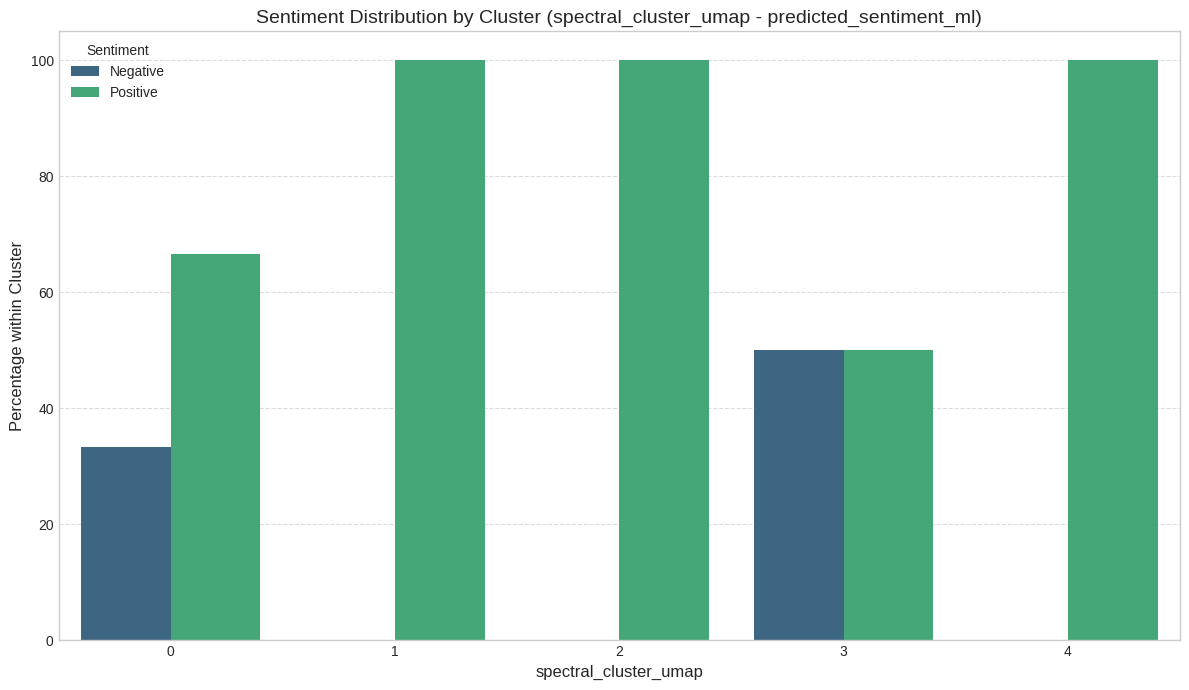


  Sentiment Source: vader_sentiment_label

    Count Distribution:


vader_sentiment_label  Negative  Neutral  Positive
spectral_cluster_umap                             
0                            10        3        20
1                             2        1         2
2                             5        0         2
3                             5        1         4
4                             9        2         9


    Percentage Distribution within Clusters:


vader_sentiment_label  Negative  Neutral  Positive
spectral_cluster_umap                             
0                         30.30     9.09     60.61
1                         40.00    20.00     40.00
2                         71.43     0.00     28.57
3                         50.00    10.00     40.00
4                         45.00    10.00     45.00

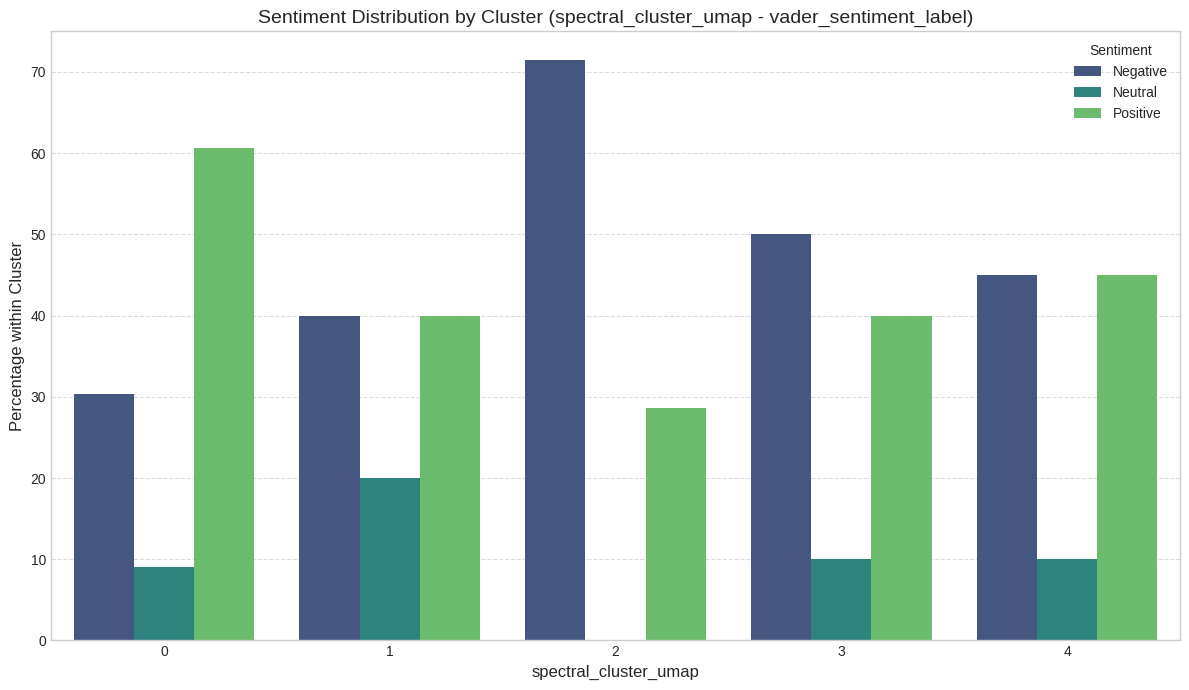


--- Analyzing Sentiment Distribution for: birch_cluster_umap ---

  Sentiment Source: Sentiment

    Count Distribution:


Sentiment           Negative  Positive
birch_cluster_umap                    
0                         16        11
1                         13        27
2                          4         4


    Percentage Distribution within Clusters:


Sentiment           Negative  Positive
birch_cluster_umap                    
0                      59.26     40.74
1                      32.50     67.50
2                      50.00     50.00

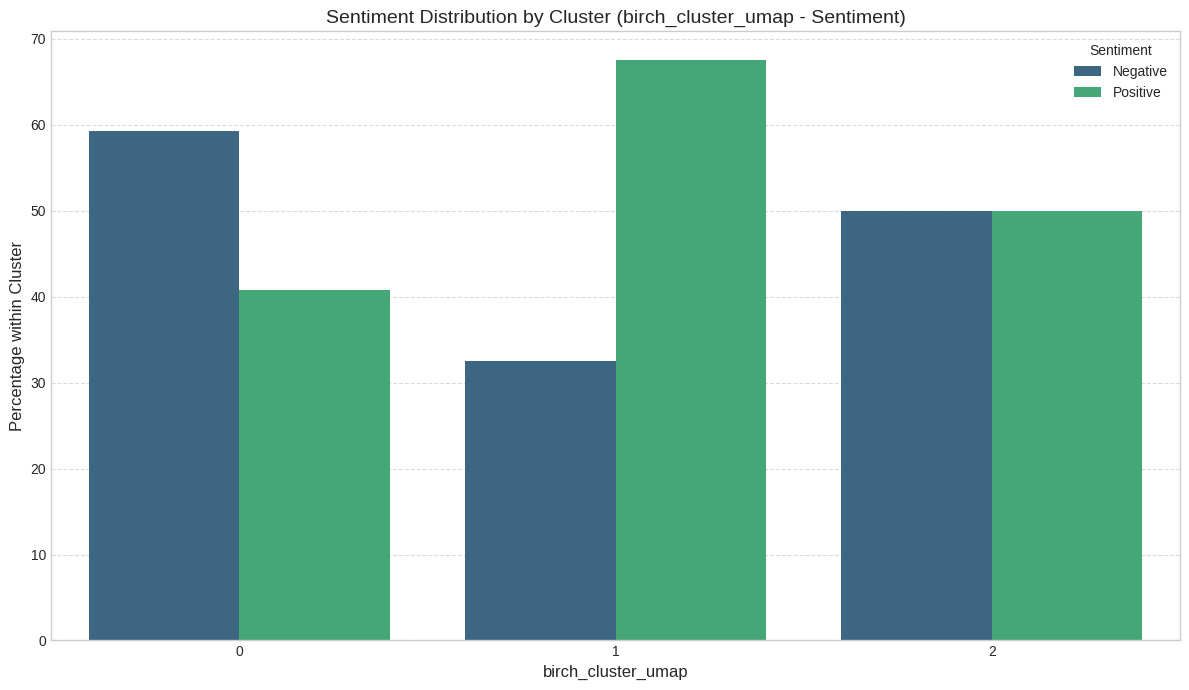


  Sentiment Source: predicted_sentiment_ml

    Count Distribution:


predicted_sentiment_ml  Negative  Positive
birch_cluster_umap                        
0                              3         4
1                              1         8
2                              0         3


    Percentage Distribution within Clusters:


predicted_sentiment_ml  Negative  Positive
birch_cluster_umap                        
0                          42.86     57.14
1                          11.11     88.89
2                           0.00    100.00

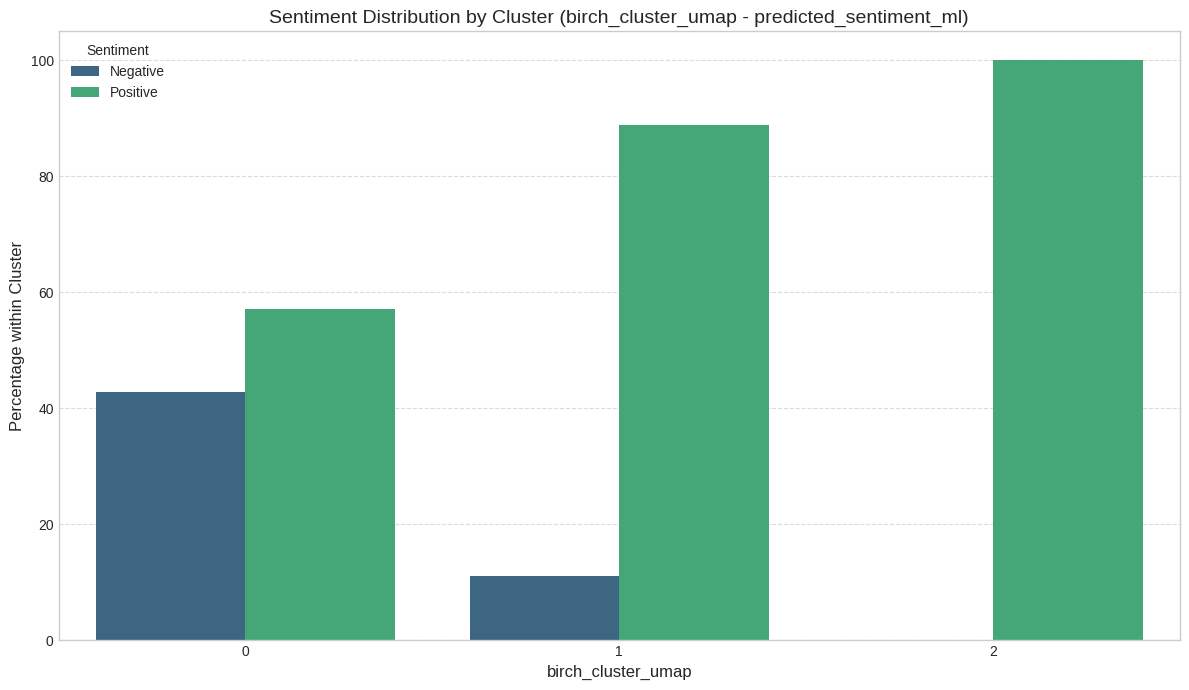


  Sentiment Source: vader_sentiment_label

    Count Distribution:


vader_sentiment_label  Negative  Neutral  Positive
birch_cluster_umap                                
0                            14        4         9
1                            13        3        24
2                             4        0         4


    Percentage Distribution within Clusters:


vader_sentiment_label  Negative  Neutral  Positive
birch_cluster_umap                                
0                         51.85    14.81     33.33
1                         32.50     7.50     60.00
2                         50.00     0.00     50.00

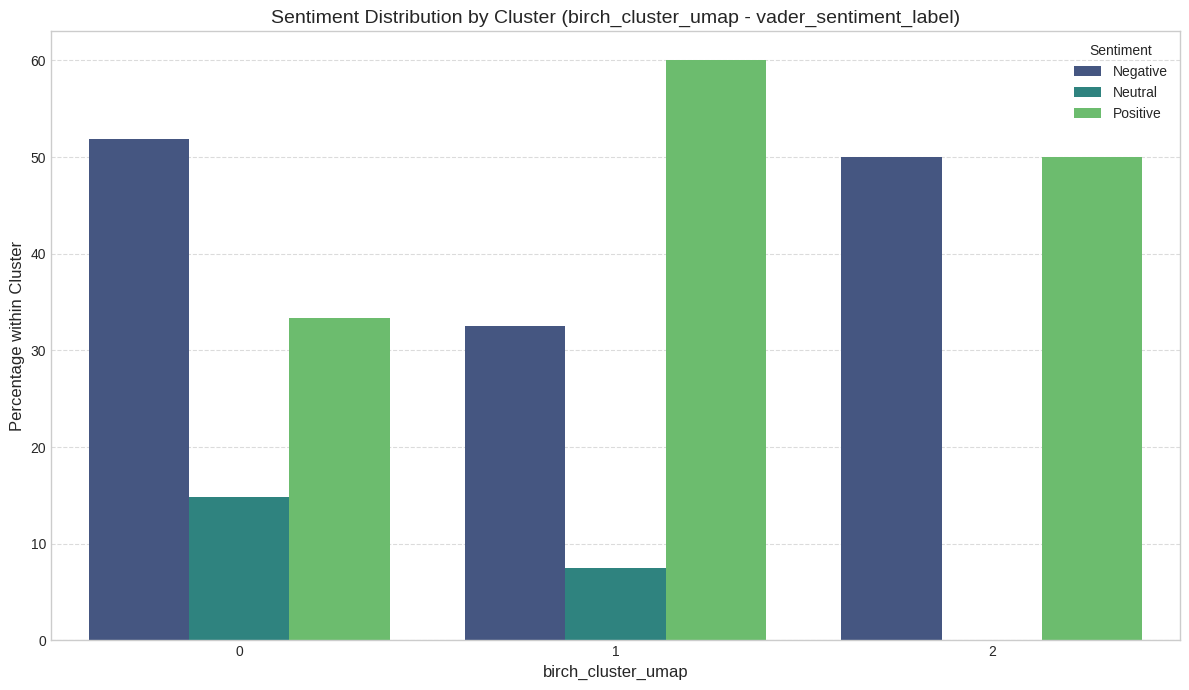


--- Analyzing Sentiment Distribution for: hdbscan_cluster_umap ---

  Sentiment Source: Sentiment

    Count Distribution:


Sentiment             Negative  Positive
hdbscan_cluster_umap                    
0                            7         3
1                            4         4
2                            1        22
3                            5         2
4                            8         2
5                            8         9


    Percentage Distribution within Clusters:


Sentiment             Negative  Positive
hdbscan_cluster_umap                    
0                        70.00     30.00
1                        50.00     50.00
2                         4.35     95.65
3                        71.43     28.57
4                        80.00     20.00
5                        47.06     52.94

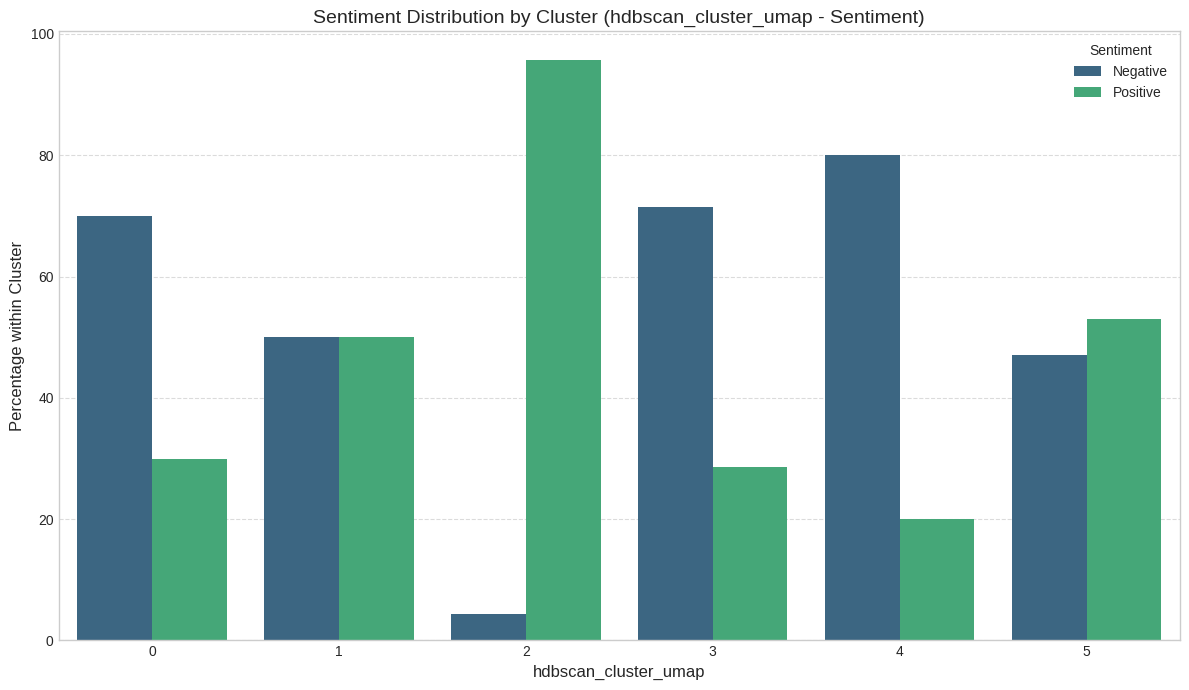


  Sentiment Source: predicted_sentiment_ml

    Count Distribution:


predicted_sentiment_ml  Negative  Positive
hdbscan_cluster_umap                      
0                              1         1
1                              0         3
2                              0         6
3                              0         1
4                              3         0
5                              0         4


    Percentage Distribution within Clusters:


predicted_sentiment_ml  Negative  Positive
hdbscan_cluster_umap                      
0                           50.0      50.0
1                            0.0     100.0
2                            0.0     100.0
3                            0.0     100.0
4                          100.0       0.0
5                            0.0     100.0

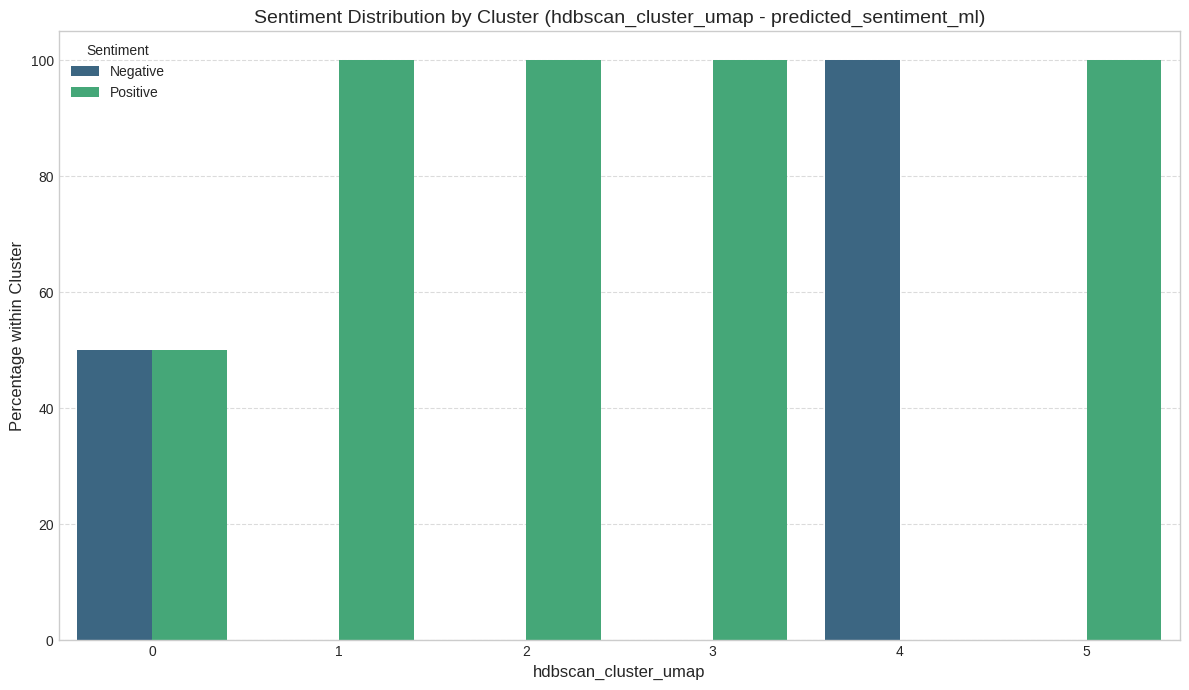


  Sentiment Source: vader_sentiment_label

    Count Distribution:


vader_sentiment_label  Negative  Neutral  Positive
hdbscan_cluster_umap                              
0                             5        1         4
1                             4        0         4
2                             3        2        18
3                             5        0         2
4                             7        1         2
5                             7        3         7


    Percentage Distribution within Clusters:


vader_sentiment_label  Negative  Neutral  Positive
hdbscan_cluster_umap                              
0                         50.00    10.00     40.00
1                         50.00     0.00     50.00
2                         13.04     8.70     78.26
3                         71.43     0.00     28.57
4                         70.00    10.00     20.00
5                         41.18    17.65     41.18

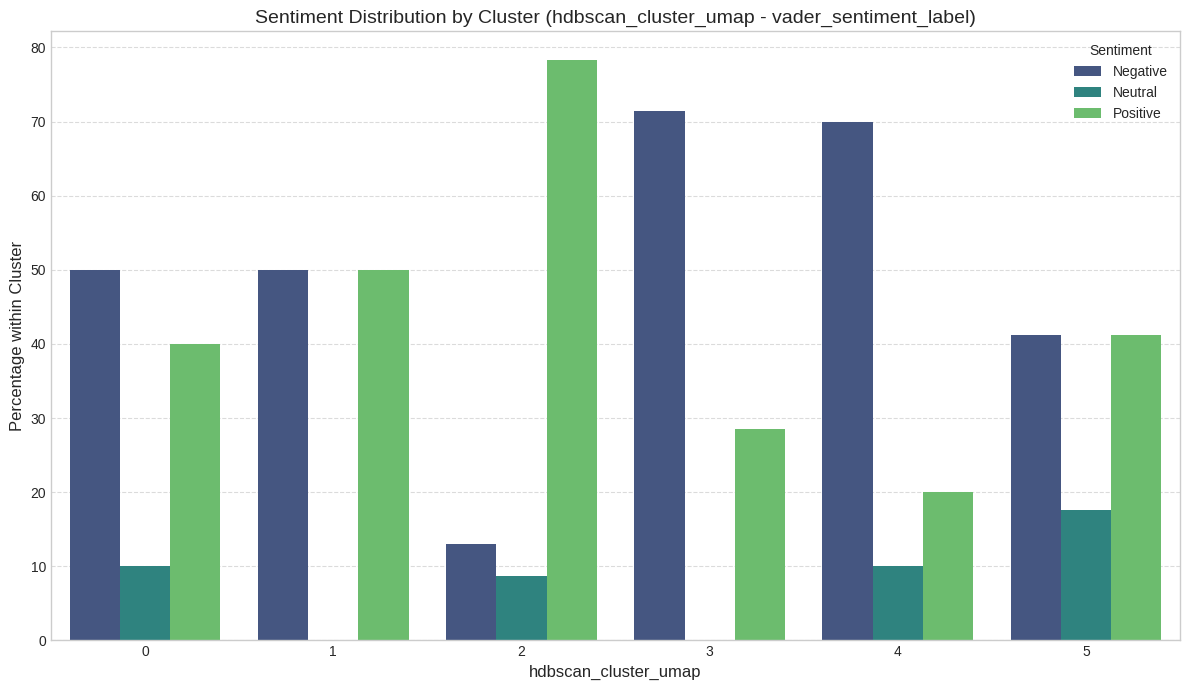

In [85]:
# ============================================================================
# ANALYZE SENTIMENT DISTRIBUTION WITHIN CLUSTERS (ALL METHODS ON UMAP DATA)
# ============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("SENTIMENT DISTRIBUTION ANALYSIS WITHIN CLUSTERS (UMAP Data)")
print("="*80)

# Ensure df_clean exists and has all required cluster label columns
required_labels = ['kmeans_cluster_umap', 'dbscan_cluster_umap', 'agg_cluster_umap',
                   'gmm_cluster_umap', 'affinity_cluster_umap', 'meanshift_cluster_umap',
                   'spectral_cluster_umap', 'birch_cluster_umap', 'hdbscan_cluster_umap']

if 'df_clean' not in locals():
     print("Error: 'df_clean' DataFrame not found. Please run all clustering cells.")
elif any(label not in df_clean.columns for label in required_labels):
    print("Error: Not all required cluster label columns were found in df_clean.")
    print("Missing columns:")
    for label in required_labels:
        if label not in df_clean.columns:
            print(f"  - {label}")
else:
    # Define the sentiment columns to analyze
    sentiment_cols = ['Sentiment', 'predicted_sentiment_ml', 'vader_sentiment_label'] # Assuming vader_sentiment_label is also relevant

    for cluster_col in required_labels:
        print(f"\n--- Analyzing Sentiment Distribution for: {cluster_col} ---")

        # Ensure the cluster column has valid data (not all None or -1)
        if df_clean[cluster_col].isnull().all() or (cluster_col in ['dbscan_cluster_umap', 'hdbscan_cluster_umap'] and (df_clean[cluster_col] == -1).all()):
            print(f"  Skipping {cluster_col}: No valid clusters found or column is all null/noise.")
            continue

        # Iterate through each sentiment column
        for sentiment_col in sentiment_cols:
            print(f"\n  Sentiment Source: {sentiment_col}")

            # Drop rows with missing values in either cluster or sentiment column for accurate counts
            df_temp = df_clean.dropna(subset=[cluster_col, sentiment_col]).copy()

            if df_temp.empty:
                print(f"    No valid data for {sentiment_col} and {cluster_col}.")
                continue

            # Group by cluster and sentiment, then count occurrences
            sentiment_by_cluster = df_temp.groupby([cluster_col, sentiment_col]).size().unstack(fill_value=0)

            # Calculate percentages within each cluster
            sentiment_by_cluster_percent = sentiment_by_cluster.divide(sentiment_by_cluster.sum(axis=1), axis=0) * 100

            print("\n    Count Distribution:")
            display(sentiment_by_cluster)

            print("\n    Percentage Distribution within Clusters:")
            display(sentiment_by_cluster_percent.round(2))

            # Optional: Visualize the sentiment distribution within clusters
            try:
                # Melt the percentage DataFrame for plotting
                df_melted = sentiment_by_cluster_percent.reset_index().melt(
                    id_vars=cluster_col, var_name='Sentiment', value_name='Percentage'
                )

                plt.figure(figsize=(12, 7))
                sns.barplot(data=df_melted, x=cluster_col, y='Percentage', hue='Sentiment', palette='viridis')
                plt.title(f'Sentiment Distribution by Cluster ({cluster_col} - {sentiment_col})', fontsize=14)
                plt.xlabel(f'{cluster_col}', fontsize=12)
                plt.ylabel('Percentage within Cluster', fontsize=12)
                plt.xticks(rotation=0)
                plt.legend(title='Sentiment')
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"    Could not generate plot for {cluster_col} and {sentiment_col}: {e}")

# Identify Positive and Negative Clusters (DBSCAN UMAP):
    *   Identified specific cluster IDs from DBSCAN that were predominantly positive or negative based on the sentiment distribution analysis.
    *   Insights:
        *   Identifying these specific clusters allows for focused analysis on the text content driving those sentiments.

In [86]:
# ============================================================================
# IDENTIFY POSITIVE AND NEGATIVE CLUSTERS (DBSCAN UMAP)
# ============================================================================

import pandas as pd

print("="*80)
print("IDENTIFYING POSITIVE AND NEGATIVE CLUSTERS (DBSCAN UMAP)")
print("="*80)

# Ensure sentiment_by_cluster_percent_dbscan is available
if 'sentiment_by_cluster_percent_dbscan' in locals():
    # Identify clusters with high percentages of Positive or Negative sentiment
    # You can adjust the threshold (e.g., > 70%) based on what you consider 'predominantly'
    positive_clusters = sentiment_by_cluster_percent_dbscan[sentiment_by_cluster_percent_dbscan['Positive'] > 70].index.tolist()
    negative_clusters = sentiment_by_cluster_percent_dbscan[sentiment_by_cluster_percent_dbscan['Negative'] > 70].index.tolist()

    print(f"Clusters with predominantly Positive sentiment (>70%): {positive_clusters}")
    print(f"Clusters with predominantly Negative sentiment (>70%): {negative_clusters}")

    # Store the identified clusters for the next steps
    # Assuming we'll pick the first predominantly positive/negative cluster if multiple exist
    selected_positive_cluster = positive_clusters[0] if positive_clusters else None
    selected_negative_cluster = negative_clusters[0] if negative_clusters else None

    print("\nSelected clusters for Word Clouds:")
    print(f"  Positive Cluster ID: {selected_positive_cluster}")
    print(f"  Negative Cluster ID: {selected_negative_cluster}")

else:
    print("Error: 'sentiment_by_cluster_percent_dbscan' DataFrame not found. Please run the sentiment analysis cell first.")

IDENTIFYING POSITIVE AND NEGATIVE CLUSTERS (DBSCAN UMAP)
Clusters with predominantly Positive sentiment (>70%): [1]
Clusters with predominantly Negative sentiment (>70%): [0]

Selected clusters for Word Clouds:
  Positive Cluster ID: 1
  Negative Cluster ID: 0



#    **Extract Text for Selected Clusters (DBSCAN UMAP):**
    *   Filtered the data to get the processed text for the identified positive and negative DBSCAN clusters.
    *   Insights:
        *   Extracting the text prepares the data for further analysis or visualization of the content within those specific sentiment-driven clusters.

In [87]:
# ============================================================================
# EXTRACT TEXT FOR SELECTED CLUSTERS (DBSCAN UMAP)
# ============================================================================

import pandas as pd

print("="*80)
print("EXTRACTING TEXT FOR SELECTED CLUSTERS (DBSCAN UMAP)")
print("="*80)

# Ensure df_clean and the selected cluster IDs are available
if 'df_clean' in locals() and 'selected_positive_cluster' in locals() and 'selected_negative_cluster' in locals():

    # Extract text for the selected positive cluster
    if selected_positive_cluster is not None:
        # Use 'text_processed' column for word clouds
        positive_cluster_texts = df_clean[df_clean['dbscan_cluster_umap'] == selected_positive_cluster]['text_processed']
        print(f"✓ Extracted {len(positive_cluster_texts)} texts for Positive Cluster {selected_positive_cluster}.")
    else:
        positive_cluster_texts = pd.Series([]) # Empty series if no positive cluster found
        print("No predominantly Positive cluster identified or selected.")

    # Extract text for the selected negative cluster
    if selected_negative_cluster is not None:
        # Use 'text_processed' column for word clouds
        negative_cluster_texts = df_clean[df_clean['dbscan_cluster_umap'] == selected_negative_cluster]['text_processed']
        print(f"✓ Extracted {len(negative_cluster_texts)} texts for Negative Cluster {selected_negative_cluster}.")
    else:
        negative_cluster_texts = pd.Series([]) # Empty series if no negative cluster found
        print("No predominantly Negative cluster identified or selected.")

else:
    print("Error: Required data (df_clean or selected_cluster_ids) not found. Please run previous cells.")

EXTRACTING TEXT FOR SELECTED CLUSTERS (DBSCAN UMAP)
✓ Extracted 23 texts for Positive Cluster 1.
✓ Extracted 10 texts for Negative Cluster 0.


#   **Summarize Cluster Characteristics (DBSCAN UMAP):**
    *   Summarized the sentiment distribution and provided example text snippets for the DBSCAN clusters.
    *   Insights:
        *   This summary provides a concise overview of what characterizes each cluster found by DBSCAN, helping to interpret the clustering results in a meaningful way.


In [88]:
# ============================================================================
# SUMMARIZE DBSCAN CLUSTER CHARACTERISTICS (UMAP Data)
# ============================================================================

import pandas as pd

print("="*80)
print("SUMMARIZING DBSCAN CLUSTER CHARACTERISTICS (UMAP Data)")
print("="*80)

# Ensure df_clean and dbscan_cluster_umap are available
if 'df_clean' in locals() and 'dbscan_cluster_umap' in df_clean.columns:
    # Drop rows with noise points (-1) for cluster analysis summary
    df_dbscan_clusters = df_clean[df_clean['dbscan_cluster_umap'] != -1].copy()

    if df_dbscan_clusters.empty:
        print("No valid clusters found by DBSCAN (excluding noise). Skipping summary.")
    else:
        # Analyze sentiment distribution within DBSCAN clusters
        # Use the original 'Sentiment' for summarization
        sentiment_by_cluster_dbscan = df_dbscan_clusters.groupby(['dbscan_cluster_umap', 'Sentiment']).size().unstack(fill_value=0)
        sentiment_by_cluster_percent_dbscan = sentiment_by_cluster_dbscan.divide(sentiment_by_cluster_dbscan.sum(axis=1), axis=0) * 100

        print("\n--- Original Sentiment Distribution within DBSCAN Clusters ---")
        display(sentiment_by_cluster_percent_dbscan.round(2))

        # Provide example text snippets for each cluster
        print("\n--- Example Text Snippets from DBSCAN Clusters ---")
        for cluster_id in sorted(df_dbscan_clusters['dbscan_cluster_umap'].unique()):
            print(f"\n--- Cluster {cluster_id} ---")
            cluster_texts = df_dbscan_clusters[df_dbscan_clusters['dbscan_cluster_umap'] == cluster_id]['Text'].sample(min(3, len(df_dbscan_clusters[df_dbscan_clusters['dbscan_cluster_umap'] == cluster_id])), random_state=42) # Get up to 3 samples
            for i, text in enumerate(cluster_texts):
                print(f"  {i+1}. {text}")

        # You could add analysis of other features here if relevant (e.g., Source, Location)
        # For example:
        # print("\n--- Top Sources within DBSCAN Clusters ---")
        # for cluster_id in sorted(df_dbscan_clusters['dbscan_cluster_umap'].unique()):
        #    print(f"\n  Cluster {cluster_id}:")
        #    top_sources = df_dbscan_clusters[df_dbscan_clusters['dbscan_cluster_umap'] == cluster_id]['Source'].value_counts().head(3)
        #    display(top_sources)


else:
    print("Error: Required data (df_clean or dbscan_cluster_umap column) not found. Please run relevant previous cells.")

SUMMARIZING DBSCAN CLUSTER CHARACTERISTICS (UMAP Data)

--- Original Sentiment Distribution within DBSCAN Clusters ---


Sentiment            Negative  Positive
dbscan_cluster_umap                    
0                       80.00     20.00
1                        4.35     95.65
2                       66.67     33.33
3                       50.00     50.00
4                       57.14     42.86
5                       40.00     60.00
6                       50.00     50.00


--- Example Text Snippets from DBSCAN Clusters ---

--- Cluster 0 ---
  1. I'm disappointed with the ending of this TV show. It left too many unanswered questions.
  2. The quality of this product is subpar.
  3. The product I purchased broke within a week. Poor quality.

--- Cluster 1 ---
  1. I'm captivated by this band's unique sound. They're a breath of fresh air!
  2. This playlist is my go-to for workouts. Energizing and motivating!
  3. This movie is amazing!

--- Cluster 2 ---
  1. I'm so disappointed with their customer support.
  2. I had a terrible experience with their customer support.
  3. I'm extremely disappointed with the customer support. No resolution.

--- Cluster 3 ---
  1. The website navigation is smooth and intuitive. I found what I needed quickly.
  2. The roller coaster at this theme park is a thrilling experience. A must-try!
  3. Their website is so user-friendly. Love it!

--- Cluster 4 ---
  1. The customer service was terrible.
  2. The customer service 

GENERATING WORD CLOUDS FOR SELECTED CLUSTERS

--- Generating Word Cloud for Positive Cluster ---


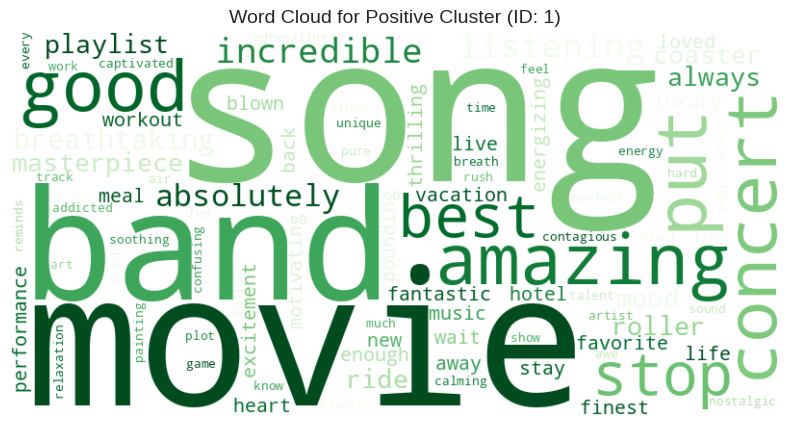

✓ Positive cluster word cloud generated.

--- Generating Word Cloud for Negative Cluster ---


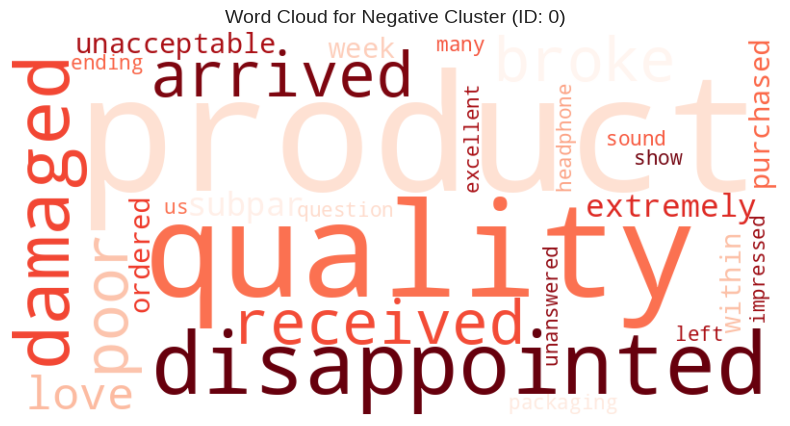

✓ Negative cluster word cloud generated.


In [90]:
# ============================================================================
# GENERATE WORD CLOUDS FOR SELECTED CLUSTERS
# ============================================================================

from wordcloud import WordCloud
import matplotlib.pyplot as plt

print("="*80)
print("GENERATING WORD CLOUDS FOR SELECTED CLUSTERS")
print("="*80)

# Ensure positive_cluster_texts and negative_cluster_texts are available
if 'positive_cluster_texts' in locals() and 'negative_cluster_texts' in locals():

    # --- Generate Word Cloud for Positive Cluster ---
    if not positive_cluster_texts.empty:
        print("\n--- Generating Word Cloud for Positive Cluster ---")
        # Join all text in the positive cluster into a single string
        positive_text = " ".join(positive_cluster_texts.astype(str))

        # Generate the word cloud
        wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)

        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud_positive, interpolation='bilinear')
        plt.axis("off")
        plt.title(f'Word Cloud for Positive Cluster (ID: {selected_positive_cluster})', fontsize=14)
        plt.show()
        print("✓ Positive cluster word cloud generated.")
    else:
        print("\nSkipping Positive Word Cloud: No text available for the selected positive cluster.")


    # --- Generate Word Cloud for Negative Cluster ---
    if not negative_cluster_texts.empty:
        print("\n--- Generating Word Cloud for Negative Cluster ---")
        # Join all text in the negative cluster into a single string
        negative_text = " ".join(negative_cluster_texts.astype(str))

        # Generate the word cloud
        wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud_negative, interpolation='bilinear')
        plt.axis("off")
        plt.title(f'Word Cloud for Negative Cluster (ID: {selected_negative_cluster})', fontsize=14)
        plt.show()
        print("✓ Negative cluster word cloud generated.")
    else:
         print("\nSkipping Negative Word Cloud: No text available for the selected negative cluster.")

else:
    print("Error: Required text data (positive_cluster_texts or negative_cluster_texts) not found. Please run previous extraction cell.")